# Analysis of VAE-Classifier Training Quality Control

**Objective**: Comprehensive quality control and performance analysis of the Beta-VAE + Classifier pipeline for Alzheimer's Disease diagnosis.

**Dataset**: ADNI multi-site fMRI data (N=431 subjects, 5-fold CV)

**Analysis Structure**:
1. Configuration & Data Loading
2. Distribution Quality Control
3. Model Performance Evaluation
4. Information Theory & Disentanglement
5. Statistical Validation & Ablation Studies
6. Publication-Ready Figures


In [1]:
# ===================== CELDA 0: CONFIG GLOBAL =====================
from pathlib import Path
import warnings
import numpy as np
 
import pandas as pd
import joblib

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

warnings.filterwarnings("ignore", category=FutureWarning)

# ---- PATH DEL EXPERIMENTO A ANALIZAR ----
RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro")
N_FOLDS = 5
TARGET_CLF = "logreg"  # cambia a "logreg", "svm", etc. si querés

print(f"[INFO] Analizando experimento en:\n{RESULTS_DIR.resolve()}")

# ---- ESTILO FIGURAS “Q1” ----
plt.style.use("default")
sns.set_style("white")

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# Carpeta para figuras/tablas de este experimento
OUTPUT_FIG_DIR = RESULTS_DIR / "training_qc"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)
print(f"[INFO] Figuras/tablas se guardarán en: {OUTPUT_FIG_DIR}")


[INFO] Analizando experimento en:
/home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro
[INFO] Figuras/tablas se guardarán en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc


In [2]:
# ===================== CELDA 0.5: GUARDRAILS (NO MEZCLAR RUNS) =====================
from pathlib import Path
import re, ast
import numpy as np
import pandas as pd
import joblib

def _infer_run_tag_from_latest_summary(results_dir: Path) -> str:
    summary_files = sorted(results_dir.glob("summary_metrics_MULTI_*.txt"),
                           key=lambda p: p.stat().st_mtime, reverse=True)
    if not summary_files:
        raise FileNotFoundError(f"No hay summary_metrics_MULTI_*.txt en {results_dir}")
    fname = summary_files[0].name
    run_tag = re.sub(r"^summary_metrics_MULTI_|\.txt$", "", fname)
    return run_tag, summary_files[0]

def _load_run_args_from_summary(summary_path: Path) -> dict:
    txt = summary_path.read_text()
    i0, i1 = txt.find("{"), txt.rfind("}")
    if i0 < 0 or i1 < 0 or i1 <= i0:
        raise ValueError(f"No pude extraer dict de {summary_path.name}")
    d = ast.literal_eval(txt[i0:i1+1])
    d["_summary_file_used"] = summary_path.name
    return d

def _must_exist(p: Path) -> Path:
    if not p.exists():
        raise FileNotFoundError(f"No existe: {p}")
    return p

# 1) RUN_TAG + run_args (fuente única)
RUN_TAG, _summary_path = _infer_run_tag_from_latest_summary(RESULTS_DIR)
run_args = _load_run_args_from_summary(_summary_path)

print("[INFO] RESULTS_DIR :", RESULTS_DIR)
print("[INFO] SUMMARY USED:", _summary_path.name)
print("[INFO] RUN_TAG     :", RUN_TAG)

# 2) Resolver artefactos SOLO dentro de RESULTS_DIR
metrics_path     = _must_exist(RESULTS_DIR / f"all_folds_metrics_MULTI_{RUN_TAG}.csv")
pred_joblib_path = _must_exist(RESULTS_DIR / f"all_folds_clf_predictions_MULTI_{RUN_TAG}.joblib")
vae_hist_path    = RESULTS_DIR / f"all_folds_vae_training_history_{RUN_TAG}.joblib"
vae_hist_path    = vae_hist_path if vae_hist_path.exists() else None

print("[OK] metrics_path    =", metrics_path.name)
print("[OK] pred_joblib_path=", pred_joblib_path.name)
print("[OK] vae_hist_path   =", None if vae_hist_path is None else vae_hist_path.name)

# 3) Asegurar metadata_aligned_to_tensor.csv LOCAL (sin fallback a otros experiments)
# Requiere que definas explícitamente estas rutas en tu notebook:
#   GLOBAL_TENSOR_PATH = Path(".../GLOBAL_TENSOR_....npz")
#   METADATA_PATH      = Path(".../SubjectsData_....csv")
META_ALIGNED = OUTPUT_FIG_DIR / "metadata_aligned_to_tensor.csv"

def _build_metadata_aligned_to_tensor(global_tensor_npz: Path, metadata_csv: Path, out_csv: Path,
                                      id_col_candidates=("SubjectID","RID","participant_id","ID")):
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    npz = np.load(global_tensor_npz, allow_pickle=True)
    if "subject_ids" not in npz.files:
        raise KeyError(f"NPZ no tiene 'subject_ids'. Keys={list(npz.files)}")

    tensor_ids = npz["subject_ids"]
    if getattr(tensor_ids, "dtype", None) is not None and tensor_ids.dtype.kind == "S":
        tensor_ids = np.array([x.decode("utf-8", errors="ignore") for x in tensor_ids], dtype=object)
    tensor_ids = pd.Series(tensor_ids).astype(str).str.strip()

    meta = pd.read_csv(metadata_csv)
    id_meta = next((c for c in id_col_candidates if c in meta.columns), None)
    if id_meta is None:
        raise KeyError(f"No encontré ID en metadata. Probé {id_col_candidates}")

    meta = meta.copy()
    meta["_id"] = meta[id_meta].astype(str).str.strip()
    meta_map = meta.set_index("_id", drop=False)

    missing = (~tensor_ids.isin(meta_map.index)).sum()
    if missing != 0:
        raise ValueError(f"No pude alinear: faltan {missing} IDs del tensor en metadata (match por {id_meta}).")

    aligned = meta_map.loc[tensor_ids.values].reset_index(drop=True)
    aligned["tensor_idx"] = np.arange(len(aligned), dtype=int)
    aligned.to_csv(out_csv, index=False)
    return out_csv

if not META_ALIGNED.exists():
    if "GLOBAL_TENSOR_PATH" not in globals() or "METADATA_PATH" not in globals():
        raise ValueError("Definí GLOBAL_TENSOR_PATH y METADATA_PATH antes de correr guardrails.")
    _build_metadata_aligned_to_tensor(Path(GLOBAL_TENSOR_PATH), Path(METADATA_PATH), META_ALIGNED)
    print("[OK] Generado:", META_ALIGNED)
else:
    print("[OK] Ya existe:", META_ALIGNED)

# 4) Cargar (a partir de ahora, siempre usar ESTA)
metadata_df_full = pd.read_csv(META_ALIGNED)
print("[INFO] metadata_df_full:", metadata_df_full.shape)


[INFO] RESULTS_DIR : /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro
[INFO] SUMMARY USED: summary_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.txt
[INFO] RUN_TAG     : svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc
[OK] metrics_path    = all_folds_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.csv
[OK] pred_joblib_path= all_folds_clf_predictions_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.joblib
[OK] vae_hist_path   = all_folds_vae_training_history_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.joblib
[OK] Ya existe: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/metadata_align

## 1. Configuration & Global Setup

This section establishes project paths, global configuration parameters, and reproducibility settings.


In [3]:
# ===================== CELDA 1: CARGA DE ARTEFACTOS =====================
# 1) Métricas agregadas por fold
metrics_path = next(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
metrics_df = pd.read_csv(metrics_path)
print(f"[OK] Métricas CV cargadas desde:\n{metrics_path.name}")

# 2) Historias de entrenamiento del VAE
try:
    vae_hist_path = next(RESULTS_DIR.glob("all_folds_vae_training_history_*.joblib"))
    vae_histories = joblib.load(vae_hist_path)
    print(f"[OK] Historias VAE cargadas ({len(vae_histories)} folds) desde:\n{vae_hist_path.name}")
except StopIteration:
    vae_histories = None
    print("[WARN] No se encontró all_folds_vae_training_history_*.joblib")

# 3) QC latente y Fuga de Manufacturer (outputs de analysis_qc.py + latent_qc_metrics.py)
qc_latent_list = []
leak_train_list = []
dist_raw_list, dist_norm_list, dist_recon_list = [], [], []

for k in range(1, N_FOLDS + 1):
    fold_dir = RESULTS_DIR / f"fold_{k}"

    # --- QC latente por fold ---
    qc_path = fold_dir / "latent_qc_metrics.csv"
    if qc_path.exists():
        df_qc = pd.read_csv(qc_path)
        if "fold" not in df_qc.columns:
            df_qc["fold"] = k
        qc_latent_list.append(df_qc)
    else:
        print(f"[WARN] No se encontró {qc_path.name} en fold_{k}")

    # --- Fuga de Manufacturer (LogReg multi-clase) ---
    leak_path = fold_dir / f"fold_{k}_scanner_leakage.csv"
    if leak_path.exists():
        df_leak = pd.read_csv(leak_path)
        df_leak["fold"] = k
        leak_train_list.append(df_leak)
    else:
        print(f"[WARN] No se encontró {leak_path.name}")

    # --- Stats de distribuciones (raw / norm / recon) ---
    for stage, store in [("raw", dist_raw_list),
                         ("norm", dist_norm_list),
                         ("recon", dist_recon_list)]:
        dist_path = fold_dir / f"fold_{k}_dist_{stage}.csv"
        if dist_path.exists():
            df_dist = pd.read_csv(dist_path)
            df_dist["fold"] = k
            store.append(df_dist)

qc_latent = pd.concat(qc_latent_list, ignore_index=True) if qc_latent_list else None
leak_train = pd.concat(leak_train_list, ignore_index=True) if leak_train_list else None
dist_raw_all = pd.concat(dist_raw_list, ignore_index=True) if dist_raw_list else None
dist_norm_all = pd.concat(dist_norm_list, ignore_index=True) if dist_norm_list else None
dist_recon_all = pd.concat(dist_recon_list, ignore_index=True) if dist_recon_list else None

print("\n[RESUMEN]")
print("  QC latente:", None if qc_latent is None else qc_latent.shape)
print("  Leakage train:", None if leak_train is None else leak_train.shape)
print("  Dist raw:", None if dist_raw_all is None else dist_raw_all.shape)
print("  Dist norm:", None if dist_norm_all is None else dist_norm_all.shape)
print("  Dist recon:", None if dist_recon_all is None else dist_recon_all.shape)


[OK] Métricas CV cargadas desde:
all_folds_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.csv
[OK] Historias VAE cargadas (5 folds) desde:
all_folds_vae_training_history_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.joblib

[RESUMEN]
  QC latente: (5, 12)
  Leakage train: (10, 11)
  Dist raw: (15, 8)
  Dist norm: (15, 8)
  Dist recon: (15, 8)



[INFO] Columnas detectadas por stage:


stage fold_col channel_col mean_col std_col
0    raw     fold     channel     mean     std
1   norm     fold     channel     mean     std
2  recon     fold     channel     mean     std

[OK] Tabla resumen guardada en:
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_dist_stats_by_stage_channel.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_dist_stats_by_stage_channel.tex


stage                           channel  mean_offdiag_mean  \
0    raw                  MI_KNN_Symmetric             0.0570   
1    raw       Pearson_Full_FisherZ_Signed            -0.0474   
2    raw  Pearson_OMST_GCE_Signed_Weighted             0.3094   
3   norm                  MI_KNN_Symmetric             0.0000   
4   norm       Pearson_Full_FisherZ_Signed             0.0000   
5   norm  Pearson_OMST_GCE_Signed_Weighted            -0.0000   
6  recon                  MI_KNN_Symmetric            -0.0193   
7  recon       Pearson_Full_FisherZ_Signed             0.0368   
8  recon  Pearson_OMST_GCE_Signed_Weighted            -0.0586   

   mean_offdiag_sd  std_offdiag_mean  std_offdiag_sd  n  
0           0.0022            0.8143          0.0016  5  
1           0.0020            0.7771          0.0023  5  
2           0.0009            1.0917          0.0025  5  
3           0.0000            1.0000          0.0000  5  
4           0.0000            1.0000          0.0000  5  
5           0.0000            1.0000          0.0000  5  
6           0.0026            0.6377          0.0026  5  
7           0.0024            0.6856          0.0018  5  
8           0.0031            0.3487          0.0037  5

[OK] Tabla de deltas guardada en:
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_dist_deltas_by_channel.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_dist_deltas_by_channel.tex


channel  d_mean_norm_raw_mean  d_mean_norm_raw_sd  \
0                  MI_KNN_Symmetric               -0.0570              0.0022   
1       Pearson_Full_FisherZ_Signed                0.0474              0.0020   
2  Pearson_OMST_GCE_Signed_Weighted               -0.3094              0.0009   

   d_mean_recon_norm_mean  d_mean_recon_norm_sd  d_std_norm_raw_mean  \
0                 -0.0193                0.0026               0.1857   
1                  0.0368                0.0024               0.2229   
2                 -0.0586                0.0031              -0.0917   

   d_std_norm_raw_sd  d_std_recon_norm_mean  d_std_recon_norm_sd  n_folds  
0             0.0016                -0.3623               0.0026        5  
1             0.0023                -0.3144               0.0018        5  
2             0.0025                -0.6513               0.0037        5

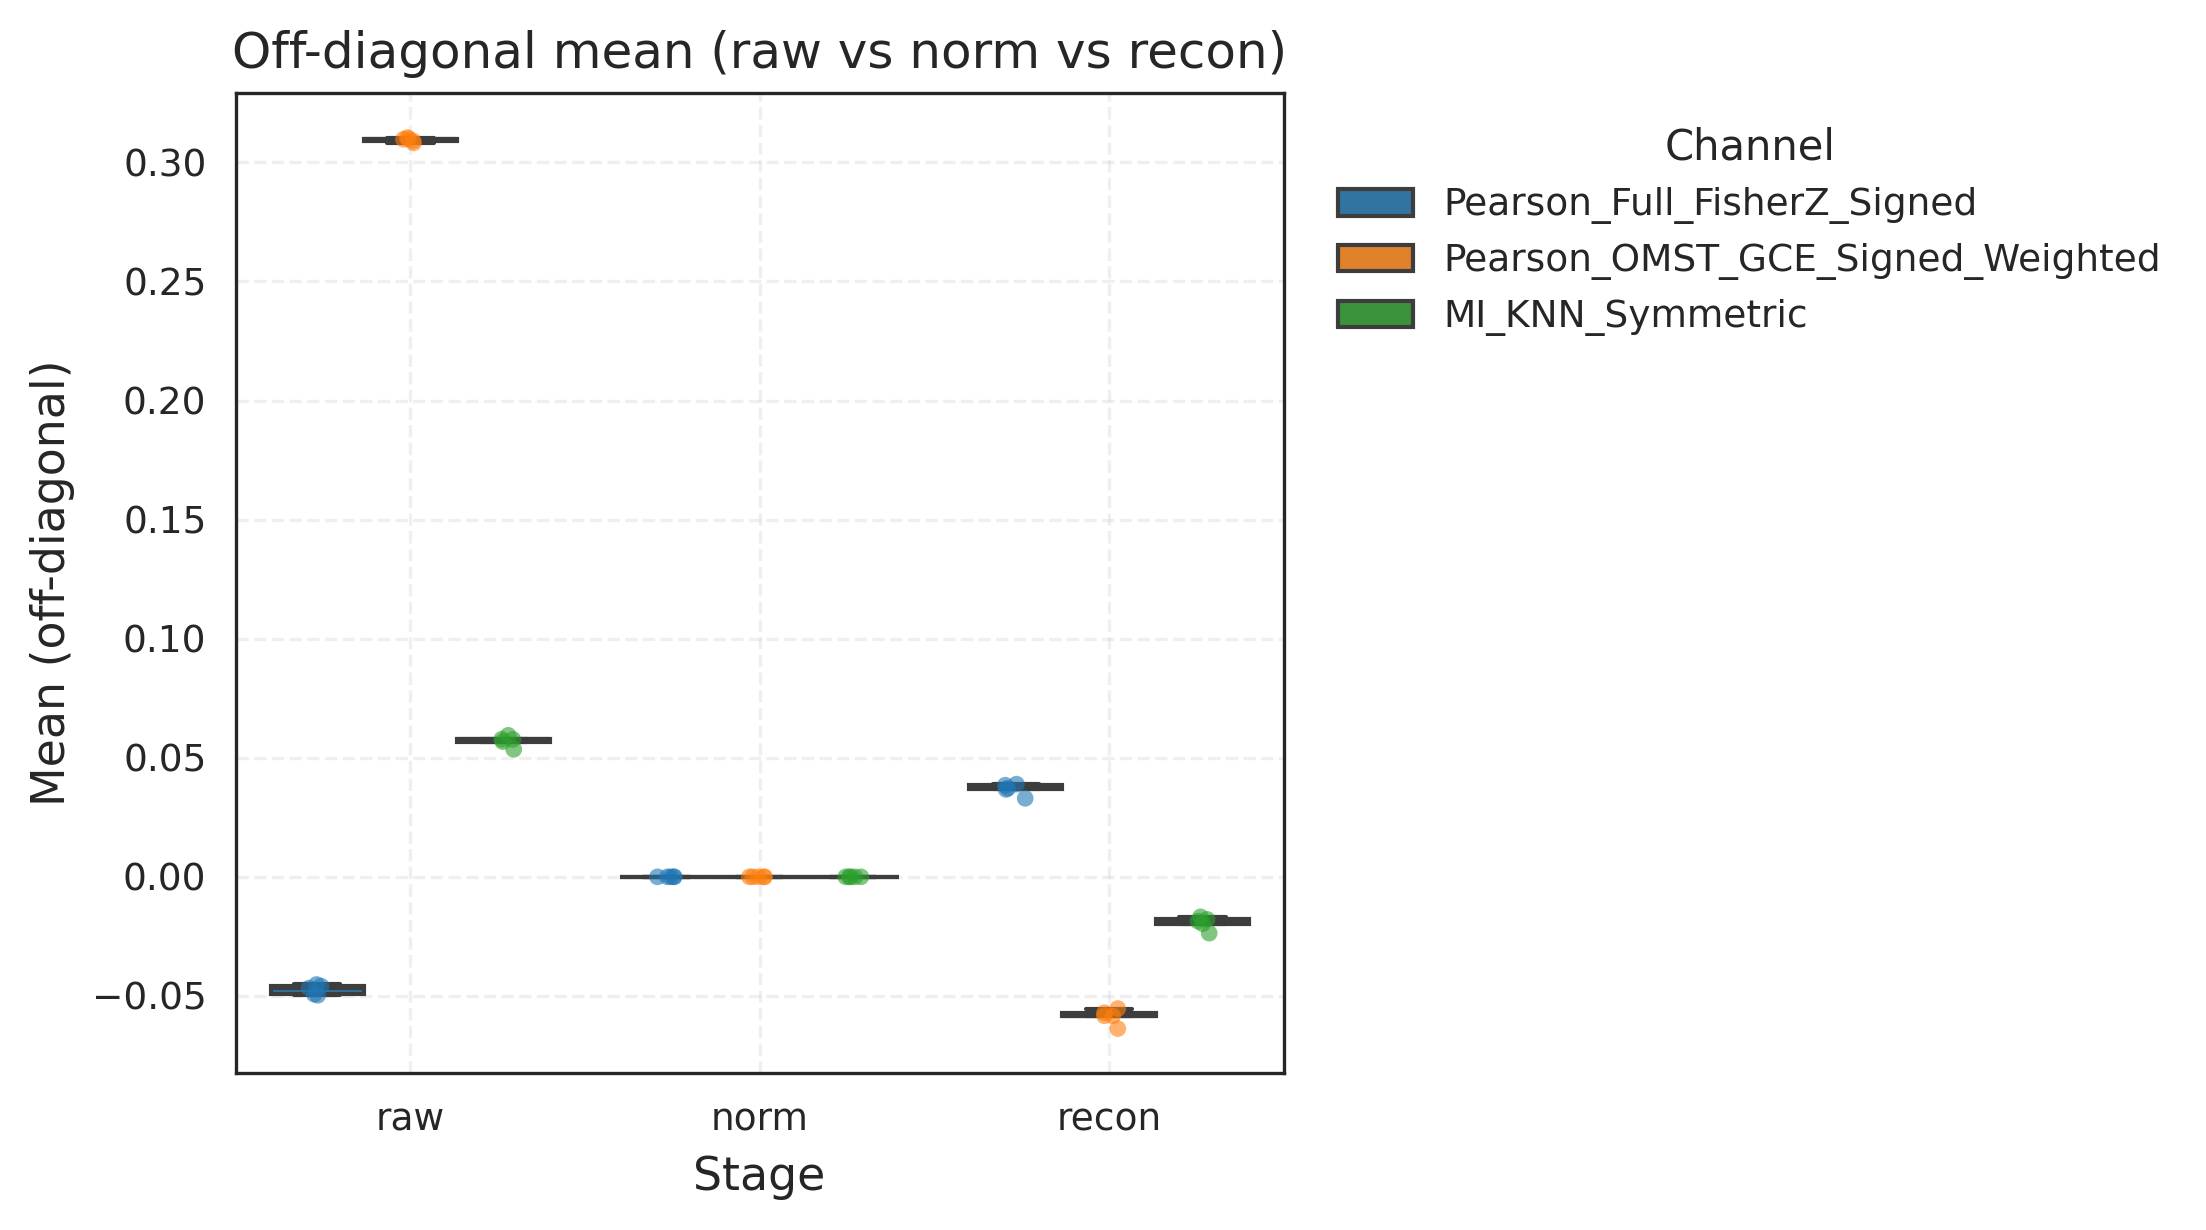

[OK] Figura mean_offdiag guardada.


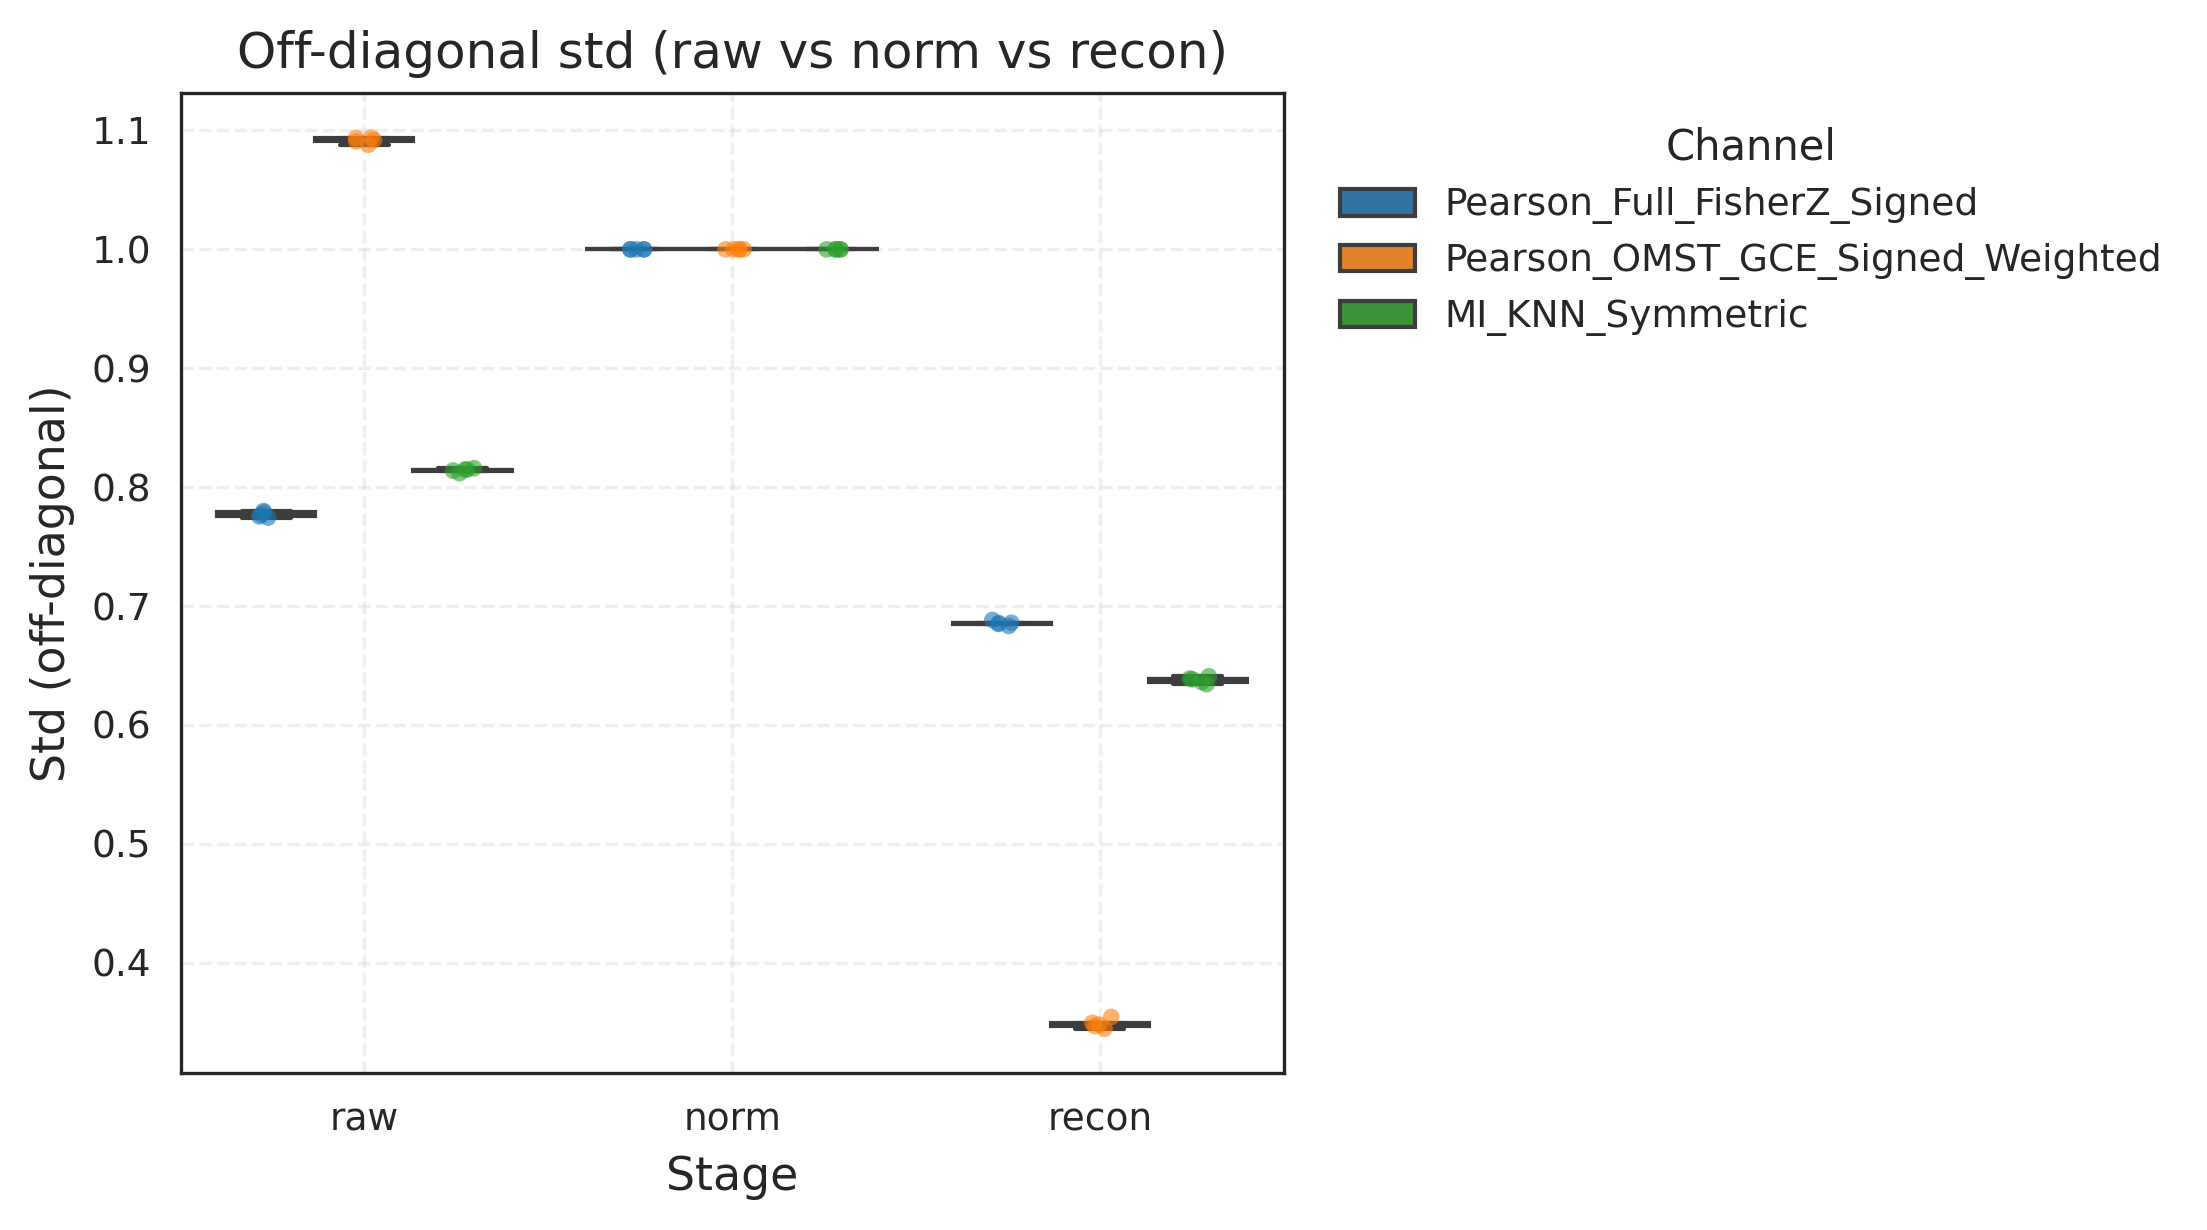

[OK] Figura std_offdiag guardada.
[OK] Dataset largo guardado en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/dist_stats_long_raw_norm_recon.csv


In [4]:
# ===================== CELDA 1b: DIST QC (raw vs norm vs recon) =====================
import re
 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# 0) Chequeos mínimos
# ---------------------------------------------------------------------
missing = []
for name in ["dist_raw_all", "dist_norm_all", "dist_recon_all"]:
    if name not in globals() or globals()[name] is None:
        missing.append(name)

if missing:
    print(f"[WARN] No hay datos para: {missing}. "
          "Verificá que existan fold_k_dist_raw/norm/recon.csv en cada fold.")
else:
    # -----------------------------------------------------------------
    # 1) Helpers robustos para detectar columnas
    # -----------------------------------------------------------------
    def _norm_colname(c: str) -> str:
        return re.sub(r"\s+", "_", str(c).strip().lower())

    def find_first_col(df: pd.DataFrame, required_tokens, forbidden_tokens=None):
        """
        Busca la primera columna cuyo nombre (lower) contiene TODOS los tokens requeridos
        y NO contiene ninguno de los tokens prohibidos.
        """
        forbidden_tokens = forbidden_tokens or []
        cols = list(df.columns)
        cols_norm = [_norm_colname(c) for c in cols]

        for c, cn in zip(cols, cols_norm):
            if all(tok in cn for tok in required_tokens) and all(tok not in cn for tok in forbidden_tokens):
                return c
        return None

    def find_channel_col(df: pd.DataFrame):
        # candidatos típicos
        candidates = [
            "channel", "ch", "ch_idx", "channel_idx", "channel_id", "channel_name",
            "modality", "metric", "connectivity", "connectivity_metric"
        ]
        cols_norm = {_norm_colname(c): c for c in df.columns}
        for cand in candidates:
            if cand in cols_norm:
                return cols_norm[cand]
        # fallback: buscar algo que contenga "channel" o "ch"
        for c in df.columns:
            cn = _norm_colname(c)
            if "channel" in cn or re.fullmatch(r"ch(_idx|_id)?", cn) is not None:
                return c
        return None

    def find_fold_col(df: pd.DataFrame):
        for cand in ["fold", "kfold", "outer_fold", "fold_id"]:
            c = find_first_col(df, [cand])
            if c is not None:
                return c
        return None

    def pick_mean_std_offdiag_cols(df: pd.DataFrame):
        """
        Intenta detectar columnas que representen:
        - mean_offdiag
        - std_offdiag
        de forma robusta ante nombres distintos.
        """
        # intentos "fuertes"
        mean_col = (
            find_first_col(df, ["mean", "off"]) or
            find_first_col(df, ["avg", "off"]) or
            find_first_col(df, ["mu", "off"]) or
            find_first_col(df, ["mean", "offdiag"]) or
            find_first_col(df, ["mean_offdiag"])  # por si quedó literal
        )
        std_col = (
            find_first_col(df, ["std", "off"]) or
            find_first_col(df, ["sd", "off"]) or
            find_first_col(df, ["sigma", "off"]) or
            find_first_col(df, ["std", "offdiag"]) or
            find_first_col(df, ["std_offdiag"])
        )

        # fallback "suave" si no hay offdiag explícito (evitar columnas tipo std_loss)
        if mean_col is None:
            mean_col = find_first_col(df, ["mean"], forbidden_tokens=["loss", "kld", "beta", "recon"])
        if std_col is None:
            std_col = find_first_col(df, ["std"], forbidden_tokens=["loss", "kld", "beta", "recon"])

        return mean_col, std_col

    # -----------------------------------------------------------------
    # 2) Consolidar a formato largo (stage, fold, channel, mean_offdiag, std_offdiag)
    # -----------------------------------------------------------------
    stage_dfs = {
        "raw": dist_raw_all.copy(),
        "norm": dist_norm_all.copy(),
        "recon": dist_recon_all.copy(),
    }

    long_rows = []
    chosen_cols_report = []

    for stage, df in stage_dfs.items():
        if df is None or df.empty:
            continue

        # columnas candidatas
        fold_col = find_fold_col(df) or "fold" if "fold" in df.columns else None
        ch_col = find_channel_col(df)
        mean_col, std_col = pick_mean_std_offdiag_cols(df)

        chosen_cols_report.append({
            "stage": stage,
            "fold_col": fold_col,
            "channel_col": ch_col,
            "mean_col": mean_col,
            "std_col": std_col,
        })

        if mean_col is None or std_col is None:
            print(f"[WARN] No pude detectar mean/std offdiag en stage='{stage}'. "
                  f"mean_col={mean_col}, std_col={std_col}. "
                  "Mostrando columnas disponibles para depurar:")
            print(list(df.columns))
            continue

        df2 = df.copy()
        df2["stage"] = stage

        if fold_col is None:
            df2["fold"] = np.nan
            fold_col = "fold"
        else:
            # normalizar nombre a "fold"
            if fold_col != "fold":
                df2["fold"] = df2[fold_col]
                fold_col = "fold"

        if ch_col is None:
            df2["channel"] = "all"
        else:
            df2["channel"] = df2[ch_col].astype(str)

        # construir long (uno-a-uno)
        tmp = df2[["stage", fold_col, "channel", mean_col, std_col]].copy()
        tmp = tmp.rename(columns={
            mean_col: "mean_offdiag",
            std_col: "std_offdiag",
        })
        long_rows.append(tmp)

    if not long_rows:
        print("[WARN] No se pudo construir dist_long (no hay columnas detectables).")
    else:
        dist_long = pd.concat(long_rows, ignore_index=True)

        # limpieza básica
        dist_long["stage"] = pd.Categorical(dist_long["stage"], categories=["raw", "norm", "recon"], ordered=True)

        # -----------------------------------------------------------------
        # 3) Reporte rápido de qué columnas se usaron (para trazabilidad)
        # -----------------------------------------------------------------
        chosen_df = pd.DataFrame(chosen_cols_report)
        print("\n[INFO] Columnas detectadas por stage:")
        display(chosen_df)

        # -----------------------------------------------------------------
        # 4) Tabla resumen (mean ± sd) por stage × channel
        # -----------------------------------------------------------------
        summary = (
            dist_long
            .groupby(["stage", "channel"], as_index=False)
            .agg(
                mean_offdiag_mean=("mean_offdiag", "mean"),
                mean_offdiag_sd=("mean_offdiag", "std"),
                std_offdiag_mean=("std_offdiag", "mean"),
                std_offdiag_sd=("std_offdiag", "std"),
                n=("mean_offdiag", "count"),
            )
        )

        # guardado
        out_csv = OUTPUT_FIG_DIR / "table_dist_stats_by_stage_channel.csv"
        out_tex = OUTPUT_FIG_DIR / "table_dist_stats_by_stage_channel.tex"
        summary.to_csv(out_csv, index=False)
        with open(out_tex, "w") as f:
            f.write(summary.round(4).to_latex(index=False, escape=False, column_format="llccccc"))

        print(f"[OK] Tabla resumen guardada en:\n  {out_csv}\n  {out_tex}")
        display(summary.round(4))

        # -----------------------------------------------------------------
        # 5) Tabla de deltas (norm-raw, recon-norm, recon-raw) por channel
        # -----------------------------------------------------------------
        # Promediamos primero por fold para no “duplicar” en caso de filas extra
        per_fold = (
            dist_long
            .groupby(["stage", "channel", "fold"], as_index=False)
            .agg(
                mean_offdiag=("mean_offdiag", "mean"),
                std_offdiag=("std_offdiag", "mean"),
            )
        )
        wide = per_fold.pivot_table(index=["channel", "fold"], columns="stage", values=["mean_offdiag", "std_offdiag"])
        # columnas multiindex -> columnas planas
        wide.columns = [f"{a}__{b}" for a, b in wide.columns]
        wide = wide.reset_index()

        def safe_delta(dfw, base, other, prefix):
            a = f"{prefix}__{other}"
            b = f"{prefix}__{base}"
            if a in dfw.columns and b in dfw.columns:
                return dfw[a] - dfw[b]
            return np.nan

        wide["d_mean_norm_raw"]   = safe_delta(wide, "raw",  "norm",  "mean_offdiag")
        wide["d_mean_recon_norm"] = safe_delta(wide, "norm", "recon", "mean_offdiag")
        wide["d_mean_recon_raw"]  = safe_delta(wide, "raw",  "recon", "mean_offdiag")

        wide["d_std_norm_raw"]    = safe_delta(wide, "raw",  "norm",  "std_offdiag")
        wide["d_std_recon_norm"]  = safe_delta(wide, "norm", "recon", "std_offdiag")
        wide["d_std_recon_raw"]   = safe_delta(wide, "raw",  "recon", "std_offdiag")

        delta_summary = (
            wide
            .groupby("channel", as_index=False)
            .agg(
                d_mean_norm_raw_mean=("d_mean_norm_raw", "mean"),
                d_mean_norm_raw_sd=("d_mean_norm_raw", "std"),
                d_mean_recon_norm_mean=("d_mean_recon_norm", "mean"),
                d_mean_recon_norm_sd=("d_mean_recon_norm", "std"),
                d_std_norm_raw_mean=("d_std_norm_raw", "mean"),
                d_std_norm_raw_sd=("d_std_norm_raw", "std"),
                d_std_recon_norm_mean=("d_std_recon_norm", "mean"),
                d_std_recon_norm_sd=("d_std_recon_norm", "std"),
                n_folds=("fold", "nunique"),
            )
        )

        out_csv_d = OUTPUT_FIG_DIR / "table_dist_deltas_by_channel.csv"
        out_tex_d = OUTPUT_FIG_DIR / "table_dist_deltas_by_channel.tex"
        delta_summary.to_csv(out_csv_d, index=False)
        with open(out_tex_d, "w") as f:
            f.write(delta_summary.round(4).to_latex(index=False, escape=False, column_format="lccccccccc"))

        print(f"[OK] Tabla de deltas guardada en:\n  {out_csv_d}\n  {out_tex_d}")
        display(delta_summary.round(4))

        # -----------------------------------------------------------------
        # 6) Figuras: box/strip por stage (raw/norm/recon) y channel
        # -----------------------------------------------------------------
        sns.set_style("white")
        plt.figure(figsize=(7.5, 4.2))
        ax = sns.boxplot(data=dist_long, x="stage", y="mean_offdiag", hue="channel", showfliers=False)
        sns.stripplot(data=dist_long, x="stage", y="mean_offdiag", hue="channel",
                      dodge=True, alpha=0.6, size=4, linewidth=0, ax=ax)
        # deduplicar leyenda (box + strip)
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles[:len(set(labels))], labels[:len(set(labels))],
                      title="Channel", frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
        ax.set_title("Off-diagonal mean (raw vs norm vs recon)")
        ax.set_xlabel("Stage")
        ax.set_ylabel("Mean (off-diagonal)")
        ax.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.savefig(OUTPUT_FIG_DIR / "figure_dist_mean_offdiag_by_stage_channel.pdf", bbox_inches="tight")
        plt.savefig(OUTPUT_FIG_DIR / "figure_dist_mean_offdiag_by_stage_channel.png", dpi=300, bbox_inches="tight")
        plt.show()
        print("[OK] Figura mean_offdiag guardada.")

        sns.set_style("white")
        plt.figure(figsize=(7.5, 4.2))
        ax = sns.boxplot(data=dist_long, x="stage", y="std_offdiag", hue="channel", showfliers=False)
        sns.stripplot(data=dist_long, x="stage", y="std_offdiag", hue="channel",
                      dodge=True, alpha=0.6, size=4, linewidth=0, ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles[:len(set(labels))], labels[:len(set(labels))],
                      title="Channel", frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
        ax.set_title("Off-diagonal std (raw vs norm vs recon)")
        ax.set_xlabel("Stage")
        ax.set_ylabel("Std (off-diagonal)")
        ax.grid(True, linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.savefig(OUTPUT_FIG_DIR / "figure_dist_std_offdiag_by_stage_channel.pdf", bbox_inches="tight")
        plt.savefig(OUTPUT_FIG_DIR / "figure_dist_std_offdiag_by_stage_channel.png", dpi=300, bbox_inches="tight")
        plt.show()
        print("[OK] Figura std_offdiag guardada.")

        # -----------------------------------------------------------------
        # 7) Export opcional: dataset largo para trazabilidad
        # -----------------------------------------------------------------
        dist_long.to_csv(OUTPUT_FIG_DIR / "dist_stats_long_raw_norm_recon.csv", index=False)
        print(f"[OK] Dataset largo guardado en: {OUTPUT_FIG_DIR / 'dist_stats_long_raw_norm_recon.csv'}")


In [5]:
# ===================== CELDA 1c: RUN ARGS (desde summary_metrics*.txt) =====================
import ast
from pathlib import Path

def load_run_args(results_dir: Path) -> dict:
    summary_files = sorted(
        list(results_dir.glob("summary_metrics*.txt")),
        key=lambda p: p.stat().st_mtime,
        reverse=True
    )
    if not summary_files:
        raise FileNotFoundError("No se encontró summary_metrics*.txt en RESULTS_DIR.")

    txt = summary_files[0].read_text()

    i0, i1 = txt.find("{"), txt.rfind("}")
    if i0 < 0 or i1 < 0 or i1 <= i0:
        raise ValueError(f"No se pudo extraer dict de {summary_files[0].name}")

    run_args = ast.literal_eval(txt[i0:i1+1])
    run_args["_summary_file_used"] = summary_files[0].name
    return run_args

try:
    run_args = load_run_args(RESULTS_DIR)
    print(f"[OK] run_args cargado desde: {run_args.get('_summary_file_used')}")
except Exception as e:
    print(f"[WARN] No se pudo cargar run_args ({e}). Usando fallback consistente con este notebook.")
    run_args = {
        "channels_to_use": [1, 0, 2],
        "latent_dim": 128,
        "num_conv_layers_encoder": 4,
        "decoder_type": "convtranspose",
        "vae_final_activation": "linear",
        "intermediate_fc_dim_vae": "quarter",
        "dropout_rate_vae": 0.2,
        "use_layernorm_vae_fc": False,
    }

print("[INFO] Canales:", run_args["channels_to_use"])
print("[INFO] Latent dim:", run_args["latent_dim"])
print("[INFO] Encoder conv layers:", run_args["num_conv_layers_encoder"])
print("[INFO] intermediate_fc:", run_args["intermediate_fc_dim_vae"])
print("[INFO] dropout:", run_args["dropout_rate_vae"])
print("[INFO] final act:", run_args["vae_final_activation"])
print("[INFO] decoder type:", run_args["decoder_type"])
print("[INFO] layernorm en FC:", run_args["use_layernorm_vae_fc"])

[OK] run_args cargado desde: summary_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.txt
[INFO] Canales: [1, 0, 2]
[INFO] Latent dim: 256
[INFO] Encoder conv layers: 4
[INFO] intermediate_fc: quarter
[INFO] dropout: 0.15
[INFO] final act: tanh
[INFO] decoder type: convtranspose
[INFO] layernorm en FC: False


In [6]:
# === Helper: resolver artefactos por RUN_TAG (derivado del summary_metrics usado) ===
from pathlib import Path

def infer_run_tag_from_summary(fname: str) -> str:
    # summary_metrics_MULTI_<TAG>.txt  ->  <TAG>
    return re.sub(r"^summary_metrics_MULTI_|\.txt$", "", Path(fname).name)

def must_exist(p: Path) -> Path:
    if not p.exists():
        raise FileNotFoundError(f"No existe: {p}")
    return p

# run_args ya viene de tu Celda 1c
RUN_TAG = infer_run_tag_from_summary(run_args["_summary_file_used"])
print("[INFO] RUN_TAG =", RUN_TAG)

metrics_path    = must_exist(RESULTS_DIR / f"all_folds_metrics_MULTI_{RUN_TAG}.csv")
pred_joblib_path= must_exist(RESULTS_DIR / f"all_folds_clf_predictions_MULTI_{RUN_TAG}.joblib")
vae_hist_path   = (RESULTS_DIR / f"all_folds_vae_training_history_{RUN_TAG}.joblib")
if not vae_hist_path.exists():
    vae_hist_path = None


[INFO] RUN_TAG = svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc


In [7]:
# ===================== CELDA 2: TABLA MAESTRA POR FOLD =====================
# nos quedamos con el clasificador objetivo
m_clf = metrics_df[metrics_df["actual_classifier_type"] == TARGET_CLF].copy()
if m_clf.empty:
    raise ValueError(f"No hay filas para actual_classifier_type == '{TARGET_CLF}'")

# --- pivot de leakage (LogReg sitio) ---
if leak_train is not None:
    leak_pivot = (
        leak_train
        .pivot_table(index="fold",
                     columns="representation",
                     values="balanced_accuracy_mean")
        .rename(columns={
            "connectome_norm": "BA_Manufacturer_connectome_norm",
            "latent_mu": "BA_Manufacturer_latent_mu"
        })
        .reset_index()
    )
    # chance: 1 / n_clases por fold
    chance_manufacturer = (
        leak_train.groupby("fold")["n_classes"]
        .first()
        .rdiv(1.0)
        .reset_index()
        .rename(columns={"n_classes": "BA_Manufacturer_chance"})
    )
    leak_summary = leak_pivot.merge(chance_manufacturer, on="fold", how="left")
else:
    leak_summary = pd.DataFrame()

# --- merge métricas + QC latente + leakage ---
df_summary = m_clf.merge(qc_latent, on="fold", how="left", suffixes=("","_latentqc"))
if not leak_summary.empty:
    df_summary = df_summary.merge(leak_summary, on="fold", how="left")

# métricas derivadas
if "acc_manufacturer_latent" in df_summary.columns and "chance_level" in df_summary.columns:
    df_summary["Delta_manufacturer_latent_knn"] = df_summary["acc_manufacturer_latent"] - df_summary["chance_level"]
    df_summary["Delta_manufacturer_raw_knn"]    = df_summary["acc_manufacturer_raw"] - df_summary["chance_level"]

if "BA_Manufacturer_latent_mu" in df_summary.columns and "BA_Manufacturer_chance" in df_summary.columns:
    df_summary["Delta_manufacturer_latent_logreg"] = df_summary["BA_Manufacturer_latent_mu"] - df_summary["BA_Manufacturer_chance"]
    df_summary["Delta_manufacturer_conn_logreg"]   = df_summary["BA_Manufacturer_connectome_norm"] - df_summary["BA_Manufacturer_chance"]

cols_show = [
    "fold", "auc", "balanced_accuracy",
    "silhouette_latent",
    "acc_manufacturer_latent", "acc_manufacturer_raw", "chance_level",
    "BA_Manufacturer_connectome_norm", "BA_Manufacturer_latent_mu", "BA_Manufacturer_chance",
    "Delta_manufacturer_latent_knn", "Delta_manufacturer_latent_logreg"
]
cols_show = [c for c in cols_show if c in df_summary.columns]

display(df_summary[cols_show].round(4))

# guardamos para el paper
csv_path = OUTPUT_FIG_DIR / "table_training_qc_summary.csv"
tex_path = OUTPUT_FIG_DIR / "table_training_qc_summary.tex"

df_summary_round = df_summary.copy()
for c in df_summary_round.columns:
    if df_summary_round[c].dtype.kind in "fc":
        df_summary_round[c] = df_summary_round[c].round(3)

df_summary_round.to_csv(csv_path, index=False)
with open(tex_path, "w") as f:
    f.write(df_summary_round[cols_show].to_latex(index=False, escape=False, column_format="ccccccccccc"))

print(f"[OK] Tabla maestra guardada en:\n  {csv_path}\n  {tex_path}")


fold     auc  balanced_accuracy  silhouette_latent  chance_level  \
0     1  0.8860             0.7851             0.0296           NaN   
1     2  0.8187             0.7822             0.0166           NaN   
2     3  0.8567             0.7295             0.0245        0.3333   
3     4  0.7994             0.7222             0.0098        0.3333   
4     5  0.8421             0.7740             0.0120        0.3333   

   BA_Manufacturer_connectome_norm  BA_Manufacturer_latent_mu  \
0                           0.7773                     0.7281   
1                           0.7094                     0.7832   
2                           0.6939                     0.7141   
3                           0.6414                     0.7465   
4                           0.6498                     0.6959   

   BA_Manufacturer_chance  Delta_manufacturer_latent_logreg  
0                  0.3333                            0.3948  
1                  0.3333                            0.4498  
2                  0.3333                            0.3808  
3                  0.3333                            0.4131  
4                  0.3333                            0.3626

[OK] Tabla maestra guardada en:
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_training_qc_summary.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_training_qc_summary.tex


In [8]:
# === Resumen global (media ± SD) para el paper ===
cols_to_agg = [
    "auc",
    "balanced_accuracy",
    "silhouette_latent",
    "Delta_manufacturer_latent_knn",
    "Delta_manufacturer_latent_logreg"
]
cols_to_agg = [c for c in cols_to_agg if c in df_summary.columns]

summary_stats = df_summary[cols_to_agg].agg(["mean", "std"]).T
summary_stats = summary_stats.rename(columns={"mean": "mean", "std": "sd"})
display(summary_stats.round(3))

# opcional: export a LaTeX
with open(OUTPUT_FIG_DIR / "table_training_qc_summary_global.tex", "w") as f:
    f.write(summary_stats.round(3).to_latex(escape=False, column_format="lcc"))


mean     sd
auc                               0.841  0.034
balanced_accuracy                 0.759  0.030
silhouette_latent                 0.019  0.008
Delta_manufacturer_latent_logreg  0.400  0.033


--- Correlaciones (Spearman) ---
Spearman(Silhouette, AUC) = 0.900, p = 0.037
Spearman(manufacturer BA (latent, LogReg), AUC) = -0.500, p = 0.391


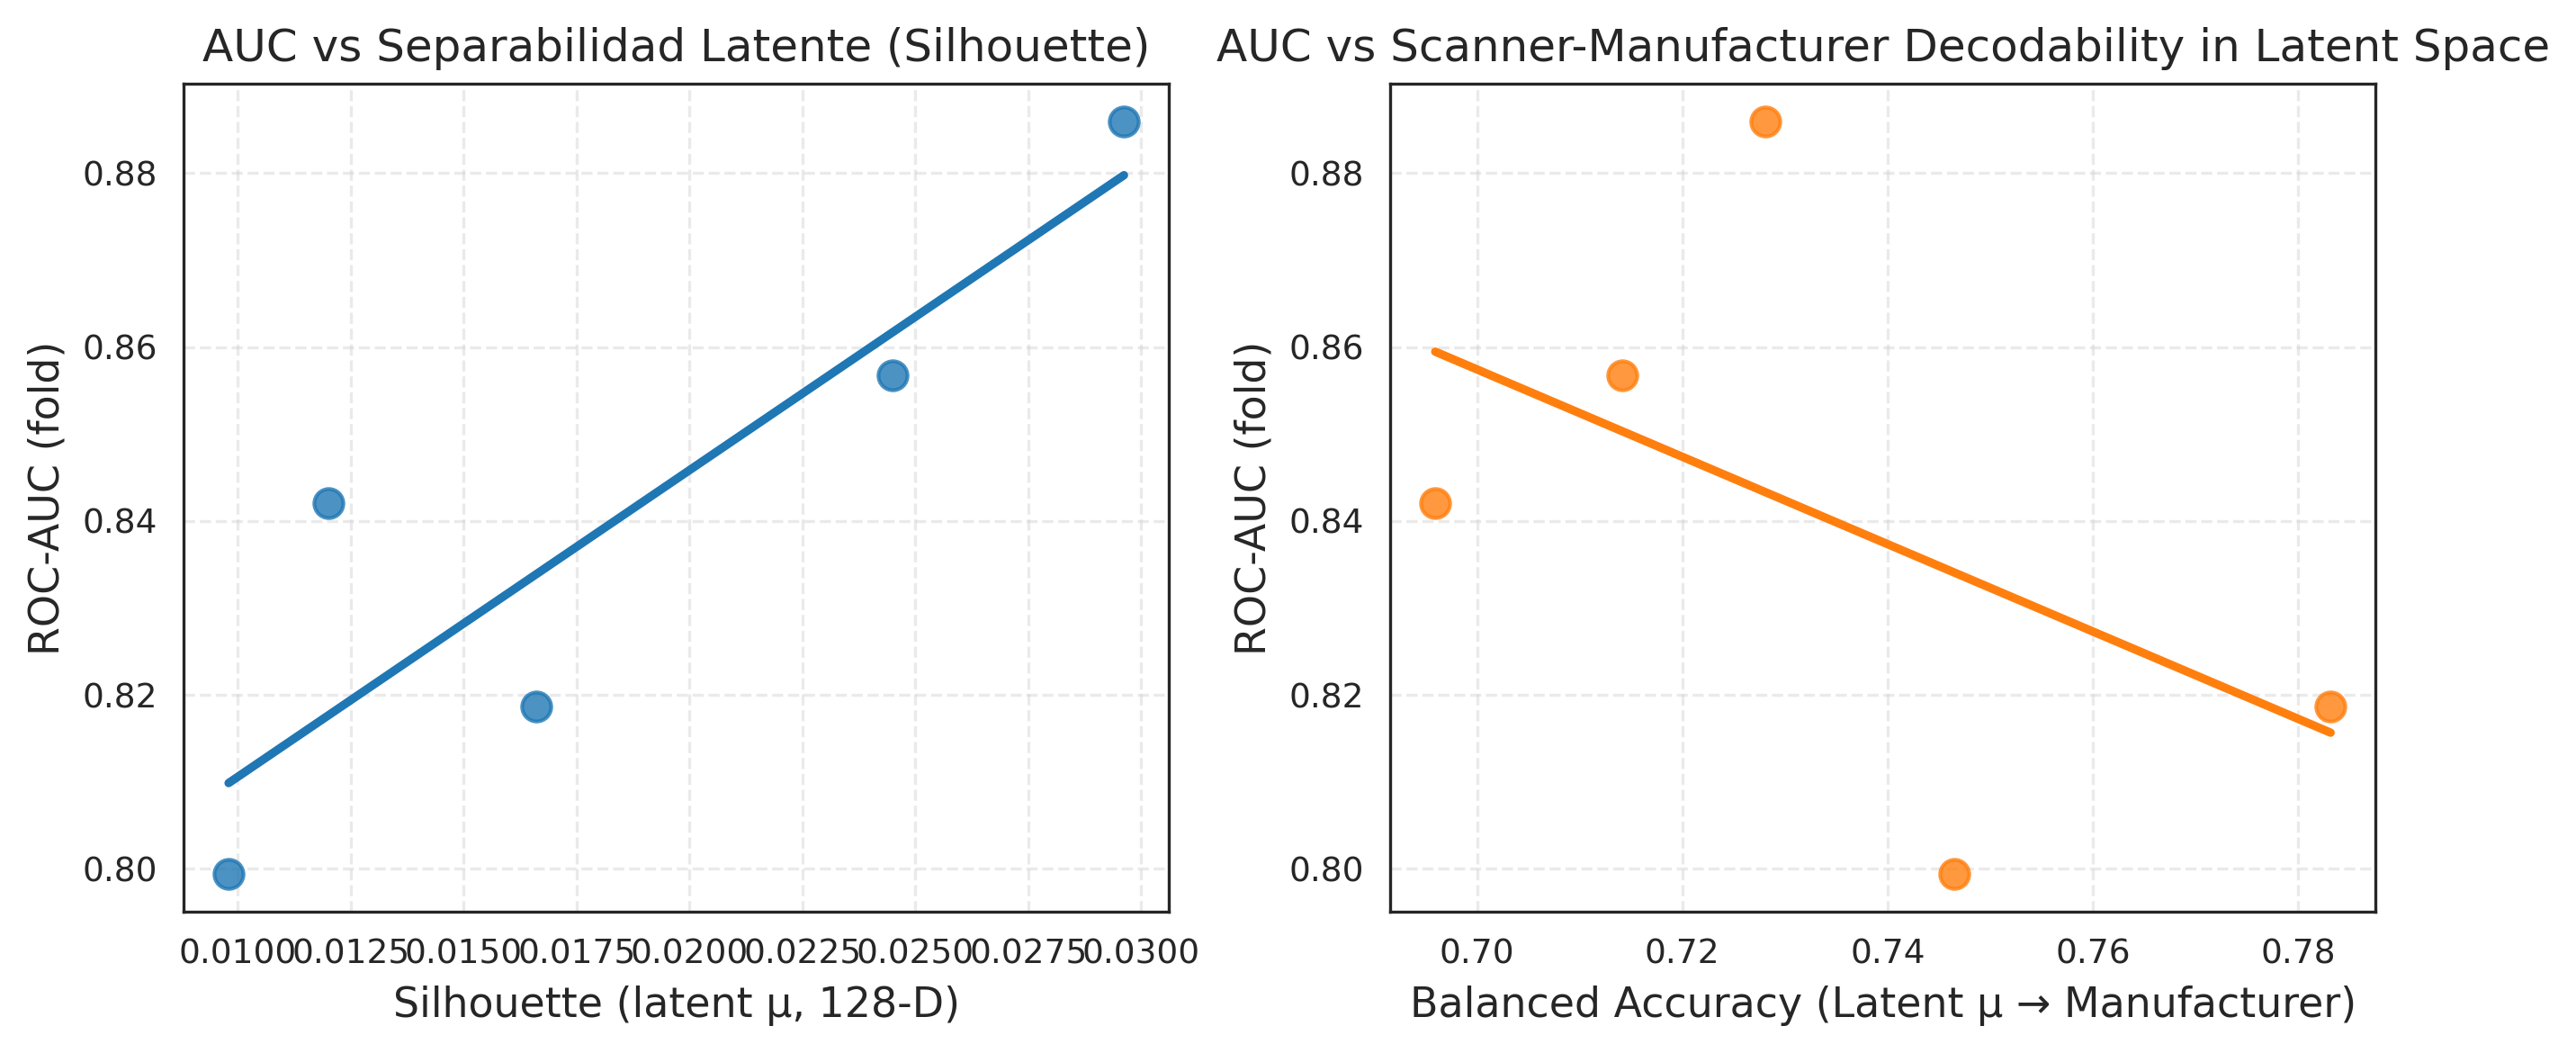

[OK] Figura AUC vs QC latente guardada.


In [9]:
# ===================== CELDA 3: CORRELACIONES AUC vs QC =====================
df_plot = df_summary.dropna(subset=["auc", "silhouette_latent"]).copy()

# correlaciones de Spearman (N=5 → interpretarlas con cautela)
def corr_and_print(x, y, label_x, label_y):
    r, p = spearmanr(x, y)
    print(f"Spearman({label_x}, {label_y}) = {r:.3f}, p = {p:.3f}")
    return r, p

print("\n--- Correlaciones (Spearman) ---")
corr_and_print(df_plot["silhouette_latent"], df_plot["auc"],
               "Silhouette", "AUC")

if "BA_Manufacturer_latent_mu" in df_plot.columns:
    corr_and_print(df_plot["BA_Manufacturer_latent_mu"], df_plot["auc"],
                   "manufacturer BA (latent, LogReg)", "AUC")

if "acc_manufacturer_latent" in df_plot.columns:
    corr_and_print(df_plot["acc_manufacturer_latent"], df_plot["auc"],
                   "Manufacturer acc (latent, kNN)", "AUC")

# --- Figura: AUC vs Silhouette y AUC vs fuga de sitio latente ---
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# A) AUC vs Silhouette
sns.regplot(data=df_plot, x="silhouette_latent", y="auc",
            ax=axes[0], ci=None, scatter_kws={"s":60})
axes[0].set_title("AUC vs Separabilidad Latente (Silhouette)")
axes[0].set_xlabel("Silhouette (latent μ, 128-D)")
axes[0].set_ylabel("ROC-AUC (fold)")
axes[0].grid(True, linestyle="--", alpha=0.4)

# B) AUC vs Fuga de Manufacturer en latente (LogReg)
if "BA_Manufacturer_latent_mu" in df_plot.columns:
    sns.regplot(data=df_plot, x="BA_Manufacturer_latent_mu", y="auc",
                ax=axes[1], ci=None, scatter_kws={"s":60}, color="tab:orange")
    axes[1].set_title("AUC vs Scanner-Manufacturer Decodability in Latent Space")
    axes[1].set_xlabel("Balanced Accuracy (Latent μ → Manufacturer)")
    axes[1].set_ylabel("ROC-AUC (fold)")
    axes[1].grid(True, linestyle="--", alpha=0.4)
else:
    axes[1].axis("off")

fig.tight_layout()
fig.savefig(OUTPUT_FIG_DIR / "figure_auc_vs_qc_latent.pdf", bbox_inches="tight")
fig.savefig(OUTPUT_FIG_DIR / "figure_auc_vs_qc_latent.png", dpi=300, bbox_inches="tight")

plt.show()
print("[OK] Figura AUC vs QC latente guardada.")


Ploteando dinámica VAE para folds: best=1, worst=4


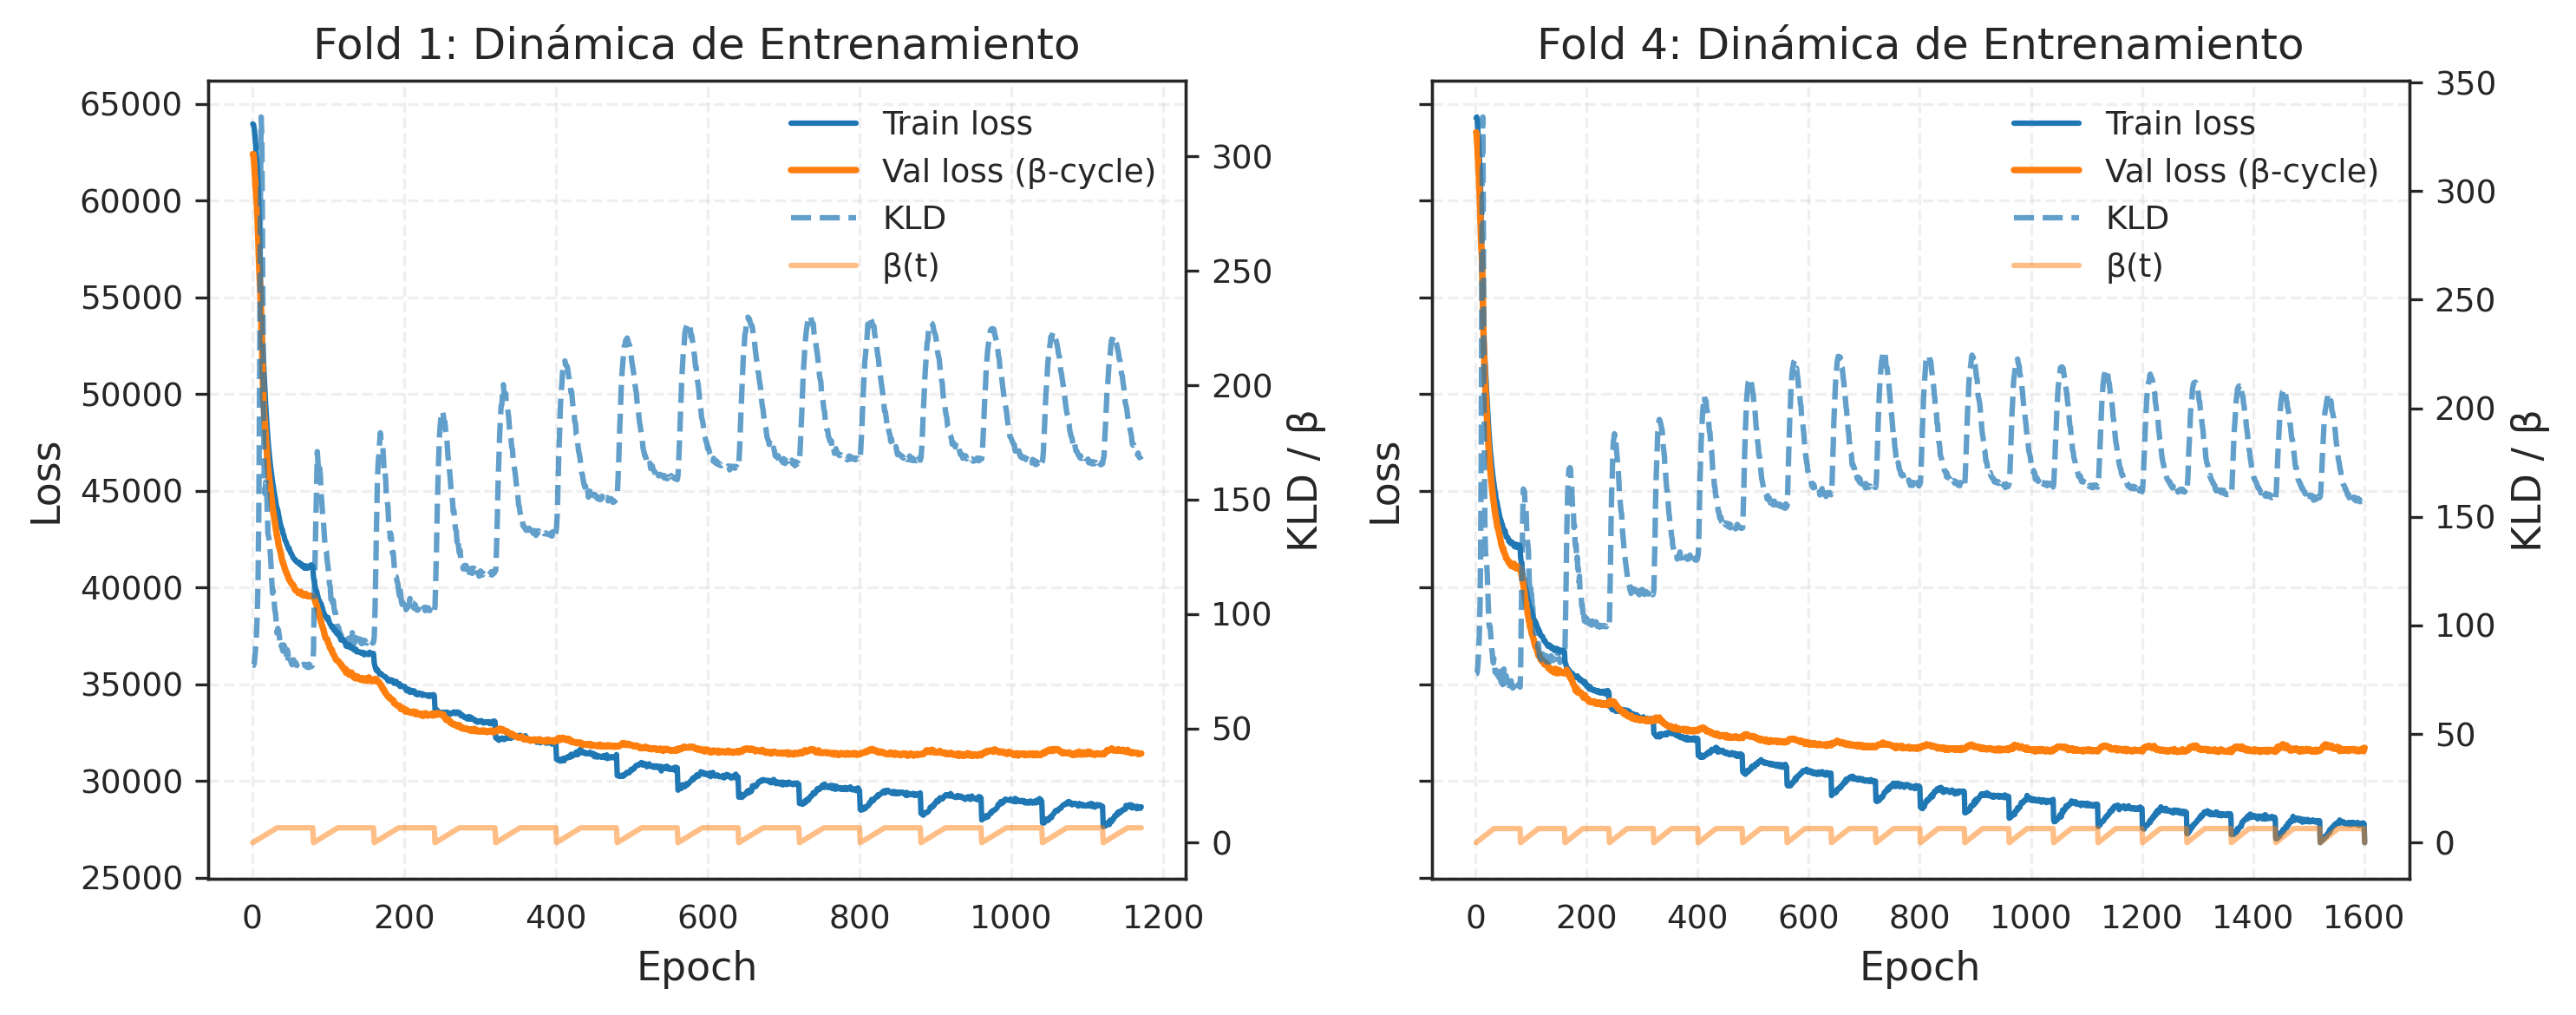

[OK] Dinámica VAE guardada.


In [10]:
# ===================== CELDA 4: DINÁMICA DE ENTRENAMIENTO VAE =====================
if vae_histories is None:
    print("[WARN] No se cargaron historias de entrenamiento del VAE.")
else:
    # identificamos fold con mejor y peor AUC
    best_fold = int(df_summary.loc[df_summary["auc"].idxmax(), "fold"])
    worst_fold = int(df_summary.loc[df_summary["auc"].idxmin(), "fold"])
    folds_to_plot = [best_fold, worst_fold]

    print(f"Ploteando dinámica VAE para folds: best={best_fold}, worst={worst_fold}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for ax, fold_k in zip(axes, folds_to_plot):
        history = vae_histories[fold_k - 1]  # lista, índice 0 → Fold 1

        epochs = np.arange(1, len(history["train_loss"]) + 1)
        ax.plot(epochs, history["train_loss"], label="Train loss", lw=1.5)
        ax.plot(epochs, history["val_loss_modelsel"], label="Val loss (β-cycle)", lw=1.8)

        ax2 = ax.twinx()
        ax2.plot(epochs, history["train_kld"], linestyle="--", alpha=0.7, label="KLD")
        ax2.plot(epochs, history["beta"], alpha=0.5, label="β(t)")

        ax.set_title(f"Fold {fold_k}: Dinámica de Entrenamiento")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax2.set_ylabel("KLD / β")

        # leyenda combinada
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc="upper right", frameon=False)

    fig.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "figure_vae_training_dynamics_best_vs_worst.pdf", bbox_inches="tight")
    fig.savefig(OUTPUT_FIG_DIR / "figure_vae_training_dynamics_best_vs_worst.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("[OK] Dinámica VAE guardada.")


In [11]:
# ===================== CELDA 5: LEAKAGE PAPER-GRADE (resumen + tests de permutación) =====================
import itertools
 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def exact_sign_permutation_test(delta, alternative="greater", n_mc=200000, seed=42):
    """
    Test de permutación por cambio de signo para muestras pareadas por fold.
    H0: media(delta) = 0
    """
    rng = np.random.default_rng(seed)
    d = np.asarray(delta, dtype=float)
    d = d[np.isfinite(d)]
    n = d.size
    if n == 0:
        return {"n": 0, "obs_mean": np.nan, "p_one_sided": np.nan, "p_two_sided": np.nan}

    obs = float(np.mean(d))

    # exacto para n pequeño; monte-carlo para n grande
    if n <= 18:
        signs = np.array(list(itertools.product([-1.0, 1.0], repeat=n)), dtype=float)
    else:
        signs = rng.choice([-1.0, 1.0], size=(n_mc, n), replace=True)

    null_means = (signs * d[None, :]).mean(axis=1)

    if alternative == "greater":
        p_one = float(np.mean(null_means >= obs))
    elif alternative == "less":
        p_one = float(np.mean(null_means <= obs))
    else:
        p_one = float(np.mean(np.abs(null_means) >= abs(obs)))

    p_two = float(np.mean(np.abs(null_means) >= abs(obs)))

    return {"n": int(n), "obs_mean": obs, "p_one_sided": p_one, "p_two_sided": p_two}


if leak_train is None:
    print("[WARN] No hay datos de leakage.")
else:
    df_leak_all = leak_train.copy()

    # Por consistencia con fold_qc.py: el confounder debe ser único en el reporte final.
    # Normalmente será Manufacturer (site_col en fold_k_scanner_leakage.csv).
    if "site_col" in df_leak_all.columns:
        site_cols = sorted(df_leak_all["site_col"].dropna().astype(str).unique().tolist())
        if len(site_cols) == 1:
            CONSISTENT_CONFOUNDER_COL = site_cols[0]
        elif len(site_cols) > 1:
            print(f"[WARN] Se detectaron múltiples confounders en leakage: {site_cols}. Uso '{site_cols[0]}'.")
            CONSISTENT_CONFOUNDER_COL = site_cols[0]
        else:
            CONSISTENT_CONFOUNDER_COL = "Manufacturer"
    else:
        CONSISTENT_CONFOUNDER_COL = "Manufacturer"

    if "fold_tag" not in df_leak_all.columns:
        df_leak_all["fold_tag"] = df_leak_all["fold"].map(lambda k: f"fold_{k}")

    # --- Tabla por fold ---
    pivot_leak = (
        df_leak_all
        .pivot_table(index="fold_tag", columns="representation", values="balanced_accuracy_mean")
        .sort_index()
    )
    print()
    print(f"--- Leakage por fold (confounder={CONSISTENT_CONFOUNDER_COL}) ---")
    display(pivot_leak.round(3))

    # --- Resumen descriptivo ---
    df = df_leak_all.copy()
    df["chance"] = 1.0 / df["n_classes"]
    df["DeltaBA"] = df["balanced_accuracy_mean"] - df["chance"]

    leak_summary_repr = (
        df.groupby("representation")[["balanced_accuracy_mean", "chance", "DeltaBA"]]
        .agg(["mean", "std", "median"])
        .round(3)
    )
    print()
    print("--- Resumen por representación (mean±sd, median) ---")
    display(leak_summary_repr)

    # --- Permutación exacta sobre deltas por fold (paper-grade inferencial) ---
    # H1a: connectome_norm > chance
    # H1b: latent_mu > chance
    # H1c: latent_mu - connectome_norm != 0 (pareado)
    wide_ba = df.pivot_table(index="fold", columns="representation", values="balanced_accuracy_mean")
    chance_by_fold = df.groupby("fold")["chance"].first()

    tests = []
    if "connectome_norm" in wide_ba.columns:
        d_conn = (wide_ba["connectome_norm"] - chance_by_fold).dropna().values
        r = exact_sign_permutation_test(d_conn, alternative="greater")
        tests.append({
            "contrast": "connectome_norm - chance",
            **r,
        })

    if "latent_mu" in wide_ba.columns:
        d_lat = (wide_ba["latent_mu"] - chance_by_fold).dropna().values
        r = exact_sign_permutation_test(d_lat, alternative="greater")
        tests.append({
            "contrast": "latent_mu - chance",
            **r,
        })

    if all(c in wide_ba.columns for c in ["connectome_norm", "latent_mu"]):
        d_pair = (wide_ba["latent_mu"] - wide_ba["connectome_norm"]).dropna().values
        r = exact_sign_permutation_test(d_pair, alternative="two-sided")
        tests.append({
            "contrast": "latent_mu - connectome_norm",
            **r,
        })

    perm_df = pd.DataFrame(tests)
    print()
    print("--- Tests de permutación (exact sign-flip por fold) ---")
    display(perm_df.round(4))

    # --- Figura ---
    fig, ax = plt.subplots(figsize=(6, 4))
    pivot_leak.plot(kind="bar", ax=ax, width=0.8, rot=0)
    ax.set_ylabel(f"Balanced Accuracy ({CONSISTENT_CONFOUNDER_COL} prediction)\n(lower is better)")
    ax.set_xlabel("Fold")
    ax.axhline(df["chance"].mean(), color="red", ls="--", label=f"Azar ≈ {df['chance'].mean():.2f}")
    ax.set_title(f"Leakage ({CONSISTENT_CONFOUNDER_COL}): Connectome vs Latent")
    ax.legend(title="Representación", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "figure_scanner_leakage_summary.pdf", bbox_inches="tight")
    fig.savefig(OUTPUT_FIG_DIR / "figure_scanner_leakage_summary.png", dpi=300, bbox_inches="tight")
    plt.show()

    # --- Export ---
    pivot_leak.to_csv(OUTPUT_FIG_DIR / "table_scanner_leakage_by_fold.csv")
    leak_summary_repr.to_csv(OUTPUT_FIG_DIR / "table_scanner_leakage_summary.csv")
    perm_df.to_csv(OUTPUT_FIG_DIR / "table_scanner_leakage_permutation_tests.csv", index=False)

    print("[OK] Guardadas tablas:")
    print("  - table_scanner_leakage_by_fold.csv")
    print("  - table_scanner_leakage_summary.csv")
    print("  - table_scanner_leakage_permutation_tests.csv")


--- Leakage por fold (confounder=Manufacturer) ---


representation  connectome_norm  latent_mu
fold_tag                                  
fold_1                    0.777      0.728
fold_2                    0.709      0.783
fold_3                    0.694      0.714
fold_4                    0.641      0.746
fold_5                    0.650      0.696


--- Resumen por representación (mean±sd, median) ---


balanced_accuracy_mean               chance              \
                                  mean    std median   mean  std median   
representation                                                            
connectome_norm                  0.694  0.055  0.694  0.333  0.0  0.333   
latent_mu                        0.734  0.033  0.728  0.333  0.0  0.333   

                DeltaBA                
                   mean    std median  
representation                         
connectome_norm   0.361  0.055  0.361  
latent_mu         0.400  0.033  0.395


--- Tests de permutación (exact sign-flip por fold) ---


contrast  n  obs_mean  p_one_sided  p_two_sided
0     connectome_norm - chance  5    0.3610       0.0312       0.0625
1           latent_mu - chance  5    0.4002       0.0312       0.0625
2  latent_mu - connectome_norm  5    0.0392       0.2500       0.2500

[OK] Guardadas tablas:
  - table_scanner_leakage_by_fold.csv
  - table_scanner_leakage_summary.csv
  - table_scanner_leakage_permutation_tests.csv


In [12]:
# ===================== CELDA PREVIA: CARGA DEL GLOBAL TENSOR =====================
 
from pathlib import Path
import os

# 1. Definir la raíz del proyecto (ajusta si es necesario, asumiendo estructura estándar)
# Si estás en notebooks/, el parent suele ser la raíz del repo.
project_root = Path.cwd().resolve().parent 

# 2. Ruta relativa exacta que proporcionaste
rel_path = (
    "data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/"
    "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
)

GLOBAL_TENSOR_PATH = project_root / rel_path

# 3. Verificar existencia y cargar
if not GLOBAL_TENSOR_PATH.exists():
    raise FileNotFoundError(f"⚠️ No encuentro el archivo en: {GLOBAL_TENSOR_PATH}")

print(f"[INFO] Cargando: {GLOBAL_TENSOR_PATH.name} ...")
data_npz = np.load(GLOBAL_TENSOR_PATH, allow_pickle=True)

# 4. Extraer el tensor principal a la variable 'global_tensor_data'
# Intentamos buscar keys comunes ('data', 'tensor') o usamos la primera disponible.
keys = list(data_npz.files)
print(f"[INFO] Keys encontradas en el NPZ: {keys}")

if 'data' in keys:
    global_tensor_data = data_npz['data']
elif 'tensor' in keys:
    global_tensor_data = data_npz['tensor']
else:
    # Fallback: tomar la primera key que parezca un array grande
    print(f"[WARN] No se encontró key 'data' explícita. Usando la primera key: {keys[0]}")
    global_tensor_data = data_npz[keys[0]]

print(f"[OK] global_tensor_data cargado exitosamente.")
print(f"[INFO] Shape del tensor: {global_tensor_data.shape}")

[INFO] Cargando: GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz ...
[INFO] Keys encontradas en el NPZ: ['global_tensor_data', 'subject_ids', 'channel_names', 'rois_count', 'target_len_ts', 'tr_seconds', 'filter_low_hz', 'filter_high_hz', 'hrf_deconvolution_applied', 'hrf_model', 'channel_normalization_method_subject', 'notes_on_further_normalization', 'roi_order_name', 'roi_names_in_order', 'network_labels_in_order']
[WARN] No se encontró key 'data' explícita. Usando la primera key: global_tensor_data
[OK] global_tensor_data cargado exitosamente.
[INFO] Shape del tensor: (431, 7, 131, 131)


[INFO] Visualizando fold 1 en /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/fold_1
[OK] global_t cargado. Shape: (431, 3, 131, 131)
[INFO] Ejemplos: CN idx=1 | AD idx=24
[OK] Cargando checkpoint: vae_model_fold_1.pt


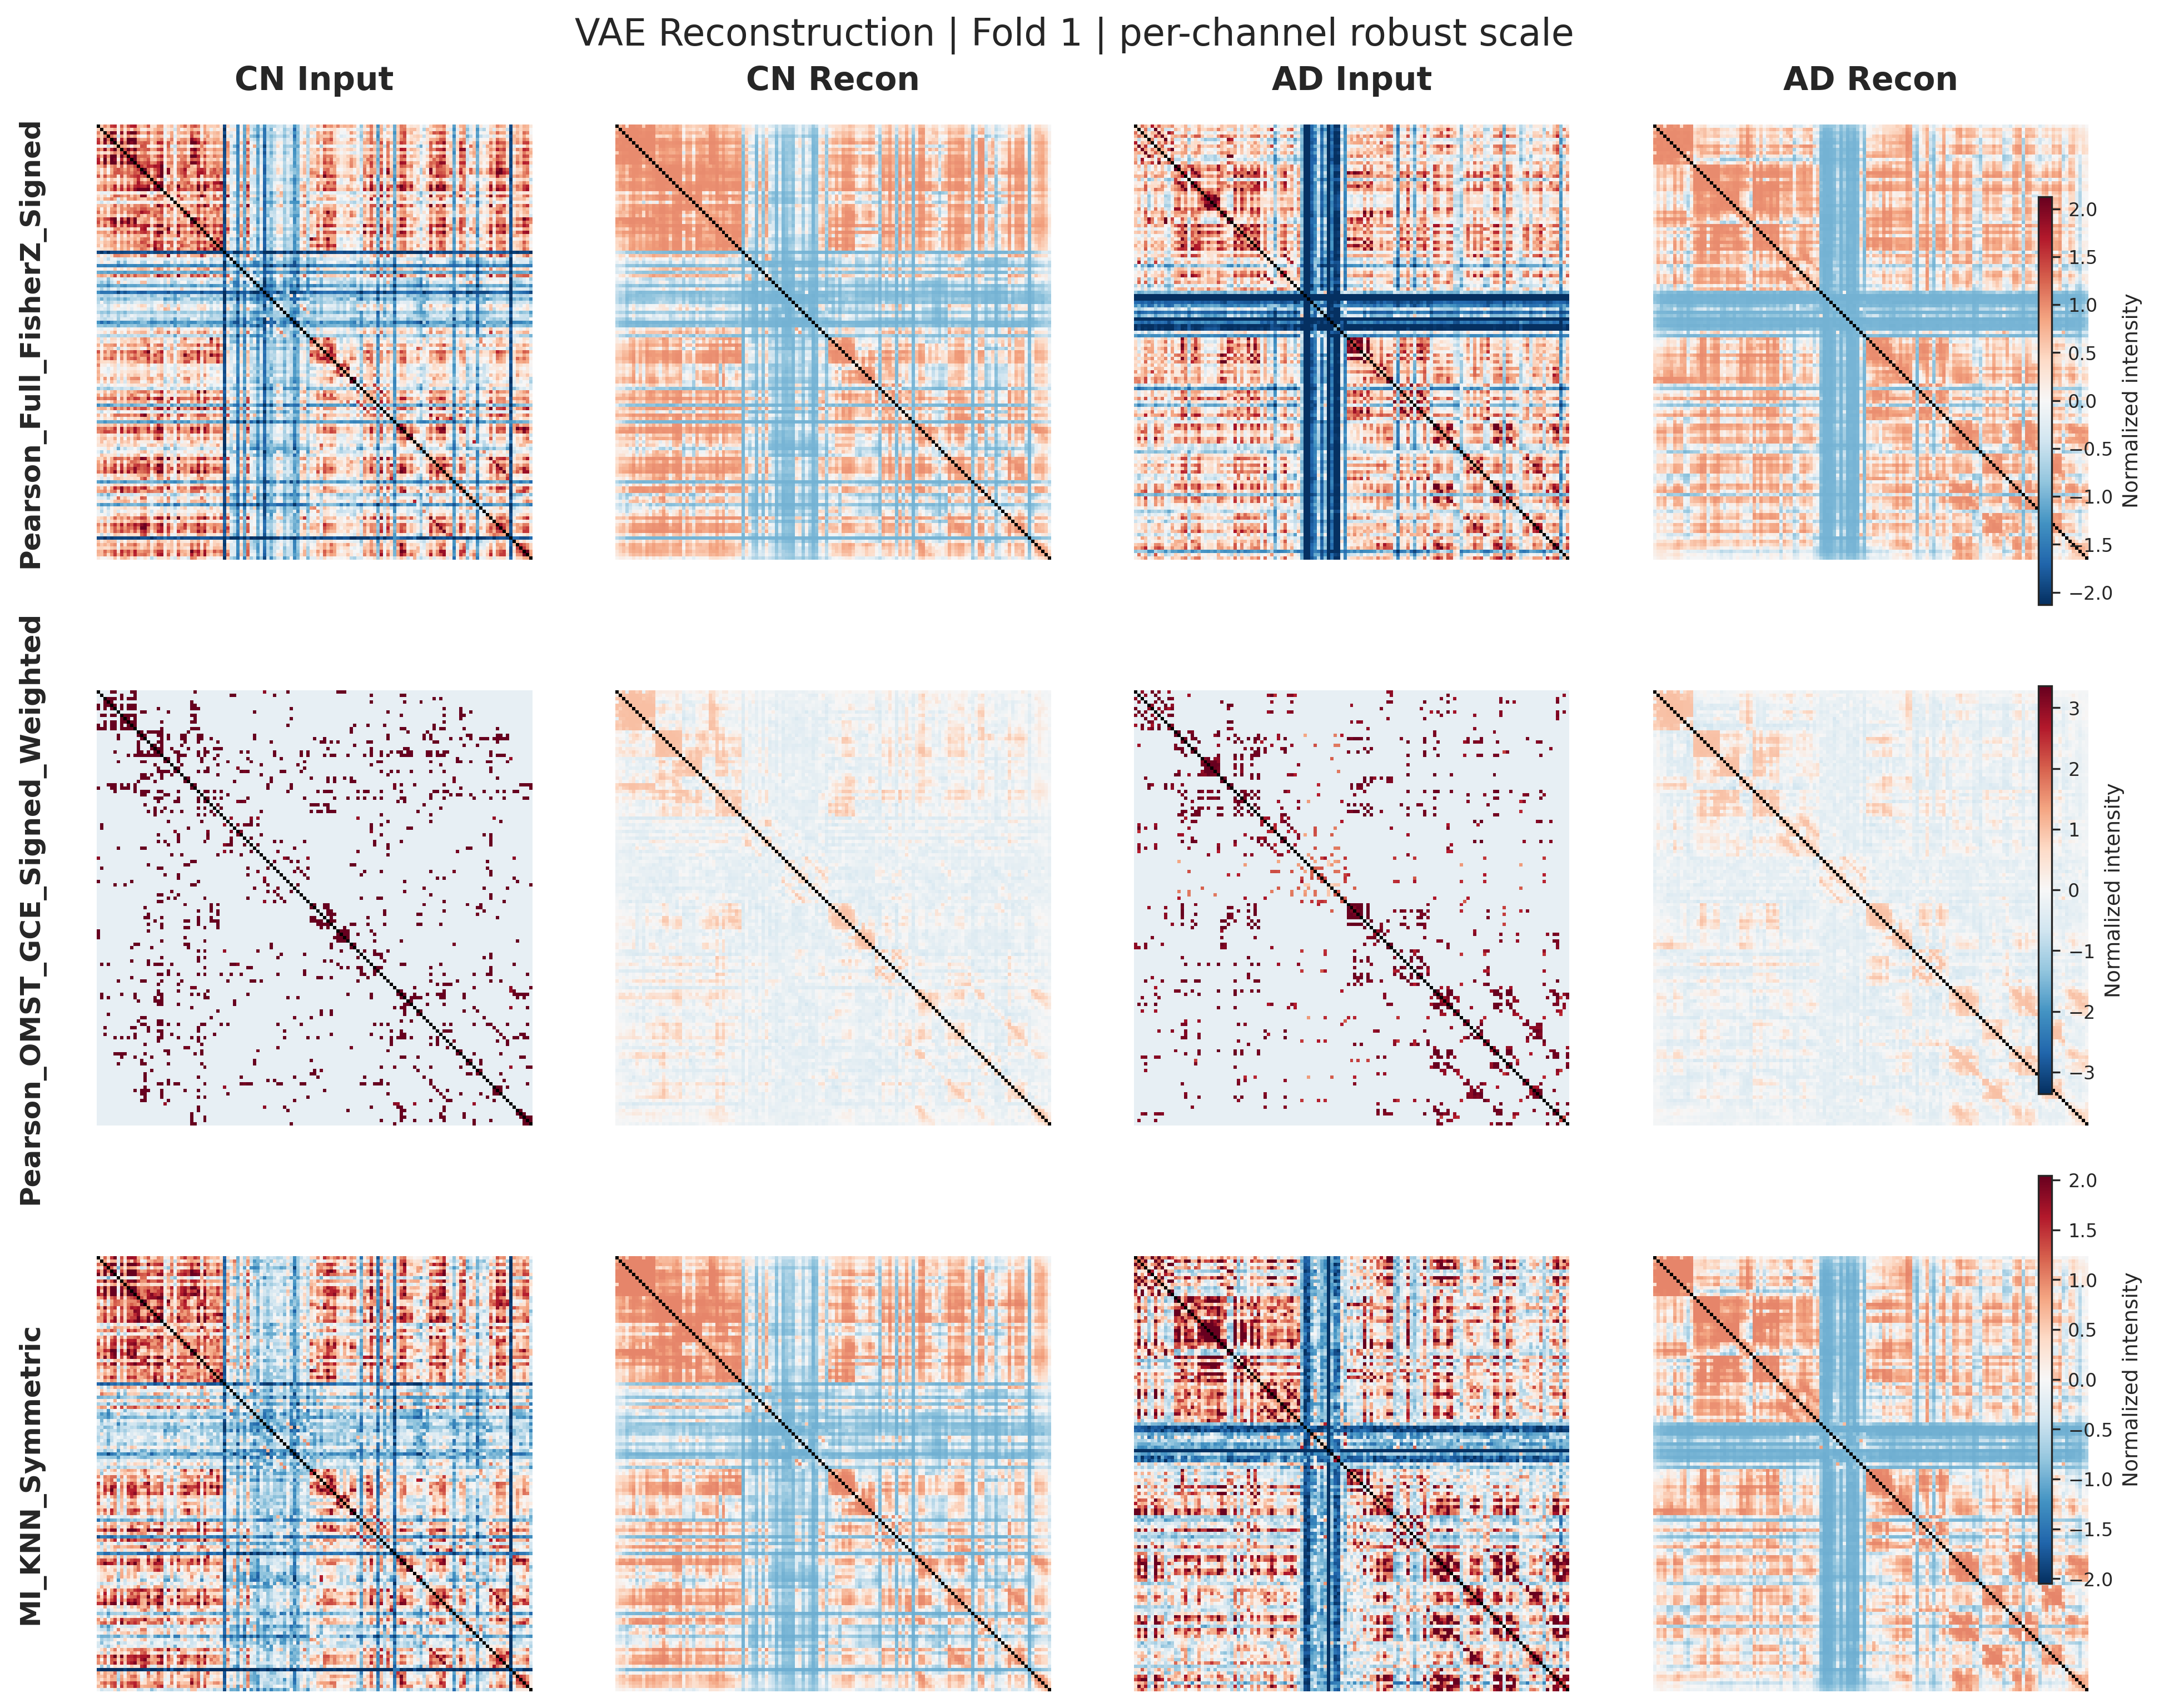

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_reconstruction_fold1_CN_vs_AD.pdf/.png


In [13]:
# ===================== CELDA 6: INPUT vs RECONSTRUCCIÓN (Robusta y consistente con run_args) =====================
import sys
import torch
 
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import copy

# --- 1) Imports del repo ---
project_root = Path.cwd().resolve().parent
src_dir = project_root / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

try:
    from betavae_xai.models.convolutional_vae import ConvolutionalVAE
except ImportError:
    from src.betavae_xai.models.convolutional_vae import ConvolutionalVAE

# --- 2) Parámetros ---
FOLD_TO_VIS = 1
fold_dir = RESULTS_DIR / f"fold_{FOLD_TO_VIS}"
print(f"[INFO] Visualizando fold {FOLD_TO_VIS} en {fold_dir}")

# run_args debe venir de la CELDA 1c
if "run_args" not in globals():
    raise ValueError("⚠️ Falta run_args. Ejecutá la CELDA 1c.")

CH_IDXS = list(run_args["channels_to_use"])

# Nombres “humanos” (ajustá si tu orden/definición difiere)
# Nota: estos names son sólo para rotular la figura.
CHANNEL_NAME_MAP = {
    0: "Pearson_OMST_GCE_Signed_Weighted",
    1: "Pearson_Full_FisherZ_Signed",
    2: "MI_KNN_Symmetric",
    3: "dFC_AbsDiffMean",
    4: "dFC_StdDev",
    5: "DistanceCorr",
    6: "Granger_F_lag1",
}
CH_NAMES = [CHANNEL_NAME_MAP.get(i, f"Channel_{i}") for i in CH_IDXS]

# --- 3) Cargar params de normalización del fold ---
norm_params_path = fold_dir / "vae_norm_params.joblib"
if not norm_params_path.exists():
    raise FileNotFoundError(f"Faltan params normalización: {norm_params_path}")
norm_params_list = joblib.load(norm_params_path)

# --- 4) Cargar tensor global si no está cargado ---
if "data_npz" not in globals() or "global_tensor_data" not in globals():
    # Si venís “limpio”, cargamos desde GLOBAL_TENSOR_PATH si existe en el entorno
    if "GLOBAL_TENSOR_PATH" not in globals():
        raise ValueError("⚠️ No está definido GLOBAL_TENSOR_PATH y no encuentro global_tensor_data.")
    data_npz = np.load(GLOBAL_TENSOR_PATH, allow_pickle=True)
    global_tensor_data = data_npz["global_tensor_data"]

# Subtensor del run
global_t = global_tensor_data[:, CH_IDXS, :, :]
print(f"[OK] global_t cargado. Shape: {global_t.shape}")

# --- 5) Selección de 1 sujeto CN y 1 sujeto AD (si metadata alineada existe) ---
def pick_example_indices():
    if "metadata_df_full" in globals() and metadata_df_full is not None and "ResearchGroup_Mapped" in metadata_df_full.columns:
        df = metadata_df_full
        cn = df[df["ResearchGroup_Mapped"] == "CN"]
        ad = df[df["ResearchGroup_Mapped"] == "AD"]
        if len(cn) > 0 and len(ad) > 0:
            i_cn = int(cn["tensor_idx"].iloc[0])
            i_ad = int(ad["tensor_idx"].iloc[0])
            return i_cn, i_ad, "CN", "AD"
    # fallback
    return 10, 100, "EX_A", "EX_B"

idx_a, idx_b, lab_a, lab_b = pick_example_indices()
print(f"[INFO] Ejemplos: {lab_a} idx={idx_a} | {lab_b} idx={idx_b}")

subj_a_raw = global_t[idx_a]
subj_b_raw = global_t[idx_b]

# --- 6) Normalización blindada (off-diag) ---
def apply_norm_inference(tensor_mv, params_list):
    C, H, W = tensor_mv.shape
    normed = tensor_mv.copy()
    mask = ~np.eye(H, dtype=bool)

    for c in range(C):
        p = params_list[c]
        if p.get("no_scale", False):
            continue

        vals = tensor_mv[c]

        mode = p.get("mode", None)
        if mode == "zscore_offdiag":
            std = float(p.get("std", 0.0))
            if std > 1e-9:
                normed[c, mask] = (vals[mask] - float(p.get("mean", 0.0))) / std
            else:
                normed[c, mask] = 0.0

        elif mode == "minmax_offdiag":
            vmin = float(p.get("min", 0.0))
            vmax = float(p.get("max", 1.0))
            rng = vmax - vmin
            if rng > 1e-9:
                normed[c, mask] = (vals[mask] - vmin) / rng
            else:
                normed[c, mask] = 0.0

        else:
            # modo desconocido -> no tocar, pero avisar una vez
            pass

    return normed

subj_a_norm = apply_norm_inference(subj_a_raw, norm_params_list)
subj_b_norm = apply_norm_inference(subj_b_raw, norm_params_list)

# --- 7) Instanciar VAE (consistente con el run) y cargar checkpoint ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = ConvolutionalVAE(
    input_channels=len(CH_IDXS),
    latent_dim=run_args["latent_dim"],
    image_size=subj_a_norm.shape[-1],
    num_conv_layers_encoder=run_args["num_conv_layers_encoder"],
    intermediate_fc_dim_config=run_args["intermediate_fc_dim_vae"],
    dropout_rate=run_args["dropout_rate_vae"],
    use_layernorm_fc=run_args["use_layernorm_vae_fc"],
    decoder_type=run_args["decoder_type"],
    final_activation=run_args["vae_final_activation"],
).to(device)

ckpt_path = fold_dir / f"vae_model_fold_{FOLD_TO_VIS}.pt"
if not ckpt_path.exists():
    # fallback a glob
    cands = list(fold_dir.glob("vae_model_fold_*.pt"))
    if not cands:
        raise FileNotFoundError("No se encontró checkpoint VAE en fold_dir.")
    ckpt_path = cands[0]

print(f"[OK] Cargando checkpoint: {ckpt_path.name}")
vae.load_state_dict(torch.load(ckpt_path, map_location=device))
vae.eval()

# --- 8) Forward ---
x_a = torch.from_numpy(subj_a_norm).float().unsqueeze(0).to(device)
x_b = torch.from_numpy(subj_b_norm).float().unsqueeze(0).to(device)

with torch.no_grad():
    recon_a, _, _, _ = vae(x_a)
    recon_b, _, _, _ = vae(x_b)

x_a_np = x_a.cpu().numpy()[0]
x_b_np = x_b.cpu().numpy()[0]
recon_a_np = recon_a.cpu().numpy()[0]
recon_b_np = recon_b.cpu().numpy()[0]

# --- 9) Plot ---
def plot_matrix(ax, mat, vmin, vmax):
    mat_masked = mat.copy()
    np.fill_diagonal(mat_masked, np.nan)
    cmap = copy.copy(plt.cm.RdBu_r)
    cmap.set_bad(color="black")
    im = ax.imshow(mat_masked, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis("off")
    return im

n_channels = x_a_np.shape[0]
fig, axes = plt.subplots(n_channels, 4, figsize=(16, 3.6 * n_channels))
cols = [f"{lab_a} Input", f"{lab_a} Recon", f"{lab_b} Input", f"{lab_b} Recon"]

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=14, fontweight="bold", pad=15)

for i in range(n_channels):
    flat_vals = np.concatenate([x_a_np[i].ravel(), recon_a_np[i].ravel(), x_b_np[i].ravel(), recon_b_np[i].ravel()])
    flat_vals = flat_vals[np.isfinite(flat_vals)]
    vmax = np.percentile(np.abs(flat_vals), 98)
    vmin = -vmax

    plot_matrix(axes[i, 0], x_a_np[i], vmin, vmax)
    plot_matrix(axes[i, 1], recon_a_np[i], vmin, vmax)
    plot_matrix(axes[i, 2], x_b_np[i], vmin, vmax)
    im = plot_matrix(axes[i, 3], recon_b_np[i], vmin, vmax)

    axes[i, 0].text(
        -0.12, 0.5, CH_NAMES[i],
        transform=axes[i, 0].transAxes,
        fontsize=12, fontweight="bold", rotation=90,
        va="center", ha="right"
    )

    cbar = fig.colorbar(im, ax=axes[i, :], location="right", fraction=0.05, pad=0.03, aspect=30)
    cbar.set_label("Normalized intensity", fontsize=9)
    cbar.ax.tick_params(labelsize=8)

plt.suptitle(f"VAE Reconstruction | Fold {FOLD_TO_VIS} | per-channel robust scale", fontsize=16, y=0.98)
plt.subplots_adjust(wspace=0.1, hspace=0.3, top=0.92, bottom=0.05, left=0.12, right=0.88)

out_base = OUTPUT_FIG_DIR / f"figure_reconstruction_fold{FOLD_TO_VIS}_{lab_a}_vs_{lab_b}"
plt.savefig(f"{out_base}.pdf", bbox_inches="tight")
plt.savefig(f"{out_base}.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"[OK] Guardado: {out_base}.pdf/.png")


In [14]:
import joblib
import pandas as pd
from pathlib import Path

# Ideal: usar el pred_joblib_path ya resuelto por RUN_TAG (tu celda "Helper: resolver artefactos")
# Si no existe esa variable, cae a glob:
if "pred_joblib_path" not in globals():
    pred_joblib_path = next(RESULTS_DIR.glob("all_folds_clf_predictions_MULTI_*.joblib"))

obj = joblib.load(pred_joblib_path)

print("[INFO] joblib =", pred_joblib_path.name)
print("[INFO] type(obj) =", type(obj))

if isinstance(obj, pd.DataFrame):
    print("[INFO] DataFrame shape:", obj.shape)
    print("[INFO] columns:", list(obj.columns))
elif isinstance(obj, dict):
    print("[INFO] dict keys:", list(obj.keys()))
elif isinstance(obj, list):
    print("[INFO] list len:", len(obj))
    if len(obj) > 0:
        print("[INFO] type(obj[0]) =", type(obj[0]))
        if isinstance(obj[0], pd.DataFrame):
            print("[INFO] obj[0] columns:", list(obj[0].columns))
        elif isinstance(obj[0], dict):
            print("[INFO] obj[0] keys:", list(obj[0].keys()))


[INFO] joblib = all_folds_clf_predictions_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.joblib
[INFO] type(obj) = <class 'list'>
[INFO] list len: 10
[INFO] type(obj[0]) = <class 'pandas.core.frame.DataFrame'>
[INFO] obj[0] columns: ['fold', 'classifier_type', 'SubjectID', 'tensor_idx', 'y_true', 'y_score_raw', 'y_score_cal', 'y_score_final', 'y_pred', 'did_calibrate']


In [15]:
import joblib, pandas as pd
from pathlib import Path

pred_joblib_path = Path(pred_joblib_path)  # ya lo resolvés por RUN_TAG
obj = joblib.load(pred_joblib_path)

# Tu caso: lista de DataFrames
df_all = pd.concat(obj, ignore_index=True)

# Filtrar clasificador objetivo
mask = df_all["classifier_type"].astype(str).str.lower() == TARGET_CLF.lower()
preds_df = df_all.loc[mask].copy()

print(preds_df.shape)
print(preds_df["fold"].value_counts().sort_index())
print(preds_df.columns.tolist())


(183, 10)
fold
1    37
2    37
3    37
4    36
5    36
Name: count, dtype: int64
['fold', 'classifier_type', 'SubjectID', 'tensor_idx', 'y_true', 'y_score_raw', 'y_score_cal', 'y_score_final', 'y_pred', 'did_calibrate']


[OK] preds_df pooled cargado: N=183
[INFO] Columnas disponibles: ['fold', 'classifier_type', 'SubjectID', 'tensor_idx', 'y_true', 'y_score_raw', 'y_score_cal', 'y_score_final', 'y_pred', 'did_calibrate']
score_col = y_score_final
[INFO] y_true col='y_true' | score col='y_score_final'
[INFO] Prevalencia global (positiva=1): 51.4%


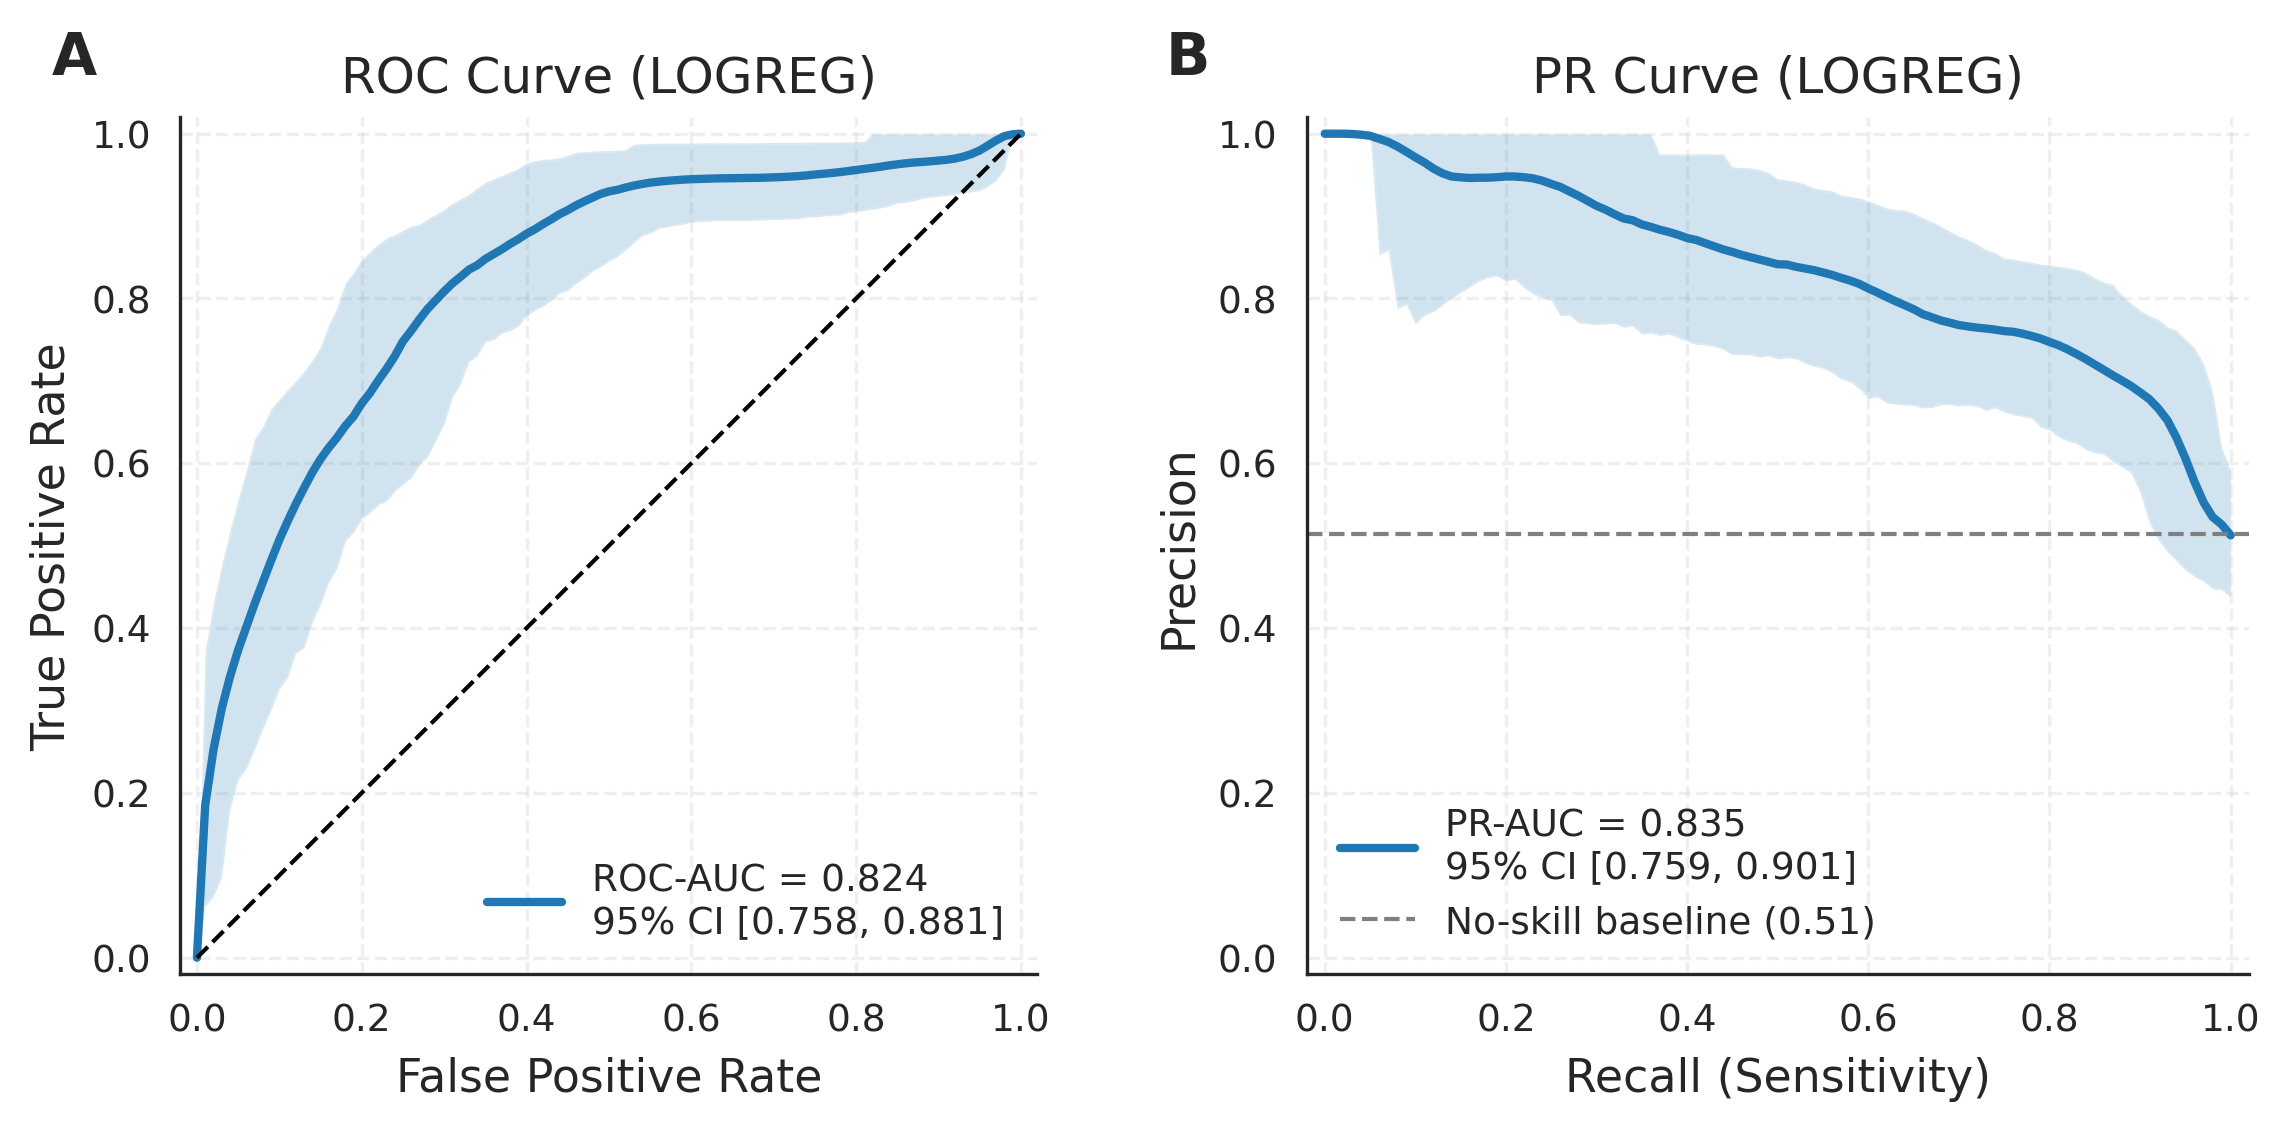

[OK] Figura guardada en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_performance_curves_publication_logreg.pdf/.png/.svg


In [16]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)

# ---------------------------------------------------------------------
# Loader robusto para el .joblib (maneja varios formatos)
# ---------------------------------------------------------------------
def _first_existing(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def _normalize_str_series(s):
    return s.astype(str).str.strip().str.lower()

def load_pooled_predictions(results_dir: Path, target_clf: str, n_folds: int = 5, joblib_path: Path | None = None) -> pd.DataFrame:
    import pandas as pd

    # 0) Elegir joblib correcto (preferir el ya resuelto por RUN_TAG si existe)
    if joblib_path is None:
        if "pred_joblib_path" in globals() and Path(pred_joblib_path).exists():
            joblib_path = Path(pred_joblib_path)
        else:
            joblib_path = next(results_dir.glob("all_folds_clf_predictions_MULTI_*.joblib"))

    obj = joblib.load(joblib_path)

    # 1) Coerción a DataFrame pooled
    df = None

    # Caso A: ya es DataFrame
    if isinstance(obj, pd.DataFrame):
        df = obj.copy()

    # Caso B: lista
    elif isinstance(obj, list):
        if len(obj) == 0:
            df = None
        elif all(isinstance(x, pd.DataFrame) for x in obj):
            # puede ser: [df_fold1, df_fold2, ...] o [df_svm, df_logreg]
            df = pd.concat(obj, ignore_index=True)
        elif all(isinstance(x, dict) for x in obj):
            # puede ser: [{'classifier': 'svm', 'predictions_df': df1}, ...]
            dfs = []
            for d in obj:
                # encontrar df
                ddf = None
                for k in ["predictions_df", "preds_df", "df", "predictions", "preds"]:
                    if k in d and isinstance(d[k], pd.DataFrame):
                        ddf = d[k].copy()
                        break
                if ddf is None:
                    continue

                # intentar leer nombre de clasificador
                clf_name = d.get("classifier") or d.get("classifier_type") or d.get("actual_classifier_type") or d.get("clf")
                if clf_name is None:
                    # si no hay nombre, igual lo agregamos y luego filtramos por columna si existe
                    dfs.append(ddf)
                else:
                    if str(clf_name).strip().lower() == str(target_clf).strip().lower():
                        dfs.append(ddf)

            if dfs:
                df = pd.concat(dfs, ignore_index=True)
            else:
                # si no pudimos filtrar por dict, concatenamos todo
                df_all = []
                for d in obj:
                    for k in ["predictions_df", "preds_df", "df", "predictions", "preds"]:
                        if k in d and isinstance(d[k], pd.DataFrame):
                            df_all.append(d[k].copy())
                            break
                df = pd.concat(df_all, ignore_index=True) if df_all else None

    # Caso C: dict
    elif isinstance(obj, dict):
        # patrones comunes
        for k in ["predictions_df", "preds_df", "df", "predictions", "all_predictions"]:
            if k in obj and isinstance(obj[k], pd.DataFrame):
                df = obj[k].copy()
                break

        # dict-of-dfs por clasificador
        if df is None:
            for k in ["predictions_by_classifier", "preds_by_classifier", "by_classifier"]:
                if k in obj and isinstance(obj[k], dict):
                    d = obj[k]
                    # match case-insensitive
                    for kk, vv in d.items():
                        if str(kk).strip().lower() == str(target_clf).strip().lower() and isinstance(vv, pd.DataFrame):
                            df = vv.copy()
                            break
                    if df is None and len(d) > 0:
                        # fallback: primer df
                        vv0 = next(iter(d.values()))
                        if isinstance(vv0, pd.DataFrame):
                            df = vv0.copy()
                    break

    # 2) Fallback extremo: leer CSV por fold (si el joblib vino raro)
    if df is None or len(df) == 0:
        dfs = []
        for k in range(1, n_folds + 1):
            p = results_dir / f"fold_{k}" / f"test_predictions_{target_clf}.csv"
            if p.exists():
                d = pd.read_csv(p)
                d["fold"] = k if "fold" not in d.columns else d["fold"]
                dfs.append(d)
        if not dfs:
            raise FileNotFoundError(
                "No pude construir preds_df ni desde el joblib ni desde CSVs por fold. "
                f"Revisá {results_dir}."
            )
        df = pd.concat(dfs, ignore_index=True)

    # 3) Si hay una columna de clasificador dentro del DF, filtramos ahí (más confiable)
    clf_col = _first_existing(df.columns, [
        "classifier", "classifier_type", "actual_classifier_type", "clf", "model", "estimator"
    ])
    if clf_col is not None:
        mask = _normalize_str_series(df[clf_col]) == str(target_clf).strip().lower()
        if mask.any():
            df = df.loc[mask].copy()

    df = df.reset_index(drop=True)
    return df


# ---------------------------------------------------------------------
# 1) Cargar pooled preds
# ---------------------------------------------------------------------
preds_df = load_pooled_predictions(RESULTS_DIR, TARGET_CLF, n_folds=N_FOLDS)

print(f"[OK] preds_df pooled cargado: N={len(preds_df)}")
print("[INFO] Columnas disponibles:", list(preds_df.columns))

# ---------------------------------------------------------------------
# 2) Detectar columnas y_true / score robustamente
# ---------------------------------------------------------------------
y_col = _first_existing(preds_df.columns, ["y_true", "y", "label", "target", "y_test"])
if y_col is None:
    raise KeyError(f"No encontré columna de ground-truth (y_true/label/target). Disponibles: {list(preds_df.columns)}")

# score/proba: preferimos prob de clase positiva
#score_col = _first_existing(preds_df.columns, [
#    "y_score", "y_prob", "y_proba", "proba", "prob", "score", "decision", "logit"
#])

score_col = "y_score_final" if "y_score_final" in preds_df.columns else "y_score_raw"
y_true = preds_df["y_true"].astype(int).to_numpy()
y_score = preds_df[score_col].astype(float).to_numpy()

print("score_col =", score_col)


# si hay proba por clase, usar la de clase positiva (1)
if score_col is None:
    for cand in ["proba_1", "p1", "prob_1", "y_score_1", "y_proba_1"]:
        if cand in preds_df.columns:
            score_col = cand
            break

if score_col is None:
    # heurística: elegir la primera columna float en [0,1] que parezca probabilidad
    num_cols = [c for c in preds_df.columns if pd.api.types.is_numeric_dtype(preds_df[c])]
    probish = []
    for c in num_cols:
        v = preds_df[c].to_numpy()
        v = v[np.isfinite(v)]
        if v.size == 0:
            continue
        if (v.min() >= -1e-6) and (v.max() <= 1 + 1e-6):
            name = str(c).lower()
            if any(t in name for t in ["prob", "proba", "score"]):
                probish.append(c)
    if probish:
        score_col = probish[0]

if score_col is None:
    raise KeyError(f"No encontré columna de score/probabilidad. Disponibles: {list(preds_df.columns)}")

y_true = preds_df[y_col].values
y_score = preds_df[score_col].values

# Si y_true vino como strings (AD/CN), mapear a 0/1
if y_true.dtype.kind not in "biufc":
    y_true_s = pd.Series(y_true).astype(str).str.strip().str.upper()
    # regla típica: AD=1, CN=0
    mapping = {"AD": 1, "CN": 0, "1": 1, "0": 0}
    y_true = y_true_s.map(mapping).values
    if np.any(pd.isna(y_true)):
        raise ValueError(f"y_true no numérico y no pude mapearlo. Ejemplos: {y_true_s.unique()[:10]}")

y_true = y_true.astype(int)

print(f"[INFO] y_true col='{y_col}' | score col='{score_col}'")
print(f"[INFO] Prevalencia global (positiva=1): {y_true.mean():.1%}")

# ---------------------------------------------------------------------
# 3) Bootstrap ROC y PR (CORREGIDO: precision_recall_curve order)
# ---------------------------------------------------------------------
rng = np.random.default_rng(42)
B = 2000

# ROC
fpr_grid = np.linspace(0, 1, 101)
tprs, aucs_roc = [], []

for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2:
        continue
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_score[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs_roc.append(roc_auc_score(y_true[idx], y_score[idx]))

tprs = np.array(tprs)
tpr_mean = tprs.mean(0)
tpr_low = np.percentile(tprs, 2.5, 0)
tpr_high = np.percentile(tprs, 97.5, 0)
auc_roc_low, auc_roc_high = np.percentile(aucs_roc, [2.5, 97.5])

# PR (precision, recall, thresholds)
recall_grid = np.linspace(0, 1, 101)
precs, aucs_pr = [], []

for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2:
        continue

    prec_i, rec_i, _ = precision_recall_curve(y_true[idx], y_score[idx])
    # rec_i suele venir decreciente (1 -> 0), invertimos para interpolar en recall creciente
    p_interp = np.interp(recall_grid, rec_i[::-1], prec_i[::-1])
    precs.append(p_interp)
    aucs_pr.append(average_precision_score(y_true[idx], y_score[idx]))

precs = np.array(precs)
prec_mean = precs.mean(0)
prec_low = np.percentile(precs, 2.5, 0)
prec_high = np.percentile(precs, 97.5, 0)
auc_pr_low, auc_pr_high = np.percentile(aucs_pr, [2.5, 97.5])

# ---------------------------------------------------------------------
# 4) Figura publicación
# ---------------------------------------------------------------------
plt.style.use('default')
sns.set_style("white")

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

auc_pooled_roc = roc_auc_score(y_true, y_score)
auc_pooled_pr = average_precision_score(y_true, y_score)

roc_label = (f'ROC-AUC = {auc_pooled_roc:.3f}\n'
             f'95% CI [{auc_roc_low:.3f}, {auc_roc_high:.3f}]')

pr_label = (f'PR-AUC = {auc_pooled_pr:.3f}\n'
            f'95% CI [{auc_pr_low:.3f}, {auc_pr_high:.3f}]')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# ROC
ax1.plot(fpr_grid, tpr_mean, lw=2, label=roc_label)
ax1.fill_between(fpr_grid, tpr_low, tpr_high, alpha=0.2)
ax1.set_aspect('equal', 'box')
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='False Positive Rate', ylabel='True Positive Rate',
        title=f'ROC Curve ({TARGET_CLF.upper()})')
ax1.legend(loc="lower right", frameon=False)
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold')

# PR
baseline = float(np.mean(y_true))
ax2.plot(recall_grid, prec_mean, lw=2, label=pr_label)
ax2.fill_between(recall_grid, prec_low, prec_high, alpha=0.2)
ax2.axhline(baseline, color='grey', linestyle='--', lw=1, label=f'No-skill baseline ({baseline:.2f})')
ax2.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='Recall (Sensitivity)', ylabel='Precision',
        title=f'PR Curve ({TARGET_CLF.upper()})')
ax2.legend(loc="lower left", frameon=False)
ax2.grid(True, linestyle="--", alpha=0.3)
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold')

fig.tight_layout(pad=1.5)
fig_path_base = OUTPUT_FIG_DIR / f"figure_performance_curves_publication_{TARGET_CLF}"

plt.savefig(f"{fig_path_base}.pdf", bbox_inches='tight')
plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{fig_path_base}.svg", bbox_inches='tight')
plt.show()

print(f"[OK] Figura guardada en: {fig_path_base}.pdf/.png/.svg")


In [17]:
# ===================== CELDA 7.5 (PAPER-GRADE): OPERATING POINTS SIN SESGO (threshold transfer OOF) =====================
from sklearn.metrics import roc_curve, confusion_matrix
 
import pandas as pd
import joblib

TARGET_SENS = 0.85
C_FN = 3.0
C_FP = 1.0


def _safe_confusion_metrics(y_true, y_score, thr):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (np.asarray(y_score, dtype=float) >= float(thr)).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv  = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv  = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    return {
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "sens": float(sens), "spec": float(spec), "ppv": float(ppv), "npv": float(npv),
    }


def _threshold_from_train(y_train, s_train, mode="youden", target_sens=0.85, c_fn=3.0, c_fp=1.0):
    y_train = np.asarray(y_train).astype(int)
    s_train = np.asarray(s_train, dtype=float)

    fpr, tpr, thr = roc_curve(y_train, s_train)
    finite = np.isfinite(thr)

    if mode == "youden":
        j = tpr - fpr
        idx = int(np.nanargmax(j))
        return float(thr[idx])

    if mode == "screening":
        idxs = np.where((tpr >= target_sens) & finite)[0]
        if len(idxs) == 0:
            return 0.5
        return float(thr[int(idxs[0])])

    if mode == "cost":
        thr_use = thr[finite]
        if thr_use.size == 0:
            return 0.5
        costs = []
        for t in thr_use:
            m = _safe_confusion_metrics(y_train, s_train, t)
            cost = (c_fn * m["fn"] + c_fp * m["fp"]) / len(y_train)
            costs.append(cost)
        return float(thr_use[int(np.argmin(costs))])

    raise ValueError(f"Modo no soportado: {mode}")


# 1) Cargar predicciones por fold (robusto al formato real del joblib)
pred_joblib_path = next(RESULTS_DIR.glob("all_folds_clf_predictions_MULTI_*.joblib"))
all_preds_data = joblib.load(pred_joblib_path)

def _norm_str(x):
    return str(x).strip().lower()

def _pick_score_col(cols):
    # preferimos el score final (post-calibración si existe)
    for c in ["y_score_final", "y_score_cal", "y_score_raw", "y_score"]:
        if c in cols:
            return c
    return None

# normalizamos a un único DataFrame pooled
if isinstance(all_preds_data, pd.DataFrame):
    pooled = all_preds_data.copy()
elif isinstance(all_preds_data, list):
    if len(all_preds_data) == 0:
        pooled = None
    elif all(isinstance(x, pd.DataFrame) for x in all_preds_data):
        pooled = pd.concat(all_preds_data, ignore_index=True)
    elif all(isinstance(x, dict) for x in all_preds_data):
        dfs = []
        for d in all_preds_data:
            dfp = None
            for k in ["predictions_df", "preds_df", "df", "predictions", "preds"]:
                if k in d and isinstance(d[k], pd.DataFrame):
                    dfp = d[k].copy()
                    break
            if dfp is None:
                continue
            # intentar anotar classifier si viene fuera del DF
            clf_name = d.get("classifier") or d.get("classifier_type") or d.get("actual_classifier_type") or d.get("clf")
            if clf_name is not None and "classifier_type" not in dfp.columns:
                dfp["classifier_type"] = str(clf_name)
            # intentar anotar fold si viene fuera del DF
            f_id = d.get("fold", None)
            if f_id is not None and "fold" not in dfp.columns:
                dfp["fold"] = int(f_id)
            dfs.append(dfp)
        pooled = pd.concat(dfs, ignore_index=True) if dfs else None
    else:
        pooled = None
else:
    pooled = None

if pooled is None or len(pooled) == 0:
    raise FileNotFoundError("No pude construir un DataFrame pooled desde el joblib de predicciones.")

# filtrar clasificador objetivo si hay columna
if "classifier_type" in pooled.columns:
    mask = pooled["classifier_type"].map(_norm_str) == _norm_str(TARGET_CLF)
    if mask.any():
        pooled = pooled.loc[mask].copy()

# asegurar fold int
if "fold" not in pooled.columns:
    raise KeyError("El pooled preds DF no tiene columna 'fold'.")
pooled["fold"] = pooled["fold"].astype(int)

score_col = _pick_score_col(pooled.columns)
if score_col is None:
    raise KeyError(f"No encontré columna de score. Disponibles: {list(pooled.columns)}")

# armar dict por fold con columnas estándar y_score / y_true
fold_predictions = {}
for f_id, g in pooled.groupby("fold"):
    dfp = g.copy()
    # estandarizar columna de score a 'y_score'
    if score_col != "y_score":
        dfp["y_score"] = dfp[score_col].astype(float)
    fold_predictions[int(f_id)] = dfp

if len(fold_predictions) < 2:
    raise ValueError(
        f"Se requieren al menos 2 folds para evaluación OOF de umbral. "
        f"Encontré folds={sorted(fold_predictions.keys())} en {pred_joblib_path.name}"
    )

print(f"[OK] Folds disponibles para '{TARGET_CLF}' (score_col='{score_col}'): {sorted(fold_predictions.keys())}")
  

modes = ["youden", "screening", "cost"]
rows_thr = []
rows_eval = []

# 2) Leave-one-fold-out threshold transfer
for f_test in sorted(fold_predictions.keys()):
    df_test = fold_predictions[f_test]
    train_parts = [df for k, df in fold_predictions.items() if k != f_test]
    df_train = pd.concat(train_parts, ignore_index=True)

    y_tr = df_train["y_true"].to_numpy().astype(int)
    s_tr = df_train["y_score"].to_numpy().astype(float)
    y_te = df_test["y_true"].to_numpy().astype(int)
    s_te = df_test["y_score"].to_numpy().astype(float)

    for mode in modes:
        thr = _threshold_from_train(y_tr, s_tr, mode=mode, target_sens=TARGET_SENS, c_fn=C_FN, c_fp=C_FP)
        m = _safe_confusion_metrics(y_te, s_te, thr)

        rows_thr.append({
            "fold_test": int(f_test),
            "mode": mode,
            "threshold_from_train": float(thr),
            "n_train": int(len(df_train)),
            "n_test": int(len(df_test)),
        })

        rows_eval.append({
            "fold_test": int(f_test),
            "mode": mode,
            "threshold": float(thr),
            **m,
        })

unbiased_fold_thresholds_df = pd.DataFrame(rows_thr).sort_values(["mode", "fold_test"]).reset_index(drop=True)
unbiased_fold_metrics_df = pd.DataFrame(rows_eval).sort_values(["mode", "fold_test"]).reset_index(drop=True)

print()
print("--- Thresholds aprendidos en TRAIN (aplicados en fold TEST) ---")
display(unbiased_fold_thresholds_df.round(4))

print()
print("--- Métricas por fold (evaluación OOF sin sesgo de umbral) ---")
display(unbiased_fold_metrics_df[["fold_test", "mode", "threshold", "sens", "spec", "ppv", "npv", "tp", "fn", "tn", "fp"]].round(4))

# 3) Agregado global (suma de confusion matrices OOF)
summary_rows = []
unbiased_cm_counts_by_mode = {}
for mode, g in unbiased_fold_metrics_df.groupby("mode"):
    tp = int(g["tp"].sum())
    fn = int(g["fn"].sum())
    tn = int(g["tn"].sum())
    fp = int(g["fp"].sum())

    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv  = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv  = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    unbiased_cm_counts_by_mode[mode] = {"tn": tn, "fp": fp, "fn": fn, "tp": tp}

    summary_rows.append({
        "mode": mode,
        "n_folds": int(g["fold_test"].nunique()),
        "threshold_mean": float(g["threshold"].mean()),
        "threshold_sd": float(g["threshold"].std(ddof=1)) if len(g) > 1 else 0.0,
        "sens_oof": float(sens),
        "spec_oof": float(spec),
        "ppv_oof": float(ppv),
        "npv_oof": float(npv),
        "tp": tp, "fn": fn, "tn": tn, "fp": fp,
    })

unbiased_operating_summary_df = pd.DataFrame(summary_rows).sort_values("mode").reset_index(drop=True)

print()
print("=== OPERATING POINTS OOF (SIN SESGO DE UMBRAL) ===")
display(unbiased_operating_summary_df.round(4))

# 4) Export
unbiased_fold_thresholds_df.to_csv(OUTPUT_FIG_DIR / "table_operating_thresholds_oof_by_fold.csv", index=False)
unbiased_fold_metrics_df.to_csv(OUTPUT_FIG_DIR / "table_operating_metrics_oof_by_fold.csv", index=False)
unbiased_operating_summary_df.to_csv(OUTPUT_FIG_DIR / "table_operating_points_oof_summary.csv", index=False)

print("[OK] Exportadas tablas OOF sin sesgo:")
print("  - table_operating_thresholds_oof_by_fold.csv")
print("  - table_operating_metrics_oof_by_fold.csv")
print("  - table_operating_points_oof_summary.csv")

[OK] Folds disponibles para 'logreg' (score_col='y_score_final'): [1, 2, 3, 4, 5]

--- Thresholds aprendidos en TRAIN (aplicados en fold TEST) ---


fold_test       mode  threshold_from_train  n_train  n_test
0           1       cost                0.4125      146      37
1           2       cost                0.4125      146      37
2           3       cost                0.4125      146      37
3           4       cost                0.4138      147      36
4           5       cost                0.4125      147      36
5           1  screening                0.4938      146      37
6           2  screening                0.4938      146      37
7           3  screening                0.4961      146      37
8           4  screening                0.4600      147      36
9           5  screening                0.4938      147      36
10          1     youden                0.5320      146      37
11          2     youden                0.5241      146      37
12          3     youden                0.5287      146      37
13          4     youden                0.5320      147      36
14          5     youden                0.5334      147      36


--- Métricas por fold (evaluación OOF sin sesgo de umbral) ---


fold_test       mode  threshold    sens    spec     ppv     npv  tp  fn  \
0           1       cost     0.4125  1.0000  0.6667  0.7600  1.0000  19   0   
1           2       cost     0.4125  0.8421  0.5556  0.6667  0.7692  16   3   
2           3       cost     0.4125  0.9474  0.6667  0.7500  0.9231  18   1   
3           4       cost     0.4138  0.9444  0.3333  0.5862  0.8571  17   1   
4           5       cost     0.4125  0.8947  0.4706  0.6538  0.8000  17   2   
5           1  screening     0.4938  0.8421  0.7778  0.8000  0.8235  16   3   
6           2  screening     0.4938  0.8421  0.7222  0.7619  0.8125  16   3   
7           3  screening     0.4961  0.7368  0.7222  0.7368  0.7222  14   5   
8           4  screening     0.4600  0.9444  0.4444  0.6296  0.8889  17   1   
9           5  screening     0.4938  0.8421  0.5882  0.6957  0.7692  16   3   
10          1     youden     0.5320  0.6842  0.8333  0.8125  0.7143  13   6   
11          2     youden     0.5241  0.8421  0.7778  0.8000  0.8235  16   3   
12          3     youden     0.5287  0.7368  0.7778  0.7778  0.7368  14   5   
13          4     youden     0.5320  0.8889  0.5000  0.6400  0.8182  16   2   
14          5     youden     0.5334  0.7368  0.7647  0.7778  0.7222  14   5   

    tn  fp  
0   12   6  
1   10   8  
2   12   6  
3    6  12  
4    8   9  
5   14   4  
6   13   5  
7   13   5  
8    8  10  
9   10   7  
10  15   3  
11  14   4  
12  14   4  
13   9   9  
14  13   4


=== OPERATING POINTS OOF (SIN SESGO DE UMBRAL) ===


mode  n_folds  threshold_mean  threshold_sd  sens_oof  spec_oof  \
0       cost        5          0.4127        0.0006    0.9255    0.5393   
1  screening        5          0.4875        0.0154    0.8404    0.6517   
2     youden        5          0.5300        0.0037    0.7766    0.7303   

   ppv_oof  npv_oof  tp  fn  tn  fp  
0   0.6797   0.8727  87   7  48  41  
1   0.7182   0.7945  79  15  58  31  
2   0.7526   0.7558  73  21  65  24

[OK] Exportadas tablas OOF sin sesgo:
  - table_operating_thresholds_oof_by_fold.csv
  - table_operating_metrics_oof_by_fold.csv
  - table_operating_points_oof_summary.csv


In [18]:
# ===================== CELDA 7.5b (PAPER-GRADE): TABLA SUPPLEMENTARY DESDE OOF =====================
if "unbiased_operating_summary_df" not in globals():
    raise ValueError("Ejecutá primero la CELDA 7.5 (PAPER-GRADE).")

supp_table = unbiased_operating_summary_df.copy()
supp_table = supp_table[["mode", "sens_oof", "spec_oof", "ppv_oof", "npv_oof", "tp", "fn", "tn", "fp", "threshold_mean", "threshold_sd"]]

print("=== Supplementary Table (Operating points OOF) ===")
display(supp_table.round(4))

supp_table.to_csv(OUTPUT_FIG_DIR / "table_operating_points_oof_for_paper.csv", index=False)
with open(OUTPUT_FIG_DIR / "table_operating_points_oof_for_paper.tex", "w") as f:
    f.write(supp_table.round(4).to_latex(index=False, escape=False))

print("[OK] Guardado:")
print("  - table_operating_points_oof_for_paper.csv")
print("  - table_operating_points_oof_for_paper.tex")

=== Supplementary Table (Operating points OOF) ===


mode  sens_oof  spec_oof  ppv_oof  npv_oof  tp  fn  tn  fp  \
0       cost    0.9255    0.5393   0.6797   0.8727  87   7  48  41   
1  screening    0.8404    0.6517   0.7182   0.7945  79  15  58  31   
2     youden    0.7766    0.7303   0.7526   0.7558  73  21  65  24   

   threshold_mean  threshold_sd  
0          0.4127        0.0006  
1          0.4875        0.0154  
2          0.5300        0.0037

[OK] Guardado:
  - table_operating_points_oof_for_paper.csv
  - table_operating_points_oof_for_paper.tex


In [19]:
# ===================== CELDA 7.5c (PAPER-GRADE): MATRICES DE CONFUSIÓN OOF (sin sesgo) =====================
import matplotlib.pyplot as plt
import seaborn as sns
 

if "unbiased_cm_counts_by_mode" not in globals():
    raise ValueError("Ejecutá primero la CELDA 7.5 (PAPER-GRADE).")

modes_plot = [m for m in ["youden", "screening", "cost"] if m in unbiased_cm_counts_by_mode]
if not modes_plot:
    raise ValueError("No hay modos disponibles para graficar.")

fig, axes = plt.subplots(1, len(modes_plot), figsize=(5 * len(modes_plot), 4))
if len(modes_plot) == 1:
    axes = [axes]

for ax, mode in zip(axes, modes_plot):
    c = unbiased_cm_counts_by_mode[mode]
    cm = np.array([[c["tn"], c["fp"]], [c["fn"], c["tp"]]], dtype=int)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=['CN', 'AD'],
        yticklabels=['CN', 'AD'],
        annot_kws={"size": 12, "weight": "bold"},
        ax=ax,
    )

    ax.set_xlabel("Predicted Label", fontsize=10)
    ax.set_ylabel("True Label", fontsize=10)
    ax.set_title(f"Confusion Matrix OOF ({mode})", fontsize=11)

plt.tight_layout()
out_cm_pdf = OUTPUT_FIG_DIR / "figure_confusion_matrix_oof_modes.pdf"
out_cm_png = OUTPUT_FIG_DIR / "figure_confusion_matrix_oof_modes.png"
plt.savefig(out_cm_pdf, bbox_inches='tight')
plt.savefig(out_cm_png, dpi=300, bbox_inches='tight')
plt.show()

print(f"[OK] Guardado: {out_cm_pdf}")
print(f"[OK] Guardado: {out_cm_png}")

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_confusion_matrix_oof_modes.pdf
[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_confusion_matrix_oof_modes.png


Generando curva de calibración (Pooled Test)...


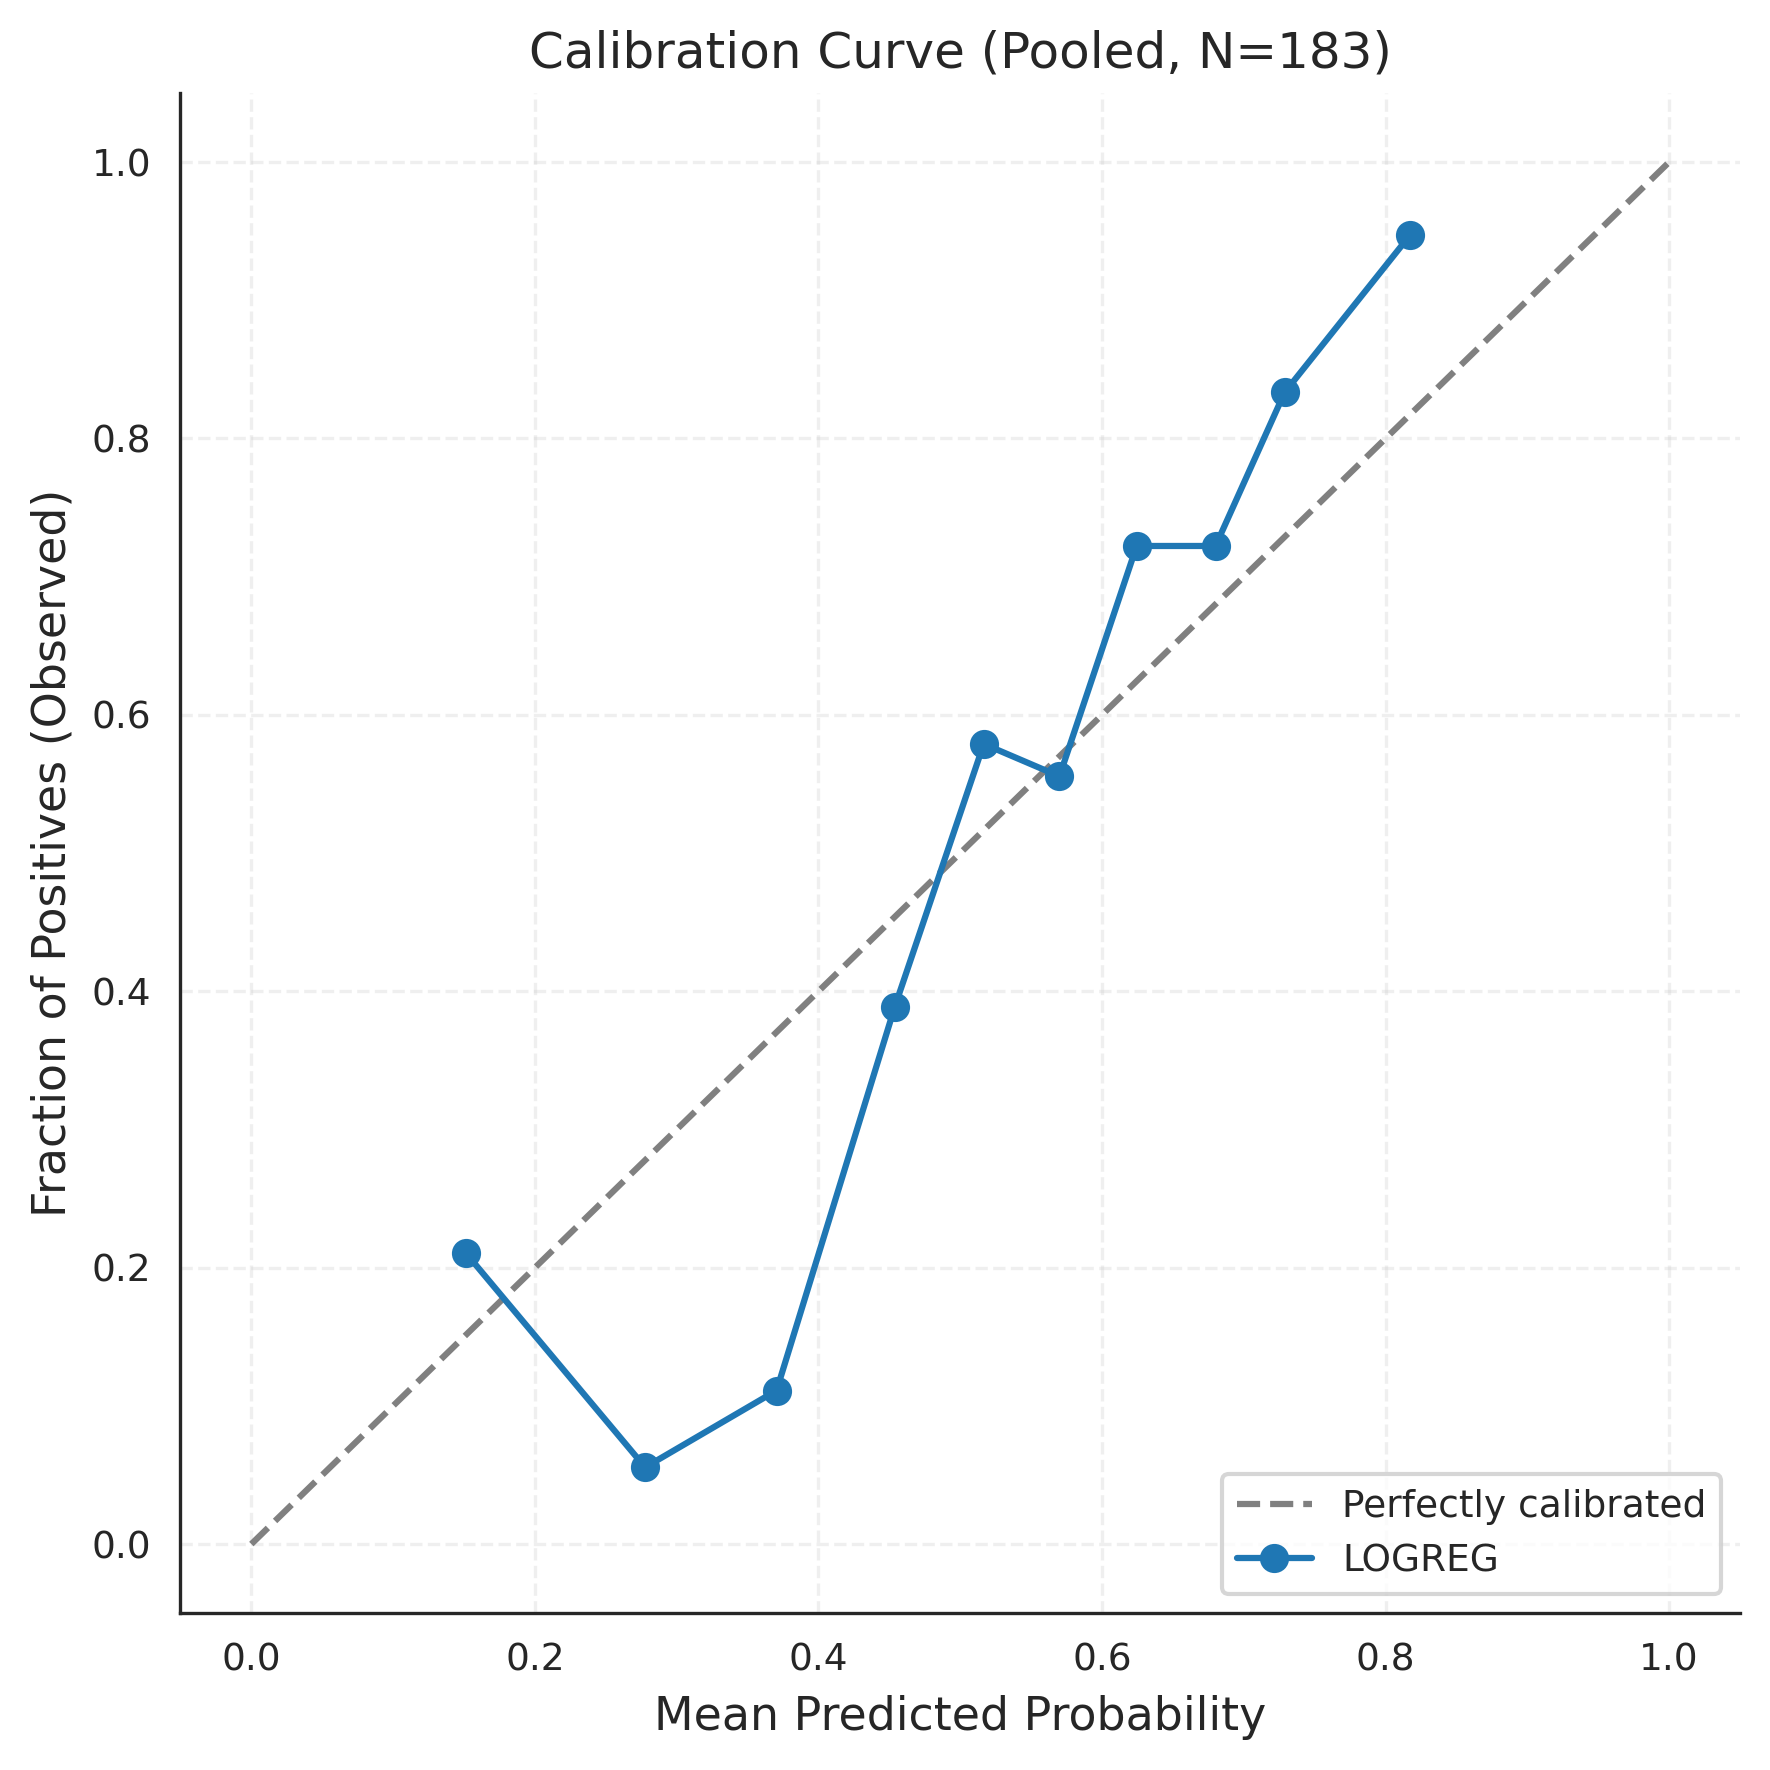

Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_calibration_pooled.pdf


In [20]:
# ===================== CELDA 7.6: CURVA DE CALIBRACIÓN (Para Fig S9) =====================
from sklearn.calibration import calibration_curve

print("Generando curva de calibración (Pooled Test)...")

# Calcular curva de calibración (10 bins es estándar)
prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy='quantile')

fig, ax = plt.subplots(figsize=(6, 6))

# Línea de referencia (Perfectamente calibrado)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Curva del modelo
ax.plot(prob_pred, prob_true, marker='o', linewidth=1.5, color='C0', label=f'{TARGET_CLF.upper()}')

ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives (Observed)")
ax.set_title(f"Calibration Curve (Pooled, N={len(y_true)})")
ax.legend(loc="lower right")
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
out_calib = OUTPUT_FIG_DIR / "figure_calibration_pooled.pdf"
plt.savefig(out_calib, bbox_inches='tight')
plt.show()
print(f"Guardado: {out_calib}")

In [21]:
from sklearn.metrics import brier_score_loss
brier = brier_score_loss(y_true, y_score)
print(f"Pooled Brier Score: {brier:.3f}") 
# Si esto da 0.178, ¡estás blindado!

Pooled Brier Score: 0.180


In [22]:
from pathlib import Path

def find_meta_aligned(results_dir: Path) -> Path | None:
    cands = list(results_dir.rglob("metadata_aligned_to_tensor.csv"))
    if not cands:
        return None
    # elegimos el más reciente
    return max(cands, key=lambda p: p.stat().st_mtime)

RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro")
META_ALIGNED = RESULTS_DIR / "training_qc" / "metadata_aligned_to_tensor.csv"

if not META_ALIGNED.exists():
    alt = find_meta_aligned(Path("/home/diego/proyectos/betavae-xai-ad/results"))
    if alt is None:
        raise FileNotFoundError("No encontré metadata_aligned_to_tensor.csv en /results/. Generarlo con Fix B.")
    print(f"[WARN] No existe {META_ALIGNED}. Usando el encontrado:\n  {alt}")
    META_ALIGNED = alt

print("[INFO] META_ALIGNED =", META_ALIGNED)


[INFO] META_ALIGNED = /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/metadata_aligned_to_tensor.csv


In [23]:
 
import pandas as pd
from pathlib import Path

def build_metadata_aligned_to_tensor(
    global_tensor_npz: Path,
    metadata_csv: Path,
    out_csv: Path,
    id_col_candidates=("SubjectID", "RID", "participant_id", "ID")
):
    out_csv.parent.mkdir(parents=True, exist_ok=True)

    npz = np.load(global_tensor_npz, allow_pickle=True)
    if "subject_ids" not in npz.files:
        raise KeyError(f"NPZ no tiene 'subject_ids'. Keys: {list(npz.files)}")

    tensor_ids = npz["subject_ids"]
    # decode bytes si aplica
    if tensor_ids.dtype.kind == "S":
        tensor_ids = np.array([x.decode("utf-8", errors="ignore") for x in tensor_ids], dtype=object)
    tensor_ids = pd.Series(tensor_ids).astype(str).str.strip()

    meta = pd.read_csv(metadata_csv)

    id_meta = None
    for c in id_col_candidates:
        if c in meta.columns:
            id_meta = c
            break
    if id_meta is None:
        raise KeyError(f"No encontré ID en metadata. Probé: {id_col_candidates}")

    meta = meta.copy()
    meta["_id"] = meta[id_meta].astype(str).str.strip()
    meta_map = meta.set_index("_id", drop=False)

    missing = (~tensor_ids.isin(meta_map.index)).sum()
    if missing != 0:
        raise ValueError(f"No pude alinear: faltan {missing} IDs del tensor en metadata (match por {id_meta}).")

    aligned = meta_map.loc[tensor_ids.values].reset_index(drop=True)
    aligned["tensor_idx"] = np.arange(len(aligned), dtype=int)
    aligned.to_csv(out_csv, index=False)
    print(f"[OK] Guardado aligned metadata ({len(aligned)}) en:\n  {out_csv}")
    return out_csv

# --- USO ---
RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65")
OUTDIR = RESULTS_DIR / "training_qc"
META_ALIGNED = OUTDIR / "metadata_aligned_to_tensor.csv"

GLOBAL_TENSOR_PATH = Path(
    "/home/diego/proyectos/betavae-xai-ad/data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/"
    "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
)
METADATA_PATH = Path("/home/diego/proyectos/betavae-xai-ad/data/SubjectsData_AAL3_procesado2.csv")

build_metadata_aligned_to_tensor(GLOBAL_TENSOR_PATH, METADATA_PATH, META_ALIGNED)


[OK] Guardado aligned metadata (431) en:
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65/training_qc/metadata_aligned_to_tensor.csv


PosixPath('/home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65/training_qc/metadata_aligned_to_tensor.csv')

In [24]:
# ===================== CELDA IT-0: MASTER DF (preds + fold + metadata + confounder consistente) =====================
from pathlib import Path
 
import pandas as pd
import joblib


def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


def normalize_id_series(s):
    return s.astype(str).str.strip()


def detect_confounder_column(metadata_df, prefer_manufacturer=True):
    """Consistente con fold_qc.py: preferir Manufacturer/Vendor; fallback Site/Scanner/Center."""
    if metadata_df is None or metadata_df.empty:
        return None

    pref, other = [], []
    for c in metadata_df.columns:
        cl = str(c).lower()
        if any(k in cl for k in ["manufacturer", "vendor"]):
            pref.append(c)
        elif any(k in cl for k in ["site", "scanner", "center", "centre"]):
            other.append(c)

    def _best(cols):
        best = None
        best_score = None
        for c in cols:
            s = metadata_df[c]
            nn = int(s.notna().sum())
            nu = int(s.nunique(dropna=True))
            if nn == 0 or nu < 2:
                continue
            score = (nn, nu)
            if best is None or score > best_score:
                best, best_score = c, score
        return best

    if prefer_manufacturer and pref:
        b = _best(pref)
        if b is not None:
            return b
    return _best(other if other else pref)


RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65")
META_ALIGNED = RESULTS_DIR / "training_qc" / "metadata_aligned_to_tensor.csv"
TARGET_CLF = "logreg"
MIN_N_DOMAIN = 6

# --- Load predictions joblib ---
pred_joblib_path = next(RESULTS_DIR.glob("all_folds_clf_predictions_MULTI_*.joblib"))
all_preds_data = joblib.load(pred_joblib_path)

pred_dfs = []
for item in all_preds_data:
    if item.get("classifier") != TARGET_CLF:
        continue
    dfp = item["predictions_df"].copy()
    if "fold" not in dfp.columns:
        if "fold" in item:
            dfp["fold"] = int(item["fold"])
        else:
            raise ValueError("No encuentro fold ni en item ni en predictions_df.")
    pred_dfs.append(dfp)

preds_df = pd.concat(pred_dfs, ignore_index=True)
print("[OK] preds_df:", preds_df.shape)

# --- Identify core columns ---
id_pred = pick_col(preds_df, ["SubjectID", "Subject", "participant_id", "RID", "ID"])
y_col   = pick_col(preds_df, ["y_true", "true", "label", "target", "Diagnosis", "ResearchGroup_Mapped"])
p_col   = pick_col(preds_df, ["y_score", "prob", "proba", "p_ad", "score"])

if not all([id_pred, y_col, p_col]):
    raise ValueError(f"Faltan columnas básicas. id_pred={id_pred}, y_col={y_col}, p_col={p_col}")

preds_df[id_pred] = normalize_id_series(preds_df[id_pred])

# --- Load aligned metadata ---
meta = pd.read_csv(META_ALIGNED)
id_meta = pick_col(meta, ["SubjectID", "Subject", "participant_id", "RID", "ID"])
if id_meta is None:
    raise ValueError("No encuentro SubjectID en META_ALIGNED.")
meta[id_meta] = normalize_id_series(meta[id_meta])

# --- Merge ---
keep_meta = [id_meta]
for c in ["ResearchGroup_Mapped", "Site3", "Manufacturer", "ImagingProtocol", "Age", "Sex"]:
    if c in meta.columns and c not in keep_meta:
        keep_meta.append(c)

master_df = preds_df.merge(meta[keep_meta], left_on=id_pred, right_on=id_meta, how="left")

# normalize label into {0,1}
def binarize_y(y):
    if pd.api.types.is_numeric_dtype(y):
        uniq = pd.unique(pd.Series(y).dropna())
        if set(uniq).issubset({0, 1}):
            return pd.Series(y).astype(int)
        return (pd.Series(y) == np.max(uniq)).astype(int)
    ys = pd.Series(y).astype(str).str.upper()
    return ys.str.contains("AD").astype(int)

master_df["_y"] = binarize_y(master_df[y_col])
master_df["_p"] = master_df[p_col].astype(float)

# --- Confounder consistente (paper-grade) ---
CONSISTENT_CONFOUNDER_COL = detect_confounder_column(master_df, prefer_manufacturer=True)
if CONSISTENT_CONFOUNDER_COL is None:
    raise ValueError("No pude detectar confounder consistente (Manufacturer/Vendor o Site/Scanner).")

master_df["_confounder"] = master_df[CONSISTENT_CONFOUNDER_COL].astype(str).fillna("Unknown").str.strip()
vc_conf = master_df["_confounder"].value_counts(dropna=False)
keep_conf = vc_conf[vc_conf >= MIN_N_DOMAIN].index
master_df["_confounder_collapsed"] = master_df["_confounder"].where(master_df["_confounder"].isin(keep_conf), "Other")

# optional legacy field (mantener compatibilidad con celdas viejas)
if "Site3" in master_df.columns:
    vc = master_df["Site3"].astype(str).value_counts()
    keep = vc[vc >= MIN_N_DOMAIN].index
    master_df["Site3_collapsed"] = master_df["Site3"].astype(str).where(master_df["Site3"].astype(str).isin(keep), "Other")

print(f"[INFO] Confounder consistente seleccionado: {CONSISTENT_CONFOUNDER_COL}")
print("[INFO] Missing confounder:", float(master_df[CONSISTENT_CONFOUNDER_COL].isna().mean()))
print("[INFO] N pooled:", len(master_df), "| prev AD:", float(master_df["_y"].mean()))
print("[INFO] Cardinalidad confounder (raw/collapsed):", master_df["_confounder"].nunique(), "/", master_df["_confounder_collapsed"].nunique())

master_df.head()

[OK] preds_df: (183, 6)
[INFO] Confounder consistente seleccionado: Manufacturer
[INFO] Missing confounder: 0.0
[INFO] N pooled: 183 | prev AD: 0.5136612021857924
[INFO] Cardinalidad confounder (raw/collapsed): 3 / 3


SubjectID  tensor_idx  y_true   y_score  y_pred  fold  \
0  002_S_0413           4       0  0.388293       0     1   
1  006_S_0731          33       0  0.375105       0     1   
2  006_S_4357          37       0  0.362906       0     1   
3  006_S_4867          45       1  0.473779       0     1   
4  006_S_4546          46       1  0.717550       1     1   

  ResearchGroup_Mapped  Site3 Manufacturer  \
0                   CN      2      Philips   
1                   CN      6      Philips   
2                   CN      6      Philips   
3                   AD      6      Philips   
4                   AD      6      Philips   

                                     ImagingProtocol   Age Sex  _y        _p  \
0  Field Strength=3.0;TE=30.0;Manufacturer=Philip...  81.5   F   0  0.388293   
1  Field Strength=3.0;TE=30.0;Manufacturer=Philip...  82.7   M   0  0.375105   
2  Field Strength=3.0;TE=30.0;Manufacturer=Philip...  73.8   F   0  0.362906   
3  Field Strength=3.0;TE=30.0;Manufacturer=Philip...  74.5   M   1  0.473779   
4  Field Strength=3.0;TE=30.0;Manufacturer=Philip...  71.1   M   1  0.717550   

  _confounder _confounder_collapsed Site3_collapsed  
0     Philips               Philips               2  
1     Philips               Philips               6  
2     Philips               Philips               6  
3     Philips               Philips               6  
4     Philips               Philips               6

In [25]:
# ===================== CELDA QA-CONFOUND: OOF AUC confounder-only vs score vs score+confounder =====================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def _col_or_none(df, cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

def oof_predict_proba_by_fold(df, *, y_col, fold_col, cat_cols=None, num_cols=None,
                              lr_C=1.0, class_weight="balanced", max_iter=5000, seed=42):
    """
    Predicción OOF (leave-one-fold-out) entrenando SOLO en folds != test_fold.
    Devuelve vector proba (clase 1) alineado a df.index.
    """
    cat_cols = cat_cols or []
    num_cols = num_cols or []

    X = df[cat_cols + num_cols].copy()
    y = df[y_col].astype(int).to_numpy()
    folds = df[fold_col].astype(int).to_numpy()

    # preprocesamiento
    transformers = []
    if cat_cols:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols))
    if num_cols:
        transformers.append(("num", "passthrough", num_cols))

    pre = ColumnTransformer(transformers, remainder="drop", sparse_threshold=0.3)

    clf = LogisticRegression(
        C=float(lr_C),
        solver="lbfgs",
        max_iter=int(max_iter),
        class_weight=class_weight,
        random_state=int(seed),
    )

    pipe = Pipeline([("pre", pre), ("clf", clf)])

    proba = np.full(len(df), np.nan, dtype=float)

    for f in np.unique(folds):
        tr = folds != f
        te = folds == f
        if te.sum() == 0:
            continue
        # si en train hay 1 sola clase, no se puede entrenar
        if np.unique(y[tr]).size < 2:
            continue

        pipe.fit(X.loc[tr], y[tr])
        proba[te] = pipe.predict_proba(X.loc[te])[:, 1]

    return proba

# --- checks ---
if "master_df" not in globals():
    raise ValueError("Necesitás master_df (tu CELDA IT-0).")

df = master_df.copy()
if "_y" not in df.columns or "_p" not in df.columns or "fold" not in df.columns:
    raise ValueError("master_df debe tener columnas: fold, _y (0/1), _p (score).")

# confounder principal
conf_col = "_confounder_collapsed" if "_confounder_collapsed" in df.columns else (
    CONSISTENT_CONFOUNDER_COL if "CONSISTENT_CONFOUNDER_COL" in globals() else None
)
if conf_col is None or conf_col not in df.columns:
    raise ValueError("No encuentro columna de confounder (_confounder_collapsed o CONSISTENT_CONFOUNDER_COL).")

# opcionales: protocol/site si existen (sumarles potencia al baseline confounder-only)
extra_cat = []
for c in ["ImagingProtocol", "Site3_collapsed", "Site3"]:
    if c in df.columns and c != conf_col:
        extra_cat.append(c)

# 1) AUC del score del modelo (ya OOF por construcción del outer-CV)
auc_score = roc_auc_score(df["_y"].astype(int), df["_p"].astype(float))

# 2) Confounder-only (OOF)
cat_cols = [conf_col] + extra_cat
p_conf = oof_predict_proba_by_fold(df, y_col="_y", fold_col="fold", cat_cols=cat_cols, num_cols=[],
                                  lr_C=1.0, class_weight="balanced", max_iter=5000)
ok = np.isfinite(p_conf)
auc_conf = roc_auc_score(df.loc[ok, "_y"].astype(int), p_conf[ok])

# 3) Score + confounder (OOF). Usamos logit(score) como feature numérica para linealidad.
eps = 1e-12
df["_logit_p"] = np.log(np.clip(df["_p"].astype(float), eps, 1-eps) / (1 - np.clip(df["_p"].astype(float), eps, 1-eps)))

p_both = oof_predict_proba_by_fold(df, y_col="_y", fold_col="fold",
                                  cat_cols=cat_cols, num_cols=["_logit_p"],
                                  lr_C=1.0, class_weight="balanced", max_iter=5000)
ok2 = np.isfinite(p_both)
auc_both = roc_auc_score(df.loc[ok2, "_y"].astype(int), p_both[ok2])

# 4) Reporte
report = pd.DataFrame([{
    "AUC(score_model)": auc_score,
    f"AUC(conf_only: {cat_cols})": auc_conf,
    f"AUC(score+conf: {cat_cols})": auc_both,
    "ΔAUC(score+conf - conf_only)": auc_both - auc_conf,
    "ΔAUC(score_model - conf_only)": auc_score - auc_conf,
    "N": int(len(df)),
    "prev": float(df["_y"].mean()),
}])

display(report.round(4))

# 5) Tabla de conteos (para que quede explícito el confounding estructural)
ct = pd.crosstab(df[conf_col].astype(str), df["_y"].astype(int), margins=True)
ct.columns = ["CN(0)", "AD(1)", "Total"] if ct.shape[1] == 3 else ct.columns
print(f"\n[COUNTS] Label x {conf_col}")
display(ct)


AUC(score_model)  \
0            0.8135   

   AUC(conf_only: ['_confounder_collapsed', 'ImagingProtocol', 'Site3_collapsed', 'Site3'])  \
0                                             0.8578                                          

   AUC(score+conf: ['_confounder_collapsed', 'ImagingProtocol', 'Site3_collapsed', 'Site3'])  \
0                                             0.8654                                           

   ΔAUC(score+conf - conf_only)  ΔAUC(score_model - conf_only)    N    prev  
0                        0.0076                        -0.0443  183  0.5137


[COUNTS] Label x _confounder_collapsed


CN(0)  AD(1)  Total
_confounder_collapsed                     
GE MEDICAL SYSTEMS         0     21     21
Philips                   89     46    135
SIEMENS                    0     27     27
All                       89     94    183

In [26]:
 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression

EPS = 1e-12

def _make_bin_edges(p, n_bins=10, strategy="quantile"):
    """Bordes robustos: evita edges repetidos en quantiles."""
    p = np.asarray(p, dtype=float)
    p = np.clip(p, EPS, 1 - EPS)

    if strategy == "quantile":
        # si hay muy pocos valores distintos, quantile colapsa -> fallback uniforme
        if np.unique(p).size < n_bins:
            edges = np.linspace(0, 1, n_bins + 1)
        else:
            edges = np.quantile(p, np.linspace(0, 1, n_bins + 1))
            # si quedaron repetidos, fallback a uniforme
            if np.unique(edges).size < 3:
                edges = np.linspace(0, 1, n_bins + 1)
    else:
        edges = np.linspace(0, 1, n_bins + 1)

    edges = np.asarray(edges, dtype=float)
    edges[0], edges[-1] = 0.0, 1.0
    return edges

def weighted_ece_mce(y, p, n_bins=10, strategy="quantile"):
    """ECE ponderado por tamaño de bin + MCE. Devuelve (ece, mce, bins_df)."""
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)
    p = np.clip(p, EPS, 1 - EPS)

    edges = _make_bin_edges(p, n_bins=n_bins, strategy=strategy)

    ece = 0.0
    mce = 0.0
    rows = []

    for i in range(n_bins):
        lo, hi = edges[i], edges[i + 1]
        mask = (p >= lo) & (p <= hi) if i == n_bins - 1 else (p >= lo) & (p < hi)
        n = int(mask.sum())
        if n == 0:
            continue

        acc = float(y[mask].mean())
        conf = float(p[mask].mean())
        gap = abs(acc - conf)
        w = n / len(y)

        ece += w * gap
        mce = max(mce, gap)
        rows.append({"bin": i, "n": n, "acc": acc, "conf": conf, "gap": gap, "lo": lo, "hi": hi})

    return float(ece), float(mce), pd.DataFrame(rows)

def calibration_slope_intercept(y, p):
    """
    Ajusta: y ~ a + b * logit(p)
    Retorna (a, b). Si hay 1 sola clase -> (nan, nan) sin romper.
    """
    y = np.asarray(y, dtype=int)
    if np.unique(y).size < 2:
        return np.nan, np.nan

    p = np.asarray(p, dtype=float)
    p = np.clip(p, EPS, 1 - EPS)
    logit = np.log(p / (1 - p)).reshape(-1, 1)

    try:
        lr = LogisticRegression(C=1e6, solver="lbfgs", max_iter=5000)
        lr.fit(logit, y)
        a = float(lr.intercept_[0])
        b = float(lr.coef_[0][0])
        return a, b
    except Exception:
        return np.nan, np.nan

def reliability_report(df, y="_y", p="_p", n_bins=10, strategy="quantile"):
    yv = df[y].to_numpy().astype(int)
    pv = df[p].to_numpy().astype(float)
    pv = np.clip(pv, EPS, 1 - EPS)

    ece, mce, bins_df = weighted_ece_mce(yv, pv, n_bins=n_bins, strategy=strategy)

    brier = float(brier_score_loss(yv, pv))
    null_p = float(yv.mean())
    brier_null = float(brier_score_loss(yv, np.full_like(yv, null_p)))
    bss = float(1.0 - (brier / brier_null)) if brier_null > 0 else np.nan

    a, b = calibration_slope_intercept(yv, pv)

    return {
        "N": int(len(df)),
        "n_pos": int(yv.sum()),
        "n_neg": int(len(yv) - yv.sum()),
        "prev": float(yv.mean()),
        "Brier": brier,
        "BSS": bss,
        "ECE_w": float(ece),
        "MCE": float(mce),
        "calib_intercept": a,
        "calib_slope": b,
    }, bins_df


# =========================
# === EJECUCIÓN / TABLA ===
# =========================
if "master_df" not in globals():
    raise ValueError("Necesitás master_df (tu CELDA IT-0).")

group_col = "_confounder_collapsed" if "_confounder_collapsed" in master_df.columns else "Manufacturer"

rows = []
rep0, _ = reliability_report(master_df)
rows.append({"scope": "pooled", "group": "ALL", **rep0})

for g, df_g in master_df.groupby(group_col):
    if len(df_g) < 15:
        continue
    repg, _ = reliability_report(df_g)
    rows.append({"scope": group_col, "group": str(g), **repg})

calib_df = pd.DataFrame(rows).sort_values(["scope", "group"])
display(calib_df.round(4))

out_csv = OUTPUT_FIG_DIR / f"table_calibration_metrics_by_{group_col}.csv"
calib_df.to_csv(out_csv, index=False)
print(f"[OK] Guardado: {out_csv}")


# =========================
# === FIGURA RELIABILITY ===
# =========================
rep, bins_df = reliability_report(master_df)

fig, ax = plt.subplots(figsize=(6.0, 5.5))
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2)
ax.plot(bins_df["conf"], bins_df["acc"], marker="o", linewidth=2.0)

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed fraction positive")
ax.set_title(
    f"Reliability (pooled N={rep['N']}) | ECE={rep['ECE_w']:.3f} | slope={rep['calib_slope']:.2f}"
)
ax.grid(True, linestyle="--", alpha=0.3)

# histograma de scores (margen inferior)
ax2 = ax.inset_axes([0.10, -0.27, 0.85, 0.22])
ax2.hist(master_df["_p"].to_numpy(), bins=25, alpha=0.9)
ax2.set_xlabel("Predicted probability")
ax2.set_ylabel("Count")
ax2.grid(True, linestyle="--", alpha=0.2)

plt.tight_layout()

out = OUTPUT_FIG_DIR / "figure_reliability_with_hist_pooled"
plt.savefig(f"{out}.pdf", bbox_inches="tight")
plt.savefig(f"{out}.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"[OK] Guardado: {out}.pdf/.png")


scope               group    N  n_pos  n_neg    prev  \
1  _confounder_collapsed  GE MEDICAL SYSTEMS   21     21      0  1.0000   
2  _confounder_collapsed             Philips  135     46     89  0.3407   
3  _confounder_collapsed             SIEMENS   27     27      0  1.0000   
0                 pooled                 ALL  183     94     89  0.5137   

    Brier     BSS   ECE_w     MCE  calib_intercept  calib_slope  
1  0.1216     NaN  0.3361  0.4823              NaN          NaN  
2  0.2132  0.3743  0.1390  0.2538          -0.5106       1.0080  
3  0.0959     NaN  0.2913  0.4922              NaN          NaN  
0  0.1854  0.6391  0.1172  0.2337          -0.0419       1.6913

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_calibration_metrics_by__confounder_collapsed.csv


[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_reliability_with_hist_pooled.pdf/.png


scope               group    N  n_pos  n_neg    prev  \
1  _confounder_collapsed  GE MEDICAL SYSTEMS   21     21      0  1.0000   
2  _confounder_collapsed             Philips  135     46     89  0.3407   
3  _confounder_collapsed             SIEMENS   27     27      0  1.0000   
0                 pooled                 ALL  183     94     89  0.5137   

    Brier     BSS   ECE_w     MCE  calib_intercept  calib_slope  
1  0.1216     NaN  0.3361  0.4823              NaN          NaN  
2  0.2132  0.3743  0.1390  0.2538          -0.5106       1.0080  
3  0.0959     NaN  0.2913  0.4922              NaN          NaN  
0  0.1854  0.6391  0.1172  0.2337          -0.0419       1.6913

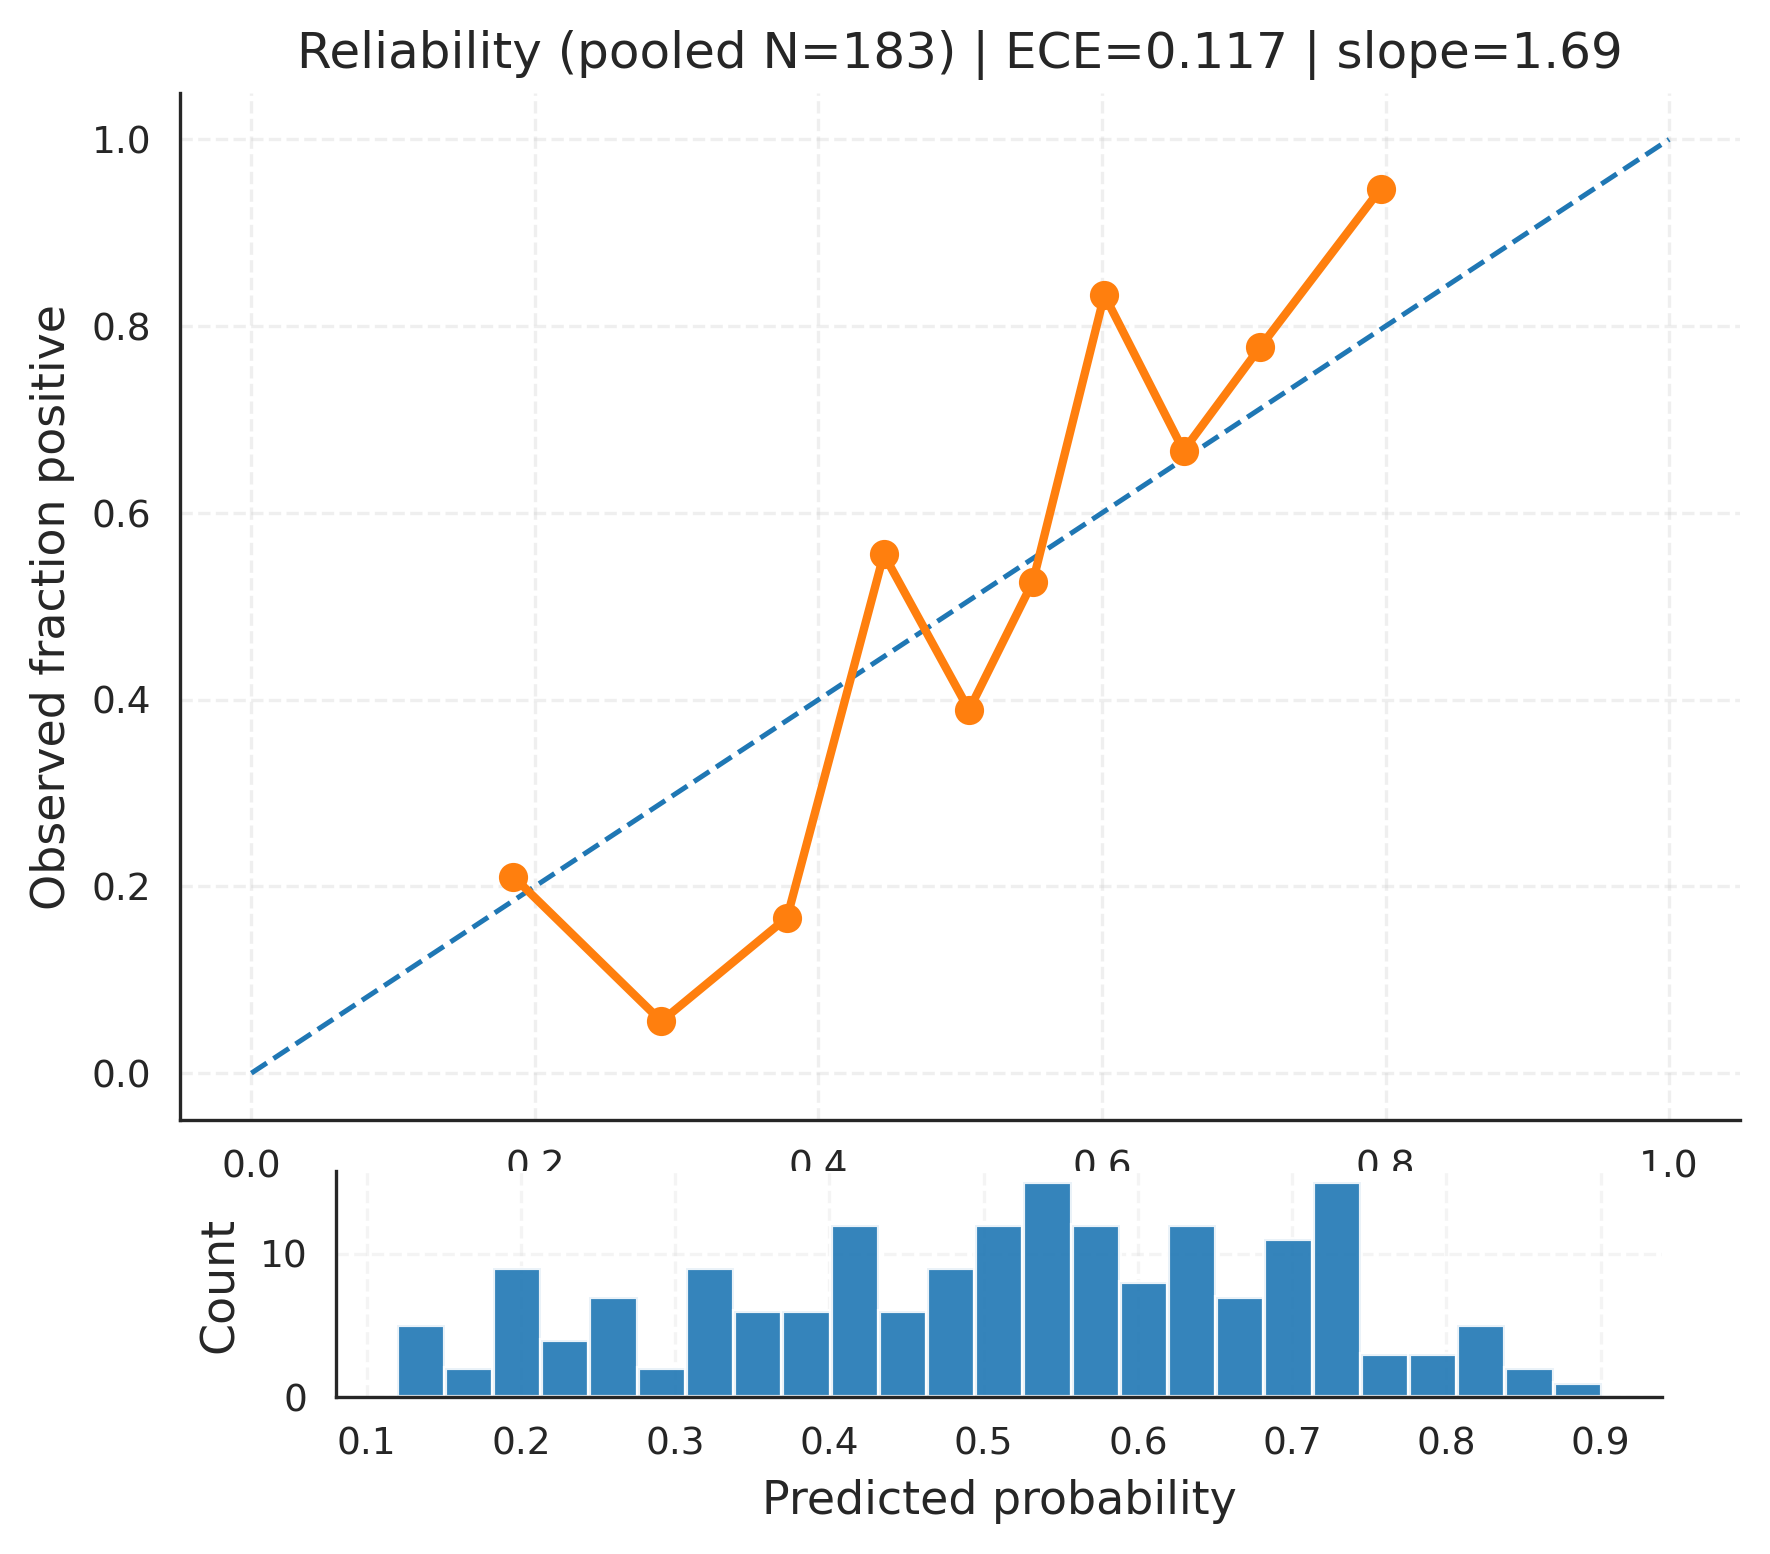

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_reliability_with_hist_pooled.pdf/.png


In [27]:
 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression

EPS = 1e-12

def _make_bin_edges(p, n_bins=10, strategy="quantile"):
    """Bordes robustos: evita edges repetidos en quantiles."""
    p = np.asarray(p, dtype=float)
    p = np.clip(p, EPS, 1 - EPS)

    if strategy == "quantile":
        # si hay muy pocos valores distintos, quantile colapsa -> fallback uniforme
        if np.unique(p).size < n_bins:
            edges = np.linspace(0, 1, n_bins + 1)
        else:
            edges = np.quantile(p, np.linspace(0, 1, n_bins + 1))
            # si quedaron repetidos, fallback
            if np.unique(edges).size < 3:
                edges = np.linspace(0, 1, n_bins + 1)
    else:
        edges = np.linspace(0, 1, n_bins + 1)

    edges = np.asarray(edges, dtype=float)
    edges[0], edges[-1] = 0.0, 1.0
    return edges

def weighted_ece_mce(y, p, n_bins=10, strategy="quantile"):
    """ECE ponderado por tamaño de bin + MCE. Devuelve (ece, mce, bins_df)."""
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)
    p = np.clip(p, EPS, 1 - EPS)

    edges = _make_bin_edges(p, n_bins=n_bins, strategy=strategy)

    ece = 0.0
    mce = 0.0
    rows = []

    n_total = len(y)
    for i in range(n_bins):
        lo, hi = edges[i], edges[i + 1]
        mask = (p >= lo) & (p <= hi) if i == n_bins - 1 else (p >= lo) & (p < hi)
        n = int(mask.sum())
        if n == 0:
            continue

        acc = float(y[mask].mean())
        conf = float(p[mask].mean())
        gap = abs(acc - conf)
        w = n / n_total

        ece += w * gap
        mce = max(mce, gap)
        rows.append({"bin": i, "n": n, "acc": acc, "conf": conf, "gap": gap, "lo": lo, "hi": hi})

    return float(ece), float(mce), pd.DataFrame(rows)

def calibration_slope_intercept(y, p):
    """
    Ajusta: y ~ a + b * logit(p)
    Retorna (a, b). Si hay 1 sola clase -> (nan, nan) sin romper.
    """
    y = np.asarray(y, dtype=int)
    if np.unique(y).size < 2:
        return np.nan, np.nan

    p = np.asarray(p, dtype=float)
    p = np.clip(p, EPS, 1 - EPS)
    logit = np.log(p / (1 - p)).reshape(-1, 1)

    try:
        lr = LogisticRegression(C=1e6, solver="lbfgs", max_iter=5000)
        lr.fit(logit, y)
        a = float(lr.intercept_[0])
        b = float(lr.coef_[0][0])
        return a, b
    except Exception:
        return np.nan, np.nan

def reliability_report(df, y="_y", p="_p", n_bins=10, strategy="quantile"):
    yv = df[y].to_numpy().astype(int)
    pv = df[p].to_numpy().astype(float)
    pv = np.clip(pv, EPS, 1 - EPS)

    ece, mce, bins_df = weighted_ece_mce(yv, pv, n_bins=n_bins, strategy=strategy)

    brier = float(brier_score_loss(yv, pv))
    null_p = float(yv.mean())

    # OJO: si null_p es 0 o 1 => brier_null = 0, BSS no definido
    brier_null = float(brier_score_loss(yv, np.full_like(yv, null_p)))
    bss = float(1.0 - (brier / brier_null)) if brier_null > 1e-15 else np.nan

    a, b = calibration_slope_intercept(yv, pv)

    return {
        "N": int(len(df)),
        "n_pos": int(yv.sum()),
        "n_neg": int(len(yv) - yv.sum()),
        "prev": float(yv.mean()),
        "Brier": brier,
        "BSS": bss,
        "ECE_w": float(ece),
        "MCE": float(mce),
        "calib_intercept": a,
        "calib_slope": b,
    }, bins_df



# === USO ===
if "master_df" not in globals():
    raise ValueError("Necesitás master_df (tu CELDA IT-0).")

group_col = "_confounder_collapsed" if "_confounder_collapsed" in master_df.columns else CONSISTENT_CONFOUNDER_COL

# 1) Tabla pooled + por confounder
rows = []
rep0, _ = reliability_report(master_df)
rows.append({"scope": "pooled", "group": "ALL", **rep0})

for g, df_g in master_df.groupby(group_col):
    if len(df_g) < 15:  # umbral práctico para evitar números basura en subgrupos
        continue
    repg, _ = reliability_report(df_g)
    rows.append({"scope": group_col, "group": str(g), **repg})

calib_df = pd.DataFrame(rows).sort_values(["scope", "group"])
display(calib_df.round(4))

calib_df.to_csv(OUTPUT_FIG_DIR / f"table_calibration_metrics_by_{group_col}.csv", index=False)

# 2) Figura reliability + histograma (pooled)
rep, bins_df = reliability_report(master_df)
fig, ax = plt.subplots(figsize=(6.0, 5.5))

# diagonal
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2)

# curva
ax.plot(bins_df["conf"], bins_df["acc"], marker="o", linewidth=2.0)
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Observed fraction positive")
ax.set_title(
    f"Reliability (pooled N={rep['N']}) | ECE={rep['ECE_w']:.3f} | slope={rep['calib_slope']:.2f}"
)
ax.grid(True, linestyle="--", alpha=0.3)

# histograma de scores (margen inferior)
ax2 = ax.inset_axes([0.10, -0.27, 0.85, 0.22])
ax2.hist(master_df["_p"].to_numpy(), bins=25, alpha=0.9)
ax2.set_xlabel("Predicted probability")
ax2.set_ylabel("Count")
ax2.grid(True, linestyle="--", alpha=0.2)

plt.tight_layout()
out = OUTPUT_FIG_DIR / "figure_reliability_with_hist_pooled"
plt.savefig(f"{out}.pdf", bbox_inches="tight")
plt.savefig(f"{out}.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"[OK] Guardado: {out}.pdf/.png")


[RESULT] AUC observado: 0.8135
[RESULT] Permutation p-value (one-sided (null >= obs)): 5e-05
[NULL] mean±sd: 0.6974 ± 0.0307
[NULL] 95% interval: [0.6376, 0.7587]


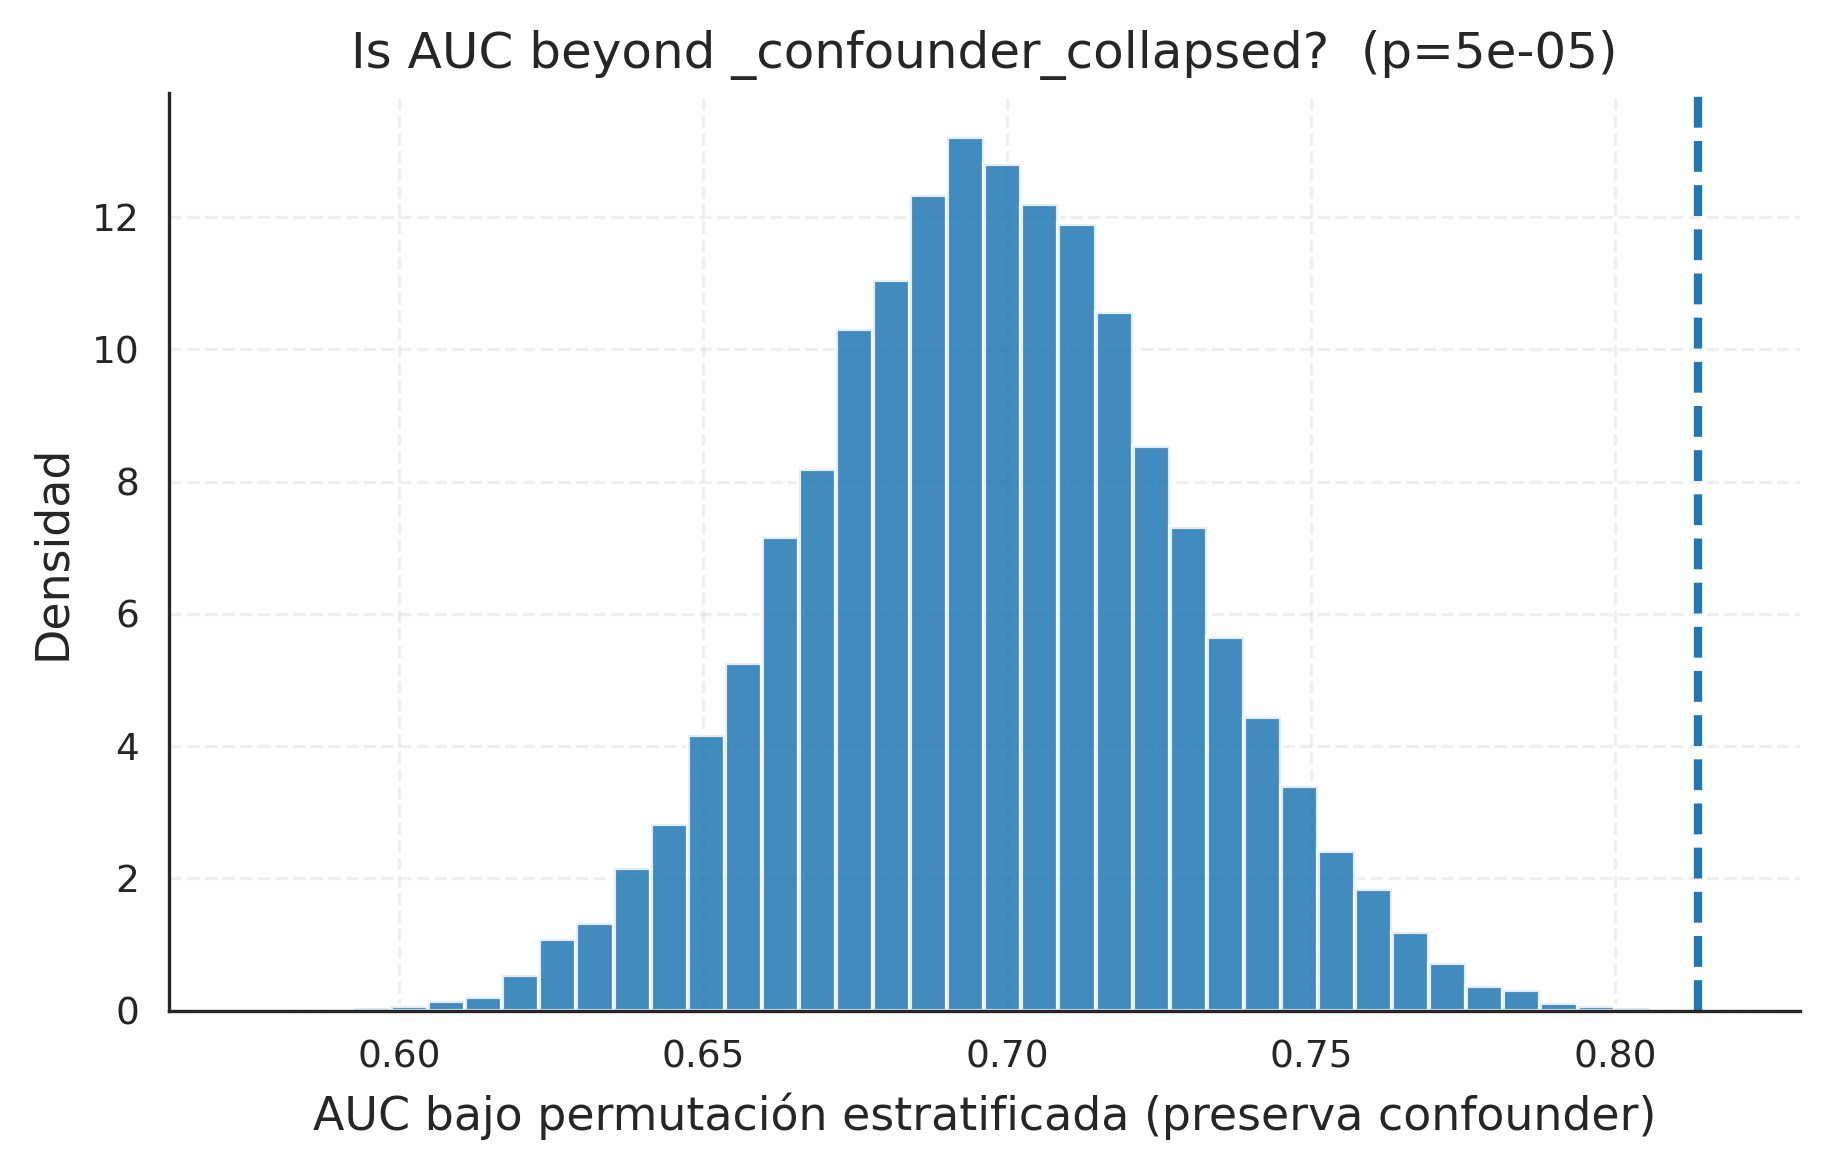

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_stratified_permtest_auc__confounder_collapsed.pdf/.png


In [28]:
 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def stratified_permutation_auc(df, y="_y", p="_p", group="_confounder_collapsed",
                               n_perm=10000, seed=42, two_sided=False):
    """
    Permuta Y *dentro* de cada grupo (confounder) para preservar estructura de confounding.
    Si el modelo explota solo el confounder, el AUC null se mantiene alto.
    """
    rng = np.random.default_rng(seed)

    y_true = df[y].to_numpy().astype(int)
    p_score = df[p].to_numpy().astype(float)
    g = df[group].astype(str).to_numpy()

    auc_obs = roc_auc_score(y_true, p_score)

    # precomputar índices por grupo
    idx_by_g = {}
    for i, gg in enumerate(g):
        idx_by_g.setdefault(gg, []).append(i)

    auc_null = np.empty(n_perm, dtype=float)

    for b in range(n_perm):
        y_perm = y_true.copy()
        for gg, idxs in idx_by_g.items():
            idxs = np.asarray(idxs, dtype=int)
            y_perm[idxs] = rng.permutation(y_perm[idxs])
        # si por algún motivo queda 1 clase (raro), saltear
        if len(np.unique(y_perm)) < 2:
            auc_null[b] = np.nan
        else:
            auc_null[b] = roc_auc_score(y_perm, p_score)

    auc_null = auc_null[np.isfinite(auc_null)]

    if two_sided:
        pval = float(np.mean(np.abs(auc_null - 0.5) >= abs(auc_obs - 0.5)))
        alt = "two-sided (|AUC-0.5|)"
    else:
        pval = float(np.mean(auc_null >= auc_obs))
        alt = "one-sided (null >= obs)"

    return auc_obs, auc_null, pval, alt


# === USO ===
if "master_df" not in globals():
    raise ValueError("Necesitás master_df (tu CELDA IT-0).")

group_col = "_confounder_collapsed" if "_confounder_collapsed" in master_df.columns else CONSISTENT_CONFOUNDER_COL

auc_obs, auc_null, pval, alt = stratified_permutation_auc(
    master_df, y="_y", p="_p", group=group_col,
    n_perm=20000, seed=42, two_sided=False
)

print(f"[RESULT] AUC observado: {auc_obs:.4f}")
print(f"[RESULT] Permutation p-value ({alt}): {pval:.4g}")
print(f"[NULL] mean±sd: {auc_null.mean():.4f} ± {auc_null.std(ddof=1):.4f}")
print(f"[NULL] 95% interval: [{np.percentile(auc_null,2.5):.4f}, {np.percentile(auc_null,97.5):.4f}]")

# Figura paper-grade (histograma del null + línea del observado)
fig, ax = plt.subplots(figsize=(6.2, 4.0))
ax.hist(auc_null, bins=40, density=True, alpha=0.85)
ax.axvline(auc_obs, linestyle="--", linewidth=2.0)
ax.set_xlabel("AUC bajo permutación estratificada (preserva confounder)")
ax.set_ylabel("Densidad")
ax.set_title(f"Is AUC beyond {group_col}?  (p={pval:.4g})")
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

out = OUTPUT_FIG_DIR / f"figure_stratified_permtest_auc_{group_col}"
plt.savefig(f"{out}.pdf", bbox_inches="tight")
plt.savefig(f"{out}.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"[OK] Guardado: {out}.pdf/.png")


In [29]:
 
import pandas as pd

MIN_N_DOMAIN = 6
MIN_PER_CLASS = 2

def cramers_v_bias_corrected(x, y):
    """
    Cramér's V con corrección de sesgo (Bergsma & Wicher) para tablas pequeñas.
    Devuelve np.nan si no es computable.
    """
    tab = pd.crosstab(pd.Series(x).astype(str), pd.Series(y).astype(int), dropna=False)
    obs = tab.to_numpy()
    n = obs.sum()
    if n == 0:
        return np.nan

    row_sum = obs.sum(axis=1, keepdims=True)
    col_sum = obs.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n

    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((obs - expected) ** 2 / expected)

    r, k = obs.shape
    if r < 2 or k < 2:
        return np.nan

    # phi2 corregido
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    if denom <= 0:
        return np.nan
    return float(np.sqrt(phi2corr / denom))


def domain_support_report(df, dom, y="_y", min_n=6, min_per_class=2):
    g = df.groupby(dom)[y]
    sizes = g.size()
    nunq = g.nunique()

    n_domains = int(sizes.shape[0])
    n_both = int((nunq >= 2).sum())
    n_single = int((nunq < 2).sum())

    # dominios donde AUC "sería" estimable
    ok = []
    for s, gg in df.groupby(dom):
        n = len(gg)
        n_ad = int(gg[y].sum())
        n_cn = n - n_ad
        if (n >= min_n) and (n_ad >= min_per_class) and (n_cn >= min_per_class):
            ok.append(s)
    n_auc_estimable = int(len(ok))

    return {
        "domain": dom,
        "n_total": int(len(df)),
        "n_domains": n_domains,
        "both_class_domains": n_both,
        "single_class_domains": n_single,
        "auc_estimable_domains": n_auc_estimable,
        "pct_single_class": (n_single / n_domains) if n_domains else np.nan,
        "cramersV_bc(domain,diag)": cramers_v_bias_corrected(df[dom], df[y]),
    }


# === USO ===
# Recomendación: reportar sobre master_df pooled (OOF), no sobre un fold chico.
if "master_df" not in globals():
    raise ValueError("Necesitás master_df (tu CELDA IT-0).")

domains_to_report = []
for c in ["Site3", "Site3_collapsed", "Manufacturer", "ImagingProtocol", "_confounder_collapsed"]:
    if c in master_df.columns:
        domains_to_report.append(c)

rows = [domain_support_report(master_df, d, y="_y", min_n=MIN_N_DOMAIN, min_per_class=MIN_PER_CLASS)
        for d in domains_to_report]

support_df = pd.DataFrame(rows).sort_values(["cramersV_bc(domain,diag)"], ascending=False)
display(support_df)

support_df.to_csv(OUTPUT_FIG_DIR / "table_domain_support_and_cramersV_bias_corrected.csv", index=False)

print("\n[LECTURA PAPER]")
print("- Si auc_estimable_domains es ~0-2 (como Site3), NO interpretar within-domain AUC como evidencia fuerte.")
print("- Manufacturer/Protocol suelen tener mejor soporte y son más reportables.")


domain  n_total  n_domains  both_class_domains  \
3        ImagingProtocol      183          7                   3   
2           Manufacturer      183          3                   1   
4  _confounder_collapsed      183          3                   1   
0                  Site3      183         33                  13   
1        Site3_collapsed      183         12                   8   

   single_class_domains  auc_estimable_domains  pct_single_class  \
3                     4                      3          0.571429   
2                     2                      1          0.666667   
4                     2                      1          0.666667   
0                    20                      7          0.606061   
1                     4                      8          0.333333   

   cramersV_bc(domain,diag)  
3                  0.605444  
2                  0.572235  
4                  0.572235  
0                  0.513286  
1                  0.453845


[LECTURA PAPER]
- Si auc_estimable_domains es ~0-2 (como Site3), NO interpretar within-domain AUC como evidencia fuerte.
- Manufacturer/Protocol suelen tener mejor soporte y son más reportables.


In [30]:
# ===================== CELDA IT-1: INFO THEORY (H, MI, H condicional) con confounder consistente =====================
 
import pandas as pd
from sklearn.metrics import mutual_info_score

LN2 = np.log(2.0)


def entropy_from_counts(counts):
    counts = np.asarray(counts, dtype=float)
    n = counts.sum()
    if n <= 0:
        return np.nan
    p = counts / n
    p = p[p > 0]
    return float(-(p * np.log(p)).sum() / LN2)  # bits


def entropy_discrete(s):
    vc = pd.Series(s).value_counts(dropna=False)
    return entropy_from_counts(vc.values)


def conditional_entropy(y, s):
    y = pd.Series(y)
    s = pd.Series(s).astype(str)
    n = len(y)
    if n == 0:
        return np.nan
    h = 0.0
    for _, idx in s.groupby(s).groups.items():
        yy = y.loc[idx]
        w = len(yy) / n
        h += w * entropy_discrete(yy)
    return float(h)


def mi_bits(a, b):
    # sklearn MI usa ln => nats. Convertimos a bits.
    return float(mutual_info_score(pd.Series(a).astype(str), pd.Series(b).astype(str)) / LN2)


def nmi(a, b):
    ha = entropy_discrete(a)
    hb = entropy_discrete(b)
    mi = mi_bits(a, b)
    denom = min(ha, hb)
    return mi / denom if denom and np.isfinite(denom) and denom > 0 else np.nan


def it_report(df, y="_y", domains=None):
    if domains is None:
        domains = ["_confounder_collapsed"]

    rows = []
    hy = entropy_discrete(df[y])
    for d in domains:
        if d not in df.columns:
            continue
        hs = entropy_discrete(df[d].astype(str))
        mi = mi_bits(df[y], df[d])
        hy_s = conditional_entropy(df[y], df[d])
        rows.append({
            "domain": d,
            "H(Y) bits": hy,
            "H(S) bits": hs,
            "I(Y;S) bits": mi,
            "NMI": nmi(df[y], df[d]),
            "H(Y|S) bits": hy_s,
            "frac_entropy_left": hy_s / hy if hy > 0 else np.nan,
            "n_domains": int(df[d].astype(str).nunique(dropna=False)),
        })

    return pd.DataFrame(rows).sort_values("I(Y;S) bits", ascending=False)


if "CONSISTENT_CONFOUNDER_COL" not in globals():
    raise ValueError("Ejecutá primero la CELDA IT-0 para fijar el confounder consistente.")

domains_for_it = [CONSISTENT_CONFOUNDER_COL]
if "_confounder_collapsed" in master_df.columns:
    domains_for_it.append("_confounder_collapsed")
# evitar duplicados si colapsado coincide con columna original
seen = set()
domains_for_it = [d for d in domains_for_it if not (d in seen or seen.add(d))]

print(f"=== POOLED (all test folds) | confounder={CONSISTENT_CONFOUNDER_COL} ===")
pooled_it_df = it_report(master_df, domains=domains_for_it)
display(pooled_it_df)

print()
print("=== PER FOLD ===")
per_fold = []
for k, g in master_df.groupby("fold"):
    rep = it_report(g, domains=domains_for_it)
    rep.insert(0, "fold", k)
    per_fold.append(rep)
per_fold_df = pd.concat(per_fold, ignore_index=True)
display(per_fold_df.sort_values(["domain", "fold"]))

# export paper-grade
pooled_it_df.to_csv(OUTPUT_FIG_DIR / "table_it_domain_pooled_consistent_confounder.csv", index=False)
per_fold_df.to_csv(OUTPUT_FIG_DIR / "table_it_domain_per_fold_consistent_confounder.csv", index=False)
print("[OK] Guardado IT consistente en training_qc/")

=== POOLED (all test folds) | confounder=Manufacturer ===


domain  H(Y) bits  H(S) bits  I(Y;S) bits       NMI  \
0           Manufacturer   0.999461   1.089521     0.316697  0.316867   
1  _confounder_collapsed   0.999461   1.089521     0.316697  0.316867   

   H(Y|S) bits  frac_entropy_left  n_domains  
0     0.682765           0.683133          3  
1     0.682765           0.683133          3


=== PER FOLD ===


fold                 domain  H(Y) bits  H(S) bits  I(Y;S) bits       NMI  \
0     1           Manufacturer   0.999473   0.811710     0.212216  0.261443   
2     2           Manufacturer   0.999473   0.870725     0.248958  0.285920   
4     3           Manufacturer   0.999473   1.172139     0.421466  0.421688   
6     4           Manufacturer   1.000000   1.176928     0.405937  0.405937   
8     5           Manufacturer   0.997772   1.122114     0.325682  0.326410   
1     1  _confounder_collapsed   0.999473   0.811710     0.212216  0.261443   
3     2  _confounder_collapsed   0.999473   0.870725     0.248958  0.285920   
5     3  _confounder_collapsed   0.999473   1.172139     0.421466  0.421688   
7     4  _confounder_collapsed   1.000000   1.176928     0.405937  0.405937   
9     5  _confounder_collapsed   0.997772   1.122114     0.325682  0.326410   

   H(Y|S) bits  frac_entropy_left  n_domains  
0     0.787257           0.787672          3  
2     0.750515           0.750911          3  
4     0.578007           0.578312          3  
6     0.594063           0.594063          3  
8     0.672090           0.673590          3  
1     0.787257           0.787672          3  
3     0.750515           0.750911          3  
5     0.578007           0.578312          3  
7     0.594063           0.594063          3  
9     0.672090           0.673590          3

[OK] Guardado IT consistente en training_qc/


In [31]:
# ===================== CELDA IT-2: INFO GAIN (bits) + Calibration quick metrics =====================
 
import pandas as pd

LN2 = np.log(2.0)
EPS = 1e-12

def logloss(y, p):
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)
    p = np.clip(p, EPS, 1-EPS)
    return float(-(y*np.log(p) + (1-y)*np.log(1-p)).mean())  # nats

def info_gain_bits(y, p):
    pi = float(np.mean(y))
    base = logloss(y, np.full_like(p, pi, dtype=float))
    model = logloss(y, p)
    return float((base - model) / LN2), float(base/LN2), float(model/LN2)

def ece(y, p, n_bins=10):
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)
    bins = np.quantile(p, np.linspace(0,1,n_bins+1))
    # evitar bins repetidos
    bins[0], bins[-1] = 0.0, 1.0
    e = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (p >= lo) & (p <= hi) if i==n_bins-1 else (p >= lo) & (p < hi)
        if mask.sum() == 0: 
            continue
        acc = y[mask].mean()
        conf = p[mask].mean()
        e += (mask.sum()/len(y)) * abs(acc - conf)
    return float(e)

def report_gain(df):
    ig, base_bits, model_bits = info_gain_bits(df["_y"], df["_p"])
    return {
        "N": int(len(df)),
        "AUC": float(__import__("sklearn.metrics").metrics.roc_auc_score(df["_y"], df["_p"])),
        "InfoGain bits": ig,
        "Base NLL (bits)": base_bits,
        "Model NLL (bits)": model_bits,
        "ECE(10q)": ece(df["_y"], df["_p"], n_bins=10),
    }

rows = []
rows.append({"scope":"pooled", "fold":"all", **report_gain(master_df)})
for k,g in master_df.groupby("fold"):
    rows.append({"scope":"fold", "fold":k, **report_gain(g)})

gain_df = pd.DataFrame(rows)
display(gain_df.round(4))


scope fold    N     AUC  InfoGain bits  Base NLL (bits)  Model NLL (bits)  \
0  pooled  all  183  0.8135         0.1988           0.9995            0.8007   
1    fold    1   37  0.8830         0.2591           0.9995            0.7404   
2    fold    2   37  0.8333         0.1561           0.9995            0.8433   
3    fold    3   37  0.8421         0.2362           0.9995            0.7633   
4    fold    4   36  0.7840         0.1427           1.0000            0.8573   
5    fold    5   36  0.8359         0.1972           0.9978            0.8005   

   ECE(10q)  
0    0.1172  
1    0.1997  
2    0.3427  
3    0.1853  
4    0.1707  
5    0.1613

In [32]:
# ===================== CELDA X: METADATA + ALINEACIÓN CON GLOBAL_TENSOR (N=431) =====================
from pathlib import Path
 
import pandas as pd

#leemos global tensor
if "GLOBAL_TENSOR_PATH" not in globals():
    raise ValueError(
        "⚠️ No encuentro la variable GLOBAL_TENSOR_PATH. "
        "Definila con la ruta al .npz del GLOBAL_TENSOR antes de ejecutar esta celda."
    )

# Reutilizamos project_root si ya existe; si no, lo definimos.
project_root = Path.cwd().resolve().parent

# --- 1) Cargar metadata cruda (434 filas en tu caso) ---
metadata_path = project_root / "data/SubjectsData_AAL3_procesado2.csv"
metadata_raw = pd.read_csv(metadata_path)
print("[OK] metadata_raw:", metadata_path)
print("[INFO] metadata_raw shape:", metadata_raw.shape)

# --- 2) Requerimos que el tensor global ya esté cargado (de la celda del NPZ) ---
if "data_npz" not in globals() or "global_tensor_data" not in globals():
    raise ValueError(
        "⚠️ No encuentro 'data_npz' y/o 'global_tensor_data'. "
        "Ejecutá antes la celda donde cargas el GLOBAL_TENSOR .npz."
    )

N_tensor = int(global_tensor_data.shape[0])
print("[INFO] global_tensor_data shape:", global_tensor_data.shape)
print("[INFO] N_tensor =", N_tensor)

# --- 3) Normalizar / crear ResearchGroup_Mapped si falta ---
def map_group(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().upper()
    if "CN" in s or "CONTROL" in s or "NORMAL" in s:
        return "CN"
    if "AD" in s or "ALZ" in s:
        return "AD"
    if "MCI" in s:
        return "MCI"
    return str(x)

metadata_raw = metadata_raw.copy()
if "ResearchGroup_Mapped" not in metadata_raw.columns:
    if "ResearchGroup" in metadata_raw.columns:
        metadata_raw["ResearchGroup_Mapped"] = metadata_raw["ResearchGroup"].map(map_group)
        print("[INFO] Se creó ResearchGroup_Mapped desde ResearchGroup.")
    else:
        metadata_raw["ResearchGroup_Mapped"] = np.nan
        print("[WARN] No existe ResearchGroup ni ResearchGroup_Mapped en metadata_raw.")

# --- 4) Estrategia A: buscar sidecar metadata ya alineada junto al NPZ (ideal) ---
tensor_dir = Path(GLOBAL_TENSOR_PATH).parent if "GLOBAL_TENSOR_PATH" in globals() else None
aligned = None
align_method = None

if tensor_dir is not None and tensor_dir.exists():
    sidecar_candidates = []
    sidecar_candidates += list(tensor_dir.glob("*metadata*.csv"))
    sidecar_candidates += list(tensor_dir.glob("*subjects*.csv"))
    sidecar_candidates += list(tensor_dir.glob("*Subjects*.csv"))
    sidecar_candidates += list(tensor_dir.glob("*index*.csv"))

    # Filtrar candidatos razonables
    sidecar_candidates = sorted(set(sidecar_candidates), key=lambda p: p.stat().st_mtime, reverse=True)

    for p in sidecar_candidates:
        try:
            tmp = pd.read_csv(p)
            if len(tmp) == N_tensor:
                aligned = tmp.copy()
                align_method = f"sidecar_csv:{p.name}"
                print(f"[OK] Encontré sidecar alineado (N={N_tensor}): {p.name}")
                break
        except Exception:
            pass

# --- 5) Estrategia B: intentar extraer IDs desde el NPZ y matchear contra metadata_raw ---
def _to_str_array(a):
    a = np.asarray(a)
    if a.dtype.kind == "S":
        return np.array([x.decode("utf-8", errors="ignore") for x in a], dtype=object)
    if a.dtype.kind in {"U", "O"}:
        return a.astype(object)
    return None

def find_id_vector_in_npz(npz_obj, N):
    """
    Busca un vector 1D de strings en el npz con longitud N que parezca SubjectID/participant_id/etc.
    """
    keys = list(npz_obj.files)
    scored = []
    for k in keys:
        arr = npz_obj[k]
        if not hasattr(arr, "shape"):
            continue
        if arr.ndim != 1 or arr.shape[0] != N:
            continue
        sarr = _to_str_array(arr)
        if sarr is None:
            continue

        kn = k.lower()
        score = 0
        for tok in ["subject", "subj", "participant", "ptid", "rid", "id"]:
            if tok in kn:
                score += 1
        # penalizar cosas tipo "site" si aparece
        if "site" in kn or "scanner" in kn:
            score -= 1
        scored.append((score, k, sarr))

    scored.sort(key=lambda t: t[0], reverse=True)
    if scored and scored[0][0] >= 1:
        return scored[0][1], scored[0][2]
    return None, None

if aligned is None:
    id_key, tensor_ids = find_id_vector_in_npz(data_npz, N_tensor)
    if tensor_ids is not None and "SubjectID" in metadata_raw.columns:
        # construir key en metadata
        meta = metadata_raw.copy()
        meta["SubjectID_str"] = meta["SubjectID"].astype(str).str.strip()

        # Si hay Visit, intentamos también (pero sin asumir formato)
        if "Visit" in meta.columns:
            meta["Visit_str"] = meta["Visit"].astype(str).str.strip()
            meta["key_sid_visit"] = meta["SubjectID_str"] + "|" + meta["Visit_str"]
        meta["key_sid"] = meta["SubjectID_str"]

        # detectar si tensor_ids ya vienen con separador tipo "|" (SubjectID|Visit)
        tensor_ids_s = pd.Series(tensor_ids).astype(str).str.strip()
        has_pipe = tensor_ids_s.str.contains(r"\|", regex=True).mean() > 0.5

        if has_pipe and "key_sid_visit" in meta.columns:
            meta_map = meta.set_index("key_sid_visit", drop=False)
            missing = (~tensor_ids_s.isin(meta_map.index)).sum()
            if missing == 0:
                aligned = meta_map.loc[tensor_ids_s.values].reset_index(drop=True)
                align_method = f"npz_ids:{id_key} (match SubjectID|Visit)"
                print(f"[OK] Alineación por IDs del NPZ usando {id_key} (SubjectID|Visit).")
            else:
                print(f"[WARN] NPZ IDs parecen tener '|', pero faltan {missing} keys en metadata.")
        else:
            # match por SubjectID solamente
            meta_map = meta.set_index("key_sid", drop=False)
            missing = (~tensor_ids_s.isin(meta_map.index)).sum()
            if missing == 0:
                aligned = meta_map.loc[tensor_ids_s.values].reset_index(drop=True)
                align_method = f"npz_ids:{id_key} (match SubjectID)"
                print(f"[OK] Alineación por IDs del NPZ usando {id_key} (SubjectID).")
            else:
                print(f"[WARN] No pude matchear tensor_ids contra SubjectID: faltan {missing}.")

# --- 6) Estrategia C: buscar una máscara keep/drop en el NPZ ---
if aligned is None:
    for k in data_npz.files:
        arr = data_npz[k]
        if hasattr(arr, "ndim") and arr.ndim == 1 and arr.dtype == bool:
            # Dos casos típicos: máscara de longitud metadata_raw o de longitud tensor
            if arr.shape[0] == len(metadata_raw):
                kept = metadata_raw[arr].reset_index(drop=True)
                if len(kept) == N_tensor:
                    aligned = kept.copy()
                    align_method = f"npz_keepmask:{k}"
                    print(f"[OK] Alineación por keep-mask NPZ: {k}")
                    break

# --- 7) Fallback (último recurso): truncar y advertir ---
if aligned is None:
    print(
        "[WARN] No pude alinear por sidecar/IDs/keepmask. "
        "Hago fallback: truncado a N_tensor. "
        "Esto sólo es válido si el orden de metadata_raw coincide con el tensor."
    )
    aligned = metadata_raw.iloc[:N_tensor].copy()
    align_method = "fallback_truncate"

# --- 8) Normalizar salida final: tensor_idx correcto 0..N_tensor-1 ---
metadata_df_full = aligned.reset_index(drop=True).copy()
metadata_df_full["tensor_idx"] = np.arange(N_tensor, dtype=int)

print("\n[RESUMEN ALINEACIÓN]")
print("  Método:", align_method)
print("  metadata_raw N:", len(metadata_raw))
print("  tensor N:", N_tensor)
print("  metadata_aligned N:", len(metadata_df_full))
print("  removidos por QC (estimado):", len(metadata_raw) - len(metadata_df_full))

# --- 9) Guardar para trazabilidad ---
out_meta_aligned = OUTPUT_FIG_DIR / "metadata_aligned_to_tensor.csv"
metadata_df_full.to_csv(out_meta_aligned, index=False)
print(f"[OK] Guardado: {out_meta_aligned}")


[OK] metadata_raw: /home/diego/proyectos/vae_AD/data/SubjectsData_AAL3_procesado2.csv
[INFO] metadata_raw shape: (434, 33)
[INFO] global_tensor_data shape: (431, 7, 131, 131)
[INFO] N_tensor = 431
[OK] Alineación por IDs del NPZ usando subject_ids (SubjectID).

[RESUMEN ALINEACIÓN]
  Método: npz_ids:subject_ids (match SubjectID)
  metadata_raw N: 434
  tensor N: 431
  metadata_aligned N: 431
  removidos por QC (estimado): 3
[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/metadata_aligned_to_tensor.csv


In [33]:
# ¡Sólo si estás seguro de que el orden coincide!
# Por ejemplo, si ya filtraste metadata_df_full a los mismos 431 sujetos del tensor
metadata_df_full = metadata_df_full.reset_index(drop=True).copy()
metadata_df_full["tensor_idx"] = np.arange(len(metadata_df_full))
print("Metadata con índice de tensor añadido.")

Metadata con índice de tensor añadido.


In [34]:
# ==============================================================================
# === CELDA 8: Figura 2 — Latent Space por Fold (UMAP sobre TEST) [ROBUSTA] ===
# ==============================================================================

import logging
import umap
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
 
import pandas as pd
import joblib
from pathlib import Path

logging.getLogger("fontTools.subset").setLevel(logging.ERROR)

# --- Checks mínimos ---
if "run_args" not in globals():
    raise ValueError("⚠️ Falta run_args. Ejecutá la CELDA 1c.")
if "metadata_df_full" not in globals() or metadata_df_full is None:
    raise ValueError("⚠️ Falta metadata_df_full alineada. Ejecutá la CELDA X.")
if "global_tensor_data" not in globals():
    raise ValueError("⚠️ Falta global_tensor_data. Ejecutá la celda que carga el NPZ.")
try:
    from betavae_xai.models.convolutional_vae import ConvolutionalVAE
except ImportError:
    from src.betavae_xai.models.convolutional_vae import ConvolutionalVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helpers de normalización ---
def apply_norm_inference(tensor_mv, params_list):
    C, H, W = tensor_mv.shape
    normed = tensor_mv.copy()
    mask = ~np.eye(H, dtype=bool)

    for c in range(C):
        p = params_list[c]
        if p.get("no_scale", False):
            continue

        vals = tensor_mv[c]
        mode = p.get("mode", None)

        if mode == "zscore_offdiag":
            std = float(p.get("std", 0.0))
            if std > 1e-9:
                normed[c, mask] = (vals[mask] - float(p.get("mean", 0.0))) / std
            else:
                normed[c, mask] = 0.0

        elif mode == "minmax_offdiag":
            vmin = float(p.get("min", 0.0))
            vmax = float(p.get("max", 1.0))
            rng = vmax - vmin
            if rng > 1e-9:
                normed[c, mask] = (vals[mask] - vmin) / rng
            else:
                normed[c, mask] = 0.0

    return normed

def apply_norm_batch(tensor_4d: np.ndarray, params_list):
    N = tensor_4d.shape[0]
    out = np.empty_like(tensor_4d)
    for i in range(N):
        out[i] = apply_norm_inference(tensor_4d[i], params_list)
    return out

# --- Construir CN/AD en el ORDEN original del tensor (esto debe matchear los índices guardados) ---
cn_ad_df = metadata_df_full[metadata_df_full["ResearchGroup_Mapped"].isin(["CN", "AD"])].copy()
cn_ad_df = cn_ad_df.reset_index(drop=True)
print("[INFO] CN/AD shape:", cn_ad_df.shape)

# --- Loop folds: obtener embeddings μ de TEST ---
all_fold_data = []

for fold_i in range(1, N_FOLDS + 1):
    fold_dir = RESULTS_DIR / f"fold_{fold_i}"

    test_idx_path = fold_dir / "test_indices.npy"
    if not test_idx_path.exists():
        raise FileNotFoundError(f"Falta {test_idx_path}")

    test_idx = np.load(test_idx_path)
    df_test = cn_ad_df.iloc[test_idx].copy()

    # Cargar norm params del fold
    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    # Tensores del test (N, C, H, W)
    CH = run_args["channels_to_use"]
    tens = global_tensor_data[df_test["tensor_idx"].values][:, CH, :, :]
    tens_norm = apply_norm_batch(tens, norm_params)

    # VAE + encode
    vae = ConvolutionalVAE(
        input_channels=len(CH),
        latent_dim=run_args["latent_dim"],
        image_size=global_tensor_data.shape[-1],
        num_conv_layers_encoder=run_args["num_conv_layers_encoder"],
        decoder_type=run_args["decoder_type"],
        final_activation=run_args["vae_final_activation"],
        intermediate_fc_dim_config=run_args["intermediate_fc_dim_vae"],
        dropout_rate=run_args["dropout_rate_vae"],
        use_layernorm_fc=run_args["use_layernorm_vae_fc"],
    ).to(device)

    ckpt = fold_dir / f"vae_model_fold_{fold_i}.pt"
    vae.load_state_dict(torch.load(ckpt, map_location=device))
    vae.eval()

    with torch.no_grad():
        t_torch = torch.from_numpy(tens_norm).float().to(device)
        mu, _ = vae.encode(t_torch)

    df_test["embeddings"] = list(mu.cpu().numpy())
    df_test["fold"] = fold_i
    all_fold_data.append(df_test)

print("[OK] Embeddings de TEST generados para todos los folds.")

# --- Plot UMAP por fold ---
full_test_df = pd.concat(all_fold_data, ignore_index=True)

# Limpieza Manufacturer
if "Manufacturer" in full_test_df.columns:
    full_test_df["Manufacturer"] = (
        full_test_df["Manufacturer"].astype(str)
        .str.replace(" Medical Systems", "", regex=False)
        .str.replace(" Healthcare", "", regex=False)
        .fillna("Unknown")
    )
else:
    full_test_df["Manufacturer"] = "Unknown"

mans = sorted(full_test_df["Manufacturer"].unique())
markers = ["o", "s", "X", "P", "D", "^", "v"]
marker_map = {m: markers[i % len(markers)] for i, m in enumerate(mans)}

sns.set_style("white")
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "axes.spines.top": False,
    "axes.spines.right": False,
})

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Latent Space of Test Sets Across Folds", fontsize=20, weight="bold")
axes_flat = axes.flatten()

for i, fold_i in enumerate(range(1, N_FOLDS + 1)):
    if i >= len(axes_flat) - 1:
        break
    ax = axes_flat[i]

    df_fold = full_test_df[full_test_df["fold"] == fold_i].copy()

    reducer = umap.UMAP(
        n_neighbors=10,
        min_dist=0.2,
        metric="cosine",
        random_state=42,
    )
    emb2d = reducer.fit_transform(np.vstack(df_fold["embeddings"].values))

    plot_df = pd.DataFrame(emb2d, columns=["UMAP 1", "UMAP 2"])
    plot_df = pd.concat([plot_df, df_fold.reset_index(drop=True)], axis=1)

    sns.scatterplot(
        data=plot_df,
        x="UMAP 1", y="UMAP 2",
        hue="ResearchGroup_Mapped",
        style="Manufacturer",
        size="Age" if "Age" in plot_df.columns else None,
        palette={"CN": "navy", "AD": "crimson"},
        sizes=(40, 200),
        style_order=mans,
        markers=marker_map,
        alpha=0.8,
        ax=ax,
    )

    ax.set_title(f"Fold {fold_i} (TEST, n={len(df_fold)})")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend().remove()

# Leyenda global
legend_ax = axes_flat[-1]
legend_ax.axis("off")
handles, labels = axes_flat[0].get_legend_handles_labels()
legend_ax.legend(handles, labels, ncol=1, loc="center", frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.96])

fig_path_base = OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed"
plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{fig_path_base}.pdf", bbox_inches="tight")
plt.savefig(f"{fig_path_base}.svg", bbox_inches="tight")
plt.show()

print(f"[OK] Guardado:\n  {fig_path_base}.png/.pdf/.svg")


[INFO] CN/AD shape: (183, 38)
[OK] Embeddings de TEST generados para todos los folds.


[OK] Guardado:
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure2_umap_per_fold_detailed.png/.pdf/.svg


In [35]:
# ===================== CELDA VISUAL: Robustez por Sitio =====================
import seaborn as sns
import matplotlib.pyplot as plt

# Usamos master_df que creaste en IT-0
plot_df = master_df.copy()

# Filtramos sitios con muy pocos pacientes para limpiar la gráfica
top_sites = plot_df[CONSISTENT_CONFOUNDER_COL].value_counts().head(5).index
plot_df_filt = plot_df[plot_df[CONSISTENT_CONFOUNDER_COL].isin(top_sites)]

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Violin plot para mostrar la distribución
sns.violinplot(
    data=plot_df_filt,
    x=CONSISTENT_CONFOUNDER_COL, 
    y="_p", 
    hue="_y", 
    split=True, 
    inner=None,
    palette={0: "skyblue", 1: "salmon"},
    alpha=0.3
)

# Swarmplot para mostrar los pacientes individuales (los puntos)
sns.stripplot(
    data=plot_df_filt,
    x=CONSISTENT_CONFOUNDER_COL, 
    y="_p", 
    hue="_y", 
    dodge=True, 
    jitter=True,
    marker='o', 
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.5,
    palette={0: "navy", 1: "darkred"}
)

# Línea de decisión
plt.axhline(0.5, color='black', linestyle='--', linewidth=1, label="Decision Threshold")

# Estética
plt.title(f"Model Predictions Stratified by {CONSISTENT_CONFOUNDER_COL}\n(Evidence of Within-Site Discrimination)", fontsize=14)
plt.ylabel("Predicted Probability of AD")
plt.xlabel("Site / Scanner")
plt.legend(title="True Diagnosis", loc='upper right', labels=['CN', 'AD'])

# Manejo de leyenda duplicada por usar dos plots
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[2:], ['CN', 'AD'], loc='lower right', title="Diagnosis")

plt.tight_layout()
plt.savefig(OUTPUT_FIG_DIR / "figure_stratified_predictions_swarm.pdf")
plt.show()

print("INTERPRETACIÓN:")
print("Si los puntos rojos (AD) están sistemáticamente más arriba que los azules (CN)")
print("DENTRO de cada violín, entonces el modelo funciona INDEPENDIENTEMENTE del sitio.")

INTERPRETACIÓN:
Si los puntos rojos (AD) están sistemáticamente más arriba que los azules (CN)
DENTRO de cada violín, entonces el modelo funciona INDEPENDIENTEMENTE del sitio.


In [36]:
# ==============================================================================
# === CELDA 9 (ENHANCED): QC Latente Completo (TC + PR + Silhouette + Leakage) ===
# ==============================================================================
 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# --- Helpers ---
def participation_ratio(evals):
    """Calcula la dimensión intrínseca efectiva."""
    ev = np.asarray(evals, dtype=float)
    ev = ev[ev > 0]
    if ev.size == 0: return np.nan
    s1, s2 = ev.sum(), np.square(ev).sum()
    return (s1*s1)/s2

def total_correlation_gauss(Z):
    """
    Calcula la Total Correlation (TC) asumiendo normalidad.
    Mide la redundancia: 0 = independencia total entre dimensiones.
    """
    # Covarianza empírica
    cov = np.cov(Z, rowvar=False)
    N_dim = cov.shape[0]
    
    # Regularización mínima para evitar log(0) en dims colapsadas
    eps = 1e-6
    cov_reg = cov + eps * np.eye(N_dim)
    
    # 1. Suma de entropías marginales (log de varianzas diagonales)
    # H(z_i) approx 0.5 * log(var_i)
    log_sum_marginals = np.sum(np.log(np.diag(cov_reg)))
    
    # 2. Entropía conjunta (log del determinante -> suma log autovalores)
    # H(Z) approx 0.5 * log(det(Sigma))
    eigvals = np.linalg.eigvalsh(cov_reg)
    eigvals = eigvals[eigvals > 0] # seguridad
    log_det = np.sum(np.log(eigvals))
    
    # TC = Sum(H(z_i)) - H(Z)
    tc_nats = 0.5 * (log_sum_marginals - log_det)
    return tc_nats / np.log(2) # bits

def clean_confounder_label(s):
    if pd.isna(s): return 'Unknown'
    return str(s).replace(' Medical Systems','').replace(' Healthcare','').strip()

# --- Main Loop ---
if 'all_fold_data' not in globals():
    raise ValueError("⚠️ Faltan datos: Ejecuta la CELDA 8 primero.")

print(f"Calculando Métricas Avanzadas (TC, PR, Leakage) sobre {len(all_fold_data)} folds...")
rows = []

for fold_i, df_fold in enumerate(all_fold_data, start=1):
    # Datos
    Z = np.vstack(df_fold['embeddings'].values)
    y_diag = df_fold['ResearchGroup_Mapped'].values
    
    # Identificar confounder (Manufacturer > Site3)
    mf_cols = [c for c in df_fold.columns if "Manufacturer" in c]
    manufacturer_col = mf_cols[0] if mf_cols else "Site3"
    y_conf = pd.Series(df_fold[manufacturer_col].map(clean_confounder_label))

    # A. Total Correlation (Independencia)
    tc_bits = total_correlation_gauss(Z)

    # B. Dimensionality (PR & PCA90)
    # Estandarizamos para PCA/PR (escala común)
    Zstd = StandardScaler().fit_transform(Z)
    pca_full = PCA(svd_solver="full", random_state=42).fit(Zstd)
    ev = pca_full.explained_variance_
    pr = participation_ratio(ev)
    dims90 = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), 0.90) + 1)

    # C. Silhouette (Separabilidad Biológica)
    # Usamos las primeras 20 PCs para reducir ruido, standard practice
    Z_pca20 = pca_full.transform(Zstd)[:, :20]
    try:
        sil = silhouette_score(Z_pca20, y_diag)
    except:
        sil = np.nan

    # D. Leakage (Confounder Decodability)
    # kNN simple para ver si el fabricante es obvio
    counts = y_conf.value_counts()
    keep = y_conf.map(counts) >= 2
    acc_leak = np.nan
    if keep.sum() > 10 and y_conf[keep].nunique() > 1:
        knn = KNeighborsClassifier(n_neighbors=5)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        try:
            scores = cross_val_score(knn, Zstd[keep], y_conf[keep], cv=cv, scoring='balanced_accuracy')
            acc_leak = scores.mean()
        except:
            pass

    rows.append({
        "Fold": fold_i,
        "TC (bits)": tc_bits,
        "Eff. Dim (PR)": pr,
        "PCA90": dims90,
        "Silhouette (Diag)": sil,
        "Leakage (Manuf. BA)": acc_leak
    })

# --- Reporte ---
qc_df = pd.DataFrame(rows)
print("\n=== Latent Space Quality Control (Mean ± SD) ===")
display(qc_df.agg(['mean', 'std']).T.round(3))

# Export
out_path = OUTPUT_FIG_DIR / "qc_latent_metrics_enhanced.csv"
qc_df.to_csv(out_path, index=False)
print(f"[OK] Tabla guardada: {out_path}")

# LaTeX para el paper
cols_tex = ["TC (bits)", "Eff. Dim (PR)", "Silhouette (Diag)", "Leakage (Manuf. BA)"]
with open(OUTPUT_FIG_DIR / "table_s1_latent_qc.tex", "w") as f:
    f.write(qc_df[cols_tex].agg(['mean', 'std']).T.round(3).to_latex())

Calculando Métricas Avanzadas (TC, PR, Leakage) sobre 5 folds...

=== Latent Space Quality Control (Mean ± SD) ===


mean    std
Fold                    3.000  1.581
TC (bits)            1973.027  4.878
Eff. Dim (PR)          17.739  0.195
PCA90                  22.200  0.447
Silhouette (Diag)       0.022  0.008
Leakage (Manuf. BA)     0.580  0.132

[OK] Tabla guardada: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/qc_latent_metrics_enhanced.csv


In [37]:
# ===================== CELDA IT-3 (ROBUSTA): MI Ranking con Normalización y Estabilidad =====================
 
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

LN2 = np.log(2.0)

# --- 1. Funciones Helpers Robustas ---

def clean_cat(s):
    """Limpia nulos y convierte a string."""
    if pd.isna(s): return "Unknown"
    return str(s).strip()

def entropy_bits_from_codes(codes: np.ndarray) -> float:
    """Calcula entropía de Shannon en bits para un vector de enteros."""
    # codes: enteros 0..K-1
    vc = np.bincount(codes[codes >= 0])
    p = vc / vc.sum()
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

def collapse_rare_categories(series: pd.Series, min_count: int = 10) -> pd.Series:
    """Agrupa categorías con menos de min_count muestras en 'Other'."""
    vc = series.value_counts(dropna=False)
    keep = set(vc[vc >= min_count].index)
    return series.where(series.isin(keep), other="Other")

def mi_bits_continuous_X_discrete_y(X, y, random_state=42, n_neighbors=5):
    """
    Wrapper para mutual_info_classif que devuelve bits.
    Aumentamos n_neighbors a 5 para mayor estabilidad con confounders ruidosos.
    """
    mi = mutual_info_classif(
        X, y,
        discrete_features=False,
        random_state=random_state,
        n_neighbors=n_neighbors,
    )
    return mi / LN2  # nats -> bits

# --- 2. Configuración del Análisis ---
EPS = 1e-3          # Epsilon pequeño (en bits) para evitar división por cero en pureza
MIN_COUNT = 6       # Mínimo n por sitio para considerarlo categoría propia (acorde a tu MIN_N_DOMAIN)
NN = 3              # Vecinos para el estimador de MI (default=3; reduce sesgo por subestimación en N pequeño ~37)

if "all_fold_data" not in globals():
    raise ValueError("⚠️ Faltan datos: Ejecuta la CELDA 8 primero.")

rows = []

print(f"[INFO] Calculando MI robusto sobre {len(all_fold_data)} folds...")
print(f"       (Collapsing sites < {MIN_COUNT}, NN={NN}, EPS={EPS})")

# --- 3. Bucle por Folds ---
for fold_i, df_fold in enumerate(all_fold_data, start=1):
    # a) Preparar Latentes (X)
    Z = np.vstack(df_fold["embeddings"].values)
    
    # b) Preparar Target Biológico (Y)
    y_raw = df_fold["ResearchGroup_Mapped"].astype(str).str.upper()
    y_codes = y_raw.str.contains("AD").astype(int).values
    
    # c) Preparar Confounder (S) - Prioridad: Manufacturer (Consistencia Global)
    # CAMBIO: Usamos Manufacturer para alinear con tablas de leakage y tener más N por clase.
    if "Manufacturer" in df_fold.columns:
        s_raw = df_fold["Manufacturer"].map(clean_cat)
        confounder_name = "Manufacturer"
    elif "Site3" in df_fold.columns:
        s_raw = df_fold["Site3"].map(clean_cat)
        confounder_name = "Site3"
    else:
        raise ValueError("No se encontró columna de Sitio/Fabricante en el fold.")

    # Colapsar categorías raras para estabilizar el cálculo de H(S) y I(Z;S)
    s_collapsed = collapse_rare_categories(s_raw, min_count=MIN_COUNT)
    s_codes, _ = pd.factorize(s_collapsed, sort=True)

    # d) Calcular Entropías Base (para normalizar)
    HY = entropy_bits_from_codes(y_codes)
    HS = entropy_bits_from_codes(s_codes)

    # e) Calcular MI Vectorial (Latent vs Y, Latent vs S)
    #    Esto nos dice cuántos bits comparte cada dim latente con Y y con S
    mi_y = mi_bits_continuous_X_discrete_y(Z, y_codes, n_neighbors=NN)
    mi_s = mi_bits_continuous_X_discrete_y(Z, s_codes, n_neighbors=NN)

    n_test = len(df_fold)

    # f) Guardar métricas por dimensión
    for j in range(Z.shape[1]):
        IY = float(mi_y[j])
        IS = float(mi_s[j])

        # Normalización: ¿Qué % de la incertidumbre total explicamos?
        # Sumamos 1e-12 para evitar division por 0 si la entropía es nula (ej. solo 1 clase en el fold)
        IY_norm = IY / (HY + 1e-12)
        IS_norm = IS / (HS + 1e-12)

        # Métricas Robustas
        # Diff: "Exceso" de información biológica sobre información de sitio
        diff_norm = IY_norm - IS_norm  
        
        # Purity: De toda la info que tiene esta dim, ¿cuánta es biológica? (0 a 1)
        purity_norm = IY_norm / (IY_norm + IS_norm + EPS)

        rows.append({
            "fold": fold_i,
            "n_test": n_test,
            "dim": j,
            "IY_bits": IY,
            "IS_bits": IS,
            "IY_norm": IY_norm,         # % de Diagnóstico explicado
            "IS_norm": IS_norm,         # % de Sitio explicado
            "diff_norm": diff_norm,     # La métrica clave para ranking
            "purity_norm": purity_norm
        })

mi_df = pd.DataFrame(rows)

# --- 4. Agregación Ponderada (Weighted Mean) ---
def wmean(x, w):
    if w.sum() == 0: return np.nan
    return float(np.average(x, weights=w))

mi_mean = (
    mi_df.groupby("dim", as_index=False)
    .apply(lambda g: pd.Series({
        "IY_bits_w": wmean(g["IY_bits"], g["n_test"]),
        "IS_bits_w": wmean(g["IS_bits"], g["n_test"]),
        "IY_norm_w": wmean(g["IY_norm"], g["n_test"]),
        "IS_norm_w": wmean(g["IS_norm"], g["n_test"]),
        "diff_norm_w": wmean(g["diff_norm"], g["n_test"]),
        "purity_norm_w": wmean(g["purity_norm"], g["n_test"]),
    }))
    .reset_index(drop=True)
)

# --- 5. Ranking y Reporte ---
# Ordenamos por diff_norm_w: queremos dims que expliquen mucho Y y poco S (relativo a sus entropías)
mi_mean = mi_mean.sort_values(["diff_norm_w", "IY_bits_w"], ascending=False)

print("\n=== TOP 20 LATENT DIMENSIONS (Best Trade-off Biology vs Site) ===")
print("Criterio: High Normalized Difference (IY_norm - IS_norm)")
display(mi_mean.head(20).round(4))

print("\n=== WORST 10 LATENT DIMENSIONS (High Confounding) ===")
print("Dims que predicen mejor el Sitio que el Diagnóstico (diff negativo)")
display(mi_mean.tail(10).round(4))

# Guardar ranking robusto
out_rank = OUTPUT_FIG_DIR / "mi_latent_dim_ranking_robust.csv"
mi_mean.to_csv(out_rank, index=False)
print(f"[OK] Guardado ranking robusto en: {out_rank}")

[INFO] Calculando MI robusto sobre 5 folds...
       (Collapsing sites < 6, NN=3, EPS=0.001)

=== TOP 20 LATENT DIMENSIONS (Best Trade-off Biology vs Site) ===
Criterio: High Normalized Difference (IY_norm - IS_norm)


dim  IY_bits_w  IS_bits_w  IY_norm_w  IS_norm_w  diff_norm_w  \
19    19     0.1384     0.0128     0.1385     0.0109       0.1276   
188  188     0.1578     0.0448     0.1579     0.0400       0.1180   
89    89     0.1691     0.0737     0.1692     0.0635       0.1057   
121  121     0.1466     0.0468     0.1466     0.0433       0.1033   
66    66     0.1335     0.0410     0.1337     0.0366       0.0971   
224  224     0.1011     0.0067     0.1012     0.0057       0.0954   
231  231     0.1086     0.0174     0.1086     0.0157       0.0930   
3      3     0.1393     0.0620     0.1394     0.0531       0.0863   
109  109     0.1242     0.0403     0.1244     0.0385       0.0859   
180  180     0.1332     0.0635     0.1333     0.0547       0.0786   
222  222     0.0930     0.0223     0.0930     0.0189       0.0741   
220  220     0.1087     0.0332     0.1088     0.0348       0.0740   
30    30     0.1051     0.0341     0.1052     0.0350       0.0702   
7      7     0.0723     0.0033     0.0724     0.0028       0.0695   
61    61     0.1147     0.0460     0.1147     0.0456       0.0691   
158  158     0.1171     0.0464     0.1172     0.0498       0.0675   
73    73     0.1082     0.0498     0.1082     0.0423       0.0659   
197  197     0.0921     0.0332     0.0922     0.0286       0.0636   
120  120     0.0736     0.0123     0.0737     0.0107       0.0630   
148  148     0.0645     0.0026     0.0645     0.0022       0.0623   

     purity_norm_w  
19          0.7616  
188         0.9070  
89          0.4479  
121         0.6417  
66          0.6217  
224         0.5951  
231         0.5861  
3           0.6702  
109         0.4280  
180         0.6884  
222         0.3266  
220         0.6118  
30          0.5782  
7           0.5310  
61          0.3640  
158         0.6113  
73          0.4910  
197         0.6123  
120         0.6943  
148         0.3871


=== WORST 10 LATENT DIMENSIONS (High Confounding) ===
Dims que predicen mejor el Sitio que el Diagnóstico (diff negativo)


dim  IY_bits_w  IS_bits_w  IY_norm_w  IS_norm_w  diff_norm_w  \
246  246     0.0360     0.1133     0.0360     0.1097      -0.0737   
123  123     0.1032     0.1735     0.1033     0.1784      -0.0751   
54    54     0.0097     0.0758     0.0097     0.0866      -0.0769   
48    48     0.0201     0.1029     0.0202     0.1095      -0.0894   
75    75     0.0566     0.1557     0.0567     0.1470      -0.0904   
116  116     0.0257     0.1289     0.0257     0.1173      -0.0916   
254  254     0.0078     0.0868     0.0078     0.1029      -0.0951   
190  190     0.0235     0.1442     0.0235     0.1460      -0.1225   
187  187     0.0299     0.1731     0.0299     0.1657      -0.1358   
41    41     0.0381     0.2332     0.0382     0.2113      -0.1731   

     purity_norm_w  
246         0.3116  
123         0.2657  
54          0.0686  
48          0.2258  
75          0.1745  
116         0.1624  
254         0.1998  
190         0.0593  
187         0.2687  
41          0.0685

[OK] Guardado ranking robusto en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/mi_latent_dim_ranking_robust.csv


=== TOP DIMS (biological > site) ===


dim  diff_norm_wmean  purity_norm_wmean  IY_norm_wmean  IS_norm_wmean  \
0    19           0.1276             0.7616         0.1385         0.0109   
1   188           0.1180             0.9070         0.1579         0.0400   
2    89           0.1057             0.4479         0.1692         0.0635   
3   121           0.1033             0.6417         0.1466         0.0433   
4    66           0.0971             0.6217         0.1337         0.0366   
5   224           0.0954             0.5951         0.1012         0.0057   
6   231           0.0930             0.5861         0.1086         0.0157   
7     3           0.0863             0.6702         0.1394         0.0531   
8   109           0.0859             0.4280         0.1244         0.0385   
9   180           0.0786             0.6884         0.1333         0.0547   
10  222           0.0741             0.3266         0.0930         0.0189   
11  220           0.0740             0.6118         0.1088         0.0348   
12   30           0.0702             0.5782         0.1052         0.0350   
13    7           0.0695             0.5310         0.0724         0.0028   
14   61           0.0691             0.3640         0.1147         0.0456   
15  158           0.0675             0.6113         0.1172         0.0498   
16   73           0.0659             0.4910         0.1082         0.0423   
17  197           0.0636             0.6123         0.0922         0.0286   
18  120           0.0630             0.6943         0.0737         0.0107   
19  148           0.0623             0.3871         0.0645         0.0022   
20  182           0.0617             0.6434         0.0768         0.0151   
21   40           0.0607             0.4798         0.0811         0.0205   
22    6           0.0603             0.5389         0.0816         0.0213   
23   49           0.0599             0.3877         0.0613         0.0013   
24  216           0.0592             0.6409         0.0750         0.0159   
25   98           0.0560             0.3763         0.0984         0.0424   
26   96           0.0523             0.4652         0.0891         0.0368   
27  135           0.0519             0.5343         0.0692         0.0172   
28  207           0.0513             0.7710         0.0825         0.0312   
29   55           0.0508             0.5124         0.0653         0.0146   

    IY_bits_wmean  IS_bits_wmean  rank_diff_mean  rank_diff_std  
0          0.1384         0.0128            37.6        44.2527  
1          0.1578         0.0448            33.8        18.9658  
2          0.1691         0.0737            77.6        78.1396  
3          0.1466         0.0468            82.0        89.4092  
4          0.1335         0.0410            65.7        68.5562  
5          0.1011         0.0067            78.7        68.2803  
6          0.1086         0.0174            85.2        86.0593  
7          0.1393         0.0620            55.7        50.1044  
8          0.1242         0.0403            74.9        51.1767  
9          0.1332         0.0635            68.4        67.0731  
10         0.0930         0.0223            80.8        55.8464  
11         0.1087         0.0332            77.9        73.4697  
12         0.1051         0.0341            81.5        80.0375  
13         0.0723         0.0033            66.1        46.6187  
14         0.1147         0.0460           112.1       103.0900  
15         0.1171         0.0464            81.5        84.2407  
16         0.1082         0.0498            90.9        79.9081  
17         0.0921         0.0332            87.4        87.8766  
18         0.0736         0.0123            60.9        40.8356  
19         0.0645         0.0026            80.8        58.4365  
20         0.0767         0.0153            78.3        58.2855  
21         0.0811         0.0206           116.6        91.5604  
22         0.0815         0.0194            79.7        65.4557  
23         0.0612         0.0016

[OK] Export:
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_latent_dim_MI_rank_all.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_latent_dim_MI_rank_top30.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_latent_dim_MI_rank_top30.tex


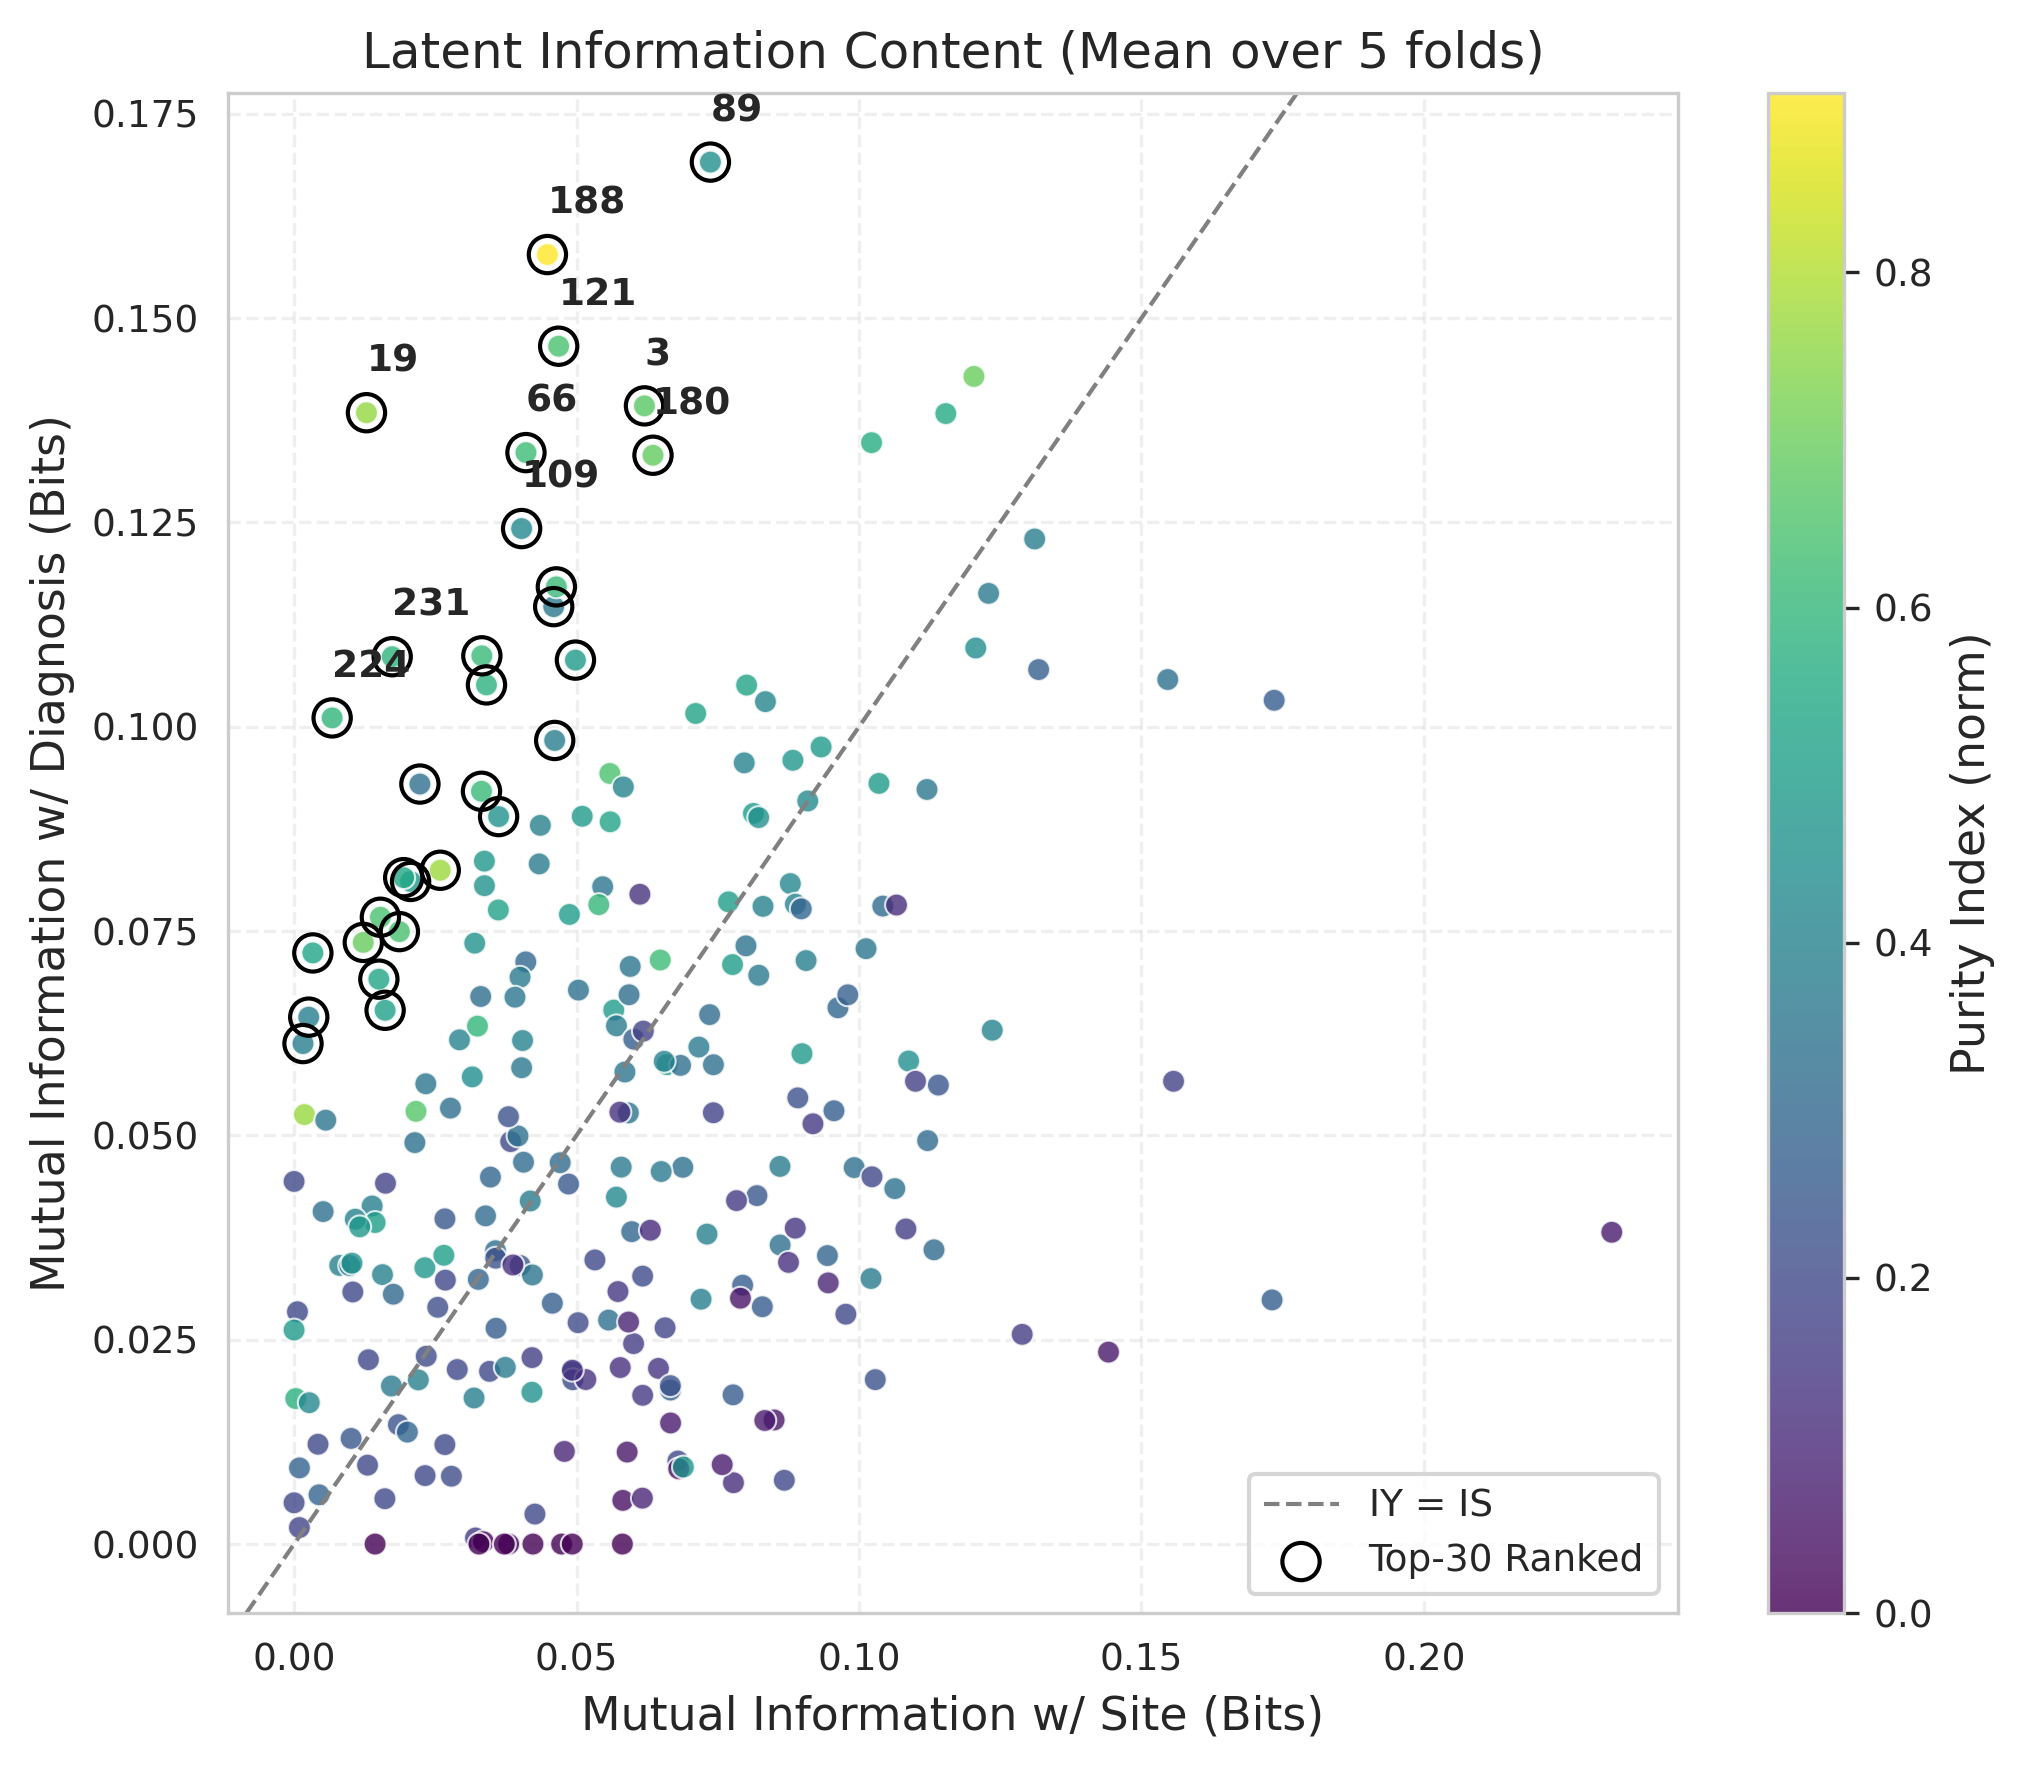

[OK] Figura guardada (Bits scale).


In [38]:
# ===================== CELDA IT-3 (CONT): AGG + STABILITY + EXPORT =====================
 
import pandas as pd

# mi_df viene de tu CELDA IT-3 (rows con fold, n_test, dim, IY_bits, IS_bits, IY_norm, IS_norm, diff_norm, purity_norm)
assert "mi_df" in globals() and isinstance(mi_df, pd.DataFrame)

OUTDIR = OUTPUT_FIG_DIR  # ya lo tenés
OUTDIR.mkdir(exist_ok=True)

# --- pesos: por defecto n_test; alternativa mejor para "capacidad de AUC" sería n_pairs = n_AD*n_CN (si lo guardás) ---
w = mi_df["n_test"].astype(float).values

def wavg_by_dim(col):
    x = mi_df[col].astype(float).values
    num = pd.Series(x * w).groupby(mi_df["dim"]).sum()
    den = pd.Series(w).groupby(mi_df["dim"]).sum()
    return (num / den).rename(f"{col}_wmean")

def mean_by_dim(col):
    return mi_df.groupby("dim")[col].mean().rename(f"{col}_mean")

def sd_by_dim(col):
    return mi_df.groupby("dim")[col].std(ddof=1).rename(f"{col}_sd")

# --- agregación principal (ponderada + sd entre folds) ---
agg = pd.concat([
    mi_df.groupby("dim")["dim"].size().rename("n_rows"),
    wavg_by_dim("IY_bits"),
    wavg_by_dim("IS_bits"),
    wavg_by_dim("IY_norm"),
    wavg_by_dim("IS_norm"),
    wavg_by_dim("diff_norm"),
    wavg_by_dim("purity_norm"),
    sd_by_dim("IY_bits"),
    sd_by_dim("IS_bits"),
    sd_by_dim("IY_norm"),
    sd_by_dim("IS_norm"),
    sd_by_dim("diff_norm"),
    sd_by_dim("purity_norm"),
], axis=1).reset_index()

# --- ranking estabilidad: rank por fold y agregamos mean/sd rank ---
# rank 1 = mejor (diff_norm alto); purity alto como tie-break
mi_df2 = mi_df.copy()
mi_df2["rank_diff"] = mi_df2.groupby("fold")["diff_norm"].rank(ascending=False, method="average")
mi_df2["rank_purity"] = mi_df2.groupby("fold")["purity_norm"].rank(ascending=False, method="average")

rank_stats = (
    mi_df2.groupby("dim")[["rank_diff","rank_purity"]]
    .agg(["mean","std"])
)
rank_stats.columns = [f"{a}_{b}" for a,b in rank_stats.columns]
rank_stats = rank_stats.reset_index()

agg = agg.merge(rank_stats, on="dim", how="left")

# --- score final para ordenar dims: diff_norm_wmean (principal) + purity_norm_wmean (secundario) ---
agg = agg.sort_values(
    ["diff_norm_wmean", "purity_norm_wmean", "IY_norm_wmean"],
    ascending=[False, False, False]
).reset_index(drop=True)

# --- top dims (para inspección y para usar en ablation/selección) ---
TOPK = 30
top_dims = agg.head(TOPK).copy()

print("=== TOP DIMS (biological > site) ===")
display(top_dims[[
    "dim",
    "diff_norm_wmean", "purity_norm_wmean",
    "IY_norm_wmean", "IS_norm_wmean",
    "IY_bits_wmean", "IS_bits_wmean",
    "rank_diff_mean", "rank_diff_std"
]].round(4))

# --- export ---
csv_all = OUTDIR / "table_latent_dim_MI_rank_all.csv"
csv_top = OUTDIR / f"table_latent_dim_MI_rank_top{TOPK}.csv"
tex_top = OUTDIR / f"table_latent_dim_MI_rank_top{TOPK}.tex"

agg.to_csv(csv_all, index=False)
top_dims.to_csv(csv_top, index=False)
with open(tex_top, "w") as f:
    f.write(top_dims.round(4).to_latex(index=False, escape=False))

print(f"[OK] Export:\n  {csv_all}\n  {csv_top}\n  {tex_top}")

# --- plot diagnóstico simple (sin seaborn): IY (Bits) vs IS (Bits) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

# Scatter principal: Ejes en BITS, Color por PUREZA
sc = plt.scatter(
    agg["IS_bits_wmean"], 
    agg["IY_bits_wmean"], 
    c=agg["purity_norm_wmean"], 
    cmap="viridis", 
    s=30, 
    alpha=0.8,
    edgecolors="white",
    linewidth=0.5
)
plt.colorbar(sc, label="Purity Index (norm)")

# Línea de referencia (Información igual para ambos)
plt.axline((0,0), slope=1.0, linestyle="--", linewidth=1, color="gray", label="IY = IS")

# Resaltar Top-10 dimensiones (Círculo negro alrededor)
plt.scatter(
    top_dims["IS_bits_wmean"], 
    top_dims["IY_bits_wmean"], 
    s=80, 
    facecolors='none', 
    edgecolors='black', 
    label="Top-30 Ranked"
)

# Etiquetar las Top-10 numéricamente
for _, r in top_dims.head(10).iterrows():
    plt.text(
        r["IS_bits_wmean"], 
        r["IY_bits_wmean"] + 0.005, # pequeño offset vertical
        str(int(r["dim"])), 
        fontsize=9, 
        fontweight='bold'
    )

plt.xlabel("Mutual Information w/ Site (Bits)")
plt.ylabel("Mutual Information w/ Diagnosis (Bits)")
plt.title(f"Latent Information Content (Mean over {N_FOLDS} folds)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig(OUTDIR / "figure_latent_dim_mi_scatter_bits.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTDIR / "figure_latent_dim_mi_scatter_bits.pdf", bbox_inches="tight")
plt.show()
print("[OK] Figura guardada (Bits scale).")


In [39]:
# ===================== CELDA IT-3b (CORREGIDA): VISUALIZACIÓN DE DESENTRELAZAMIENTO =====================
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Asegúrate de haber corrido IT-3 primero para tener 'mi_mean'
if "mi_mean" not in globals():
    raise ValueError("Ejecuta primero la CELDA IT-3 para obtener el dataframe 'mi_mean'.")

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# --- AJUSTE DE COLUMNAS PARA LA VERSIÓN ROBUSTA ---
# Usamos las versiones _w (weighted average across folds)
x = mi_mean["IS_bits_w"]  # Eje X: Info de Sitio (Malo)
y = mi_mean["IY_bits_w"]  # Eje Y: Info de Diagnóstico (Bueno)
z_dims = mi_mean["dim"]

# Para el color usamos 'purity_norm_w' (0 a 1) en lugar del ratio crudo que explotaba
color_metric = mi_mean["purity_norm_w"] 

# Scatter plot
scatter = plt.scatter(x, y, c=color_metric, cmap="viridis", s=100, edgecolors="k", alpha=0.8)
cbar = plt.colorbar(scatter)
cbar.set_label("Purity (Info AD / Total Info)", rotation=270, labelpad=15)

# Líneas de referencia (umbrales empíricos)
plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.3, label="Min Info AD (Signal)")
plt.axvline(x=0.05, color='gray', linestyle='--', alpha=0.3, label="Max Info Site (Noise)")

# Etiquetas para los mejores puntos (Top purity/diff)
texts = []
# Tomamos los 15 primeros del ranking (que ya viene ordenado por calidad en IT-3)
top_dims = mi_mean.head(15)  
for _, row in top_dims.iterrows():
    texts.append(plt.text(
        row["IS_bits_w"], 
        row["IY_bits_w"], 
        str(int(row["dim"])), 
        fontsize=9, fontweight='bold'
    ))

# Etiquetas para los "Culpables" (Alto Y, pero MUY Alto S)
# Filtramos dims con mucha info de AD (>0.05) pero demasiada info de sitio (>0.08)
bad_dims = mi_mean[(mi_mean["IY_bits_w"] > 0.05) & (mi_mean["IS_bits_w"] > 0.08)].head(5)
for _, row in bad_dims.iterrows():
    texts.append(plt.text(
        row["IS_bits_w"], 
        row["IY_bits_w"], 
        f"X-{int(row['dim'])}", 
        color='red', fontsize=9
    ))

try:
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
except Exception as e:
    print(f"[WARN] No se pudo ajustar texto automáticamente: {e}")

plt.title("Latent Space Disentanglement: Biology vs. Batch Effects", fontsize=14)
plt.xlabel("Mutual Information w/ SITE (Bits) -> El sesgo", fontsize=12)
plt.ylabel("Mutual Information w/ DIAGNOSIS (Bits) -> La señal", fontsize=12)
plt.legend(loc='lower right')

out_plot = OUTPUT_FIG_DIR / "figure_latent_disentanglement_robust.png"
plt.savefig(out_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"[ANALYSIS] Interpretación:")
print("1. Eje Y (Vertical): Cuánto ayuda esta dimensión a predecir Alzheimer.")
print("2. Eje X (Horizontal): Cuánto 'trampa' hace usando el Sitio.")
print("3. Color (Pureza): Amarillo = Muy limpia, Violeta = Muy sucia.")
print("-> BUSCAMOS: Puntos en la esquina superior izquierda (Alto Y, Bajo X).")
print(f"[OK] Guardado en: {out_plot}")

[ANALYSIS] Interpretación:
1. Eje Y (Vertical): Cuánto ayuda esta dimensión a predecir Alzheimer.
2. Eje X (Horizontal): Cuánto 'trampa' hace usando el Sitio.
3. Color (Pureza): Amarillo = Muy limpia, Violeta = Muy sucia.
-> BUSCAMOS: Puntos en la esquina superior izquierda (Alto Y, Bajo X).
[OK] Guardado en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_latent_disentanglement_robust.png


In [40]:
# ==============================================================================
# === CELDA 9 (FINAL): QC Latente Completo (TC Robusta + PR + Silhouette + Leakage) ===
# ==============================================================================
 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# --- Helpers ---
def participation_ratio(evals):
    """Calcula la dimensión intrínseca efectiva (PR)."""
    ev = np.asarray(evals, dtype=float)
    ev = ev[ev > 0]
    if ev.size == 0: return np.nan
    s1, s2 = ev.sum(), np.square(ev).sum()
    return (s1*s1)/s2

def total_correlation_gauss(Z):
    """
    Calcula la Total Correlation (TC) asumiendo normalidad.
    CORRECCIÓN: Estandariza Z primero para usar Matriz de Correlación.
    TC = Sum(H(z_i)) - H(Z) = -0.5 * log(det(CorrelationMatrix))
    """
    # 1. Estandarizar para eliminar el efecto de la escala (varianza)
    # y quedarnos solo con la dependencia (correlación).
    scaler = StandardScaler()
    Z_std = scaler.fit_transform(Z)
    
    # 2. Matriz de Covarianza sobre datos estandarizados = Matriz de Correlación
    cov = np.cov(Z_std, rowvar=False)
    N_dim = cov.shape[0]
    
    # 3. Regularización mínima (Ridge) para estabilidad numérica
    eps = 1e-6
    cov_reg = cov + eps * np.eye(N_dim)
    
    # 4. Cálculo vía Autovalores (más estable que np.linalg.det directo)
    # TC = 0.5 * (Sum(log(var_i)) - Sum(log(eigvals)))
    # Como var_i ~ 1 (por estandarización), Sum(log(var_i)) ~ 0.
    # TC ≈ -0.5 * Sum(log(eigvals))
    
    eigvals = np.linalg.eigvalsh(cov_reg)
    # Filtrar autovalores muy pequeños por seguridad numérica
    eigvals = eigvals[eigvals > 1e-12]
    
    log_det = np.sum(np.log(eigvals))
    log_sum_marginals = np.sum(np.log(np.diag(cov_reg))) # Será muy cercano a 0
    
    tc_nats = 0.5 * (log_sum_marginals - log_det)
    return max(0.0, tc_nats / np.log(2)) # Retorno en bits

def clean_confounder_label(s):
    if pd.isna(s): return 'Unknown'
    return str(s).replace(' Medical Systems','').replace(' Healthcare','').strip()

# --- Main Loop ---
if 'all_fold_data' not in globals():
    raise ValueError("⚠️ Faltan datos: Ejecuta la CELDA 8 primero para generar 'all_fold_data'.")

print(f"Calculando Métricas Avanzadas (TC Corregida, PR, Leakage) sobre {len(all_fold_data)} folds...")
rows = []

for fold_i, df_fold in enumerate(all_fold_data, start=1):
    # Datos latentes
    Z = np.vstack(df_fold['embeddings'].values)
    y_diag = df_fold['ResearchGroup_Mapped'].values
    
    # Identificar confounder (Manufacturer > Site3)
    mf_cols = [c for c in df_fold.columns if "Manufacturer" in c]
    manufacturer_col = mf_cols[0] if mf_cols else "Site3"
    y_conf = pd.Series(df_fold[manufacturer_col].map(clean_confounder_label))

    # A. Total Correlation (Independencia) - AHORA ROBUSTA
    tc_bits = total_correlation_gauss(Z)

    # B. Dimensionality (PR & PCA90)
    # Estandarizamos Z para PCA/PR (escala común)
    Zstd = StandardScaler().fit_transform(Z)
    pca_full = PCA(svd_solver="full", random_state=42).fit(Zstd)
    ev = pca_full.explained_variance_
    pr = participation_ratio(ev)
    dims90 = int(np.searchsorted(np.cumsum(pca_full.explained_variance_ratio_), 0.90) + 1)

    # C. Silhouette (Separabilidad Biológica)
    # Usamos las primeras 20 PCs para reducir ruido, standard practice
    Z_pca20 = pca_full.transform(Zstd)[:, :20]
    try:
        sil = silhouette_score(Z_pca20, y_diag)
    except:
        sil = np.nan

    # D. Leakage (Confounder Decodability)
    # kNN simple para ver si el fabricante es obvio
    counts = y_conf.value_counts()
    keep = y_conf.map(counts) >= 2
    acc_leak = np.nan
    
    # Solo calculamos si hay al menos 2 clases con suficientes muestras
    if keep.sum() > 10 and y_conf[keep].nunique() > 1:
        knn = KNeighborsClassifier(n_neighbors=5)
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        try:
            # Evaluamos leakage sobre Z estandarizado para ser justos
            scores = cross_val_score(knn, Zstd[keep], y_conf[keep], cv=cv, scoring='balanced_accuracy')
            acc_leak = scores.mean()
        except:
            pass

    rows.append({
        "Fold": fold_i,
        "TC (bits)": tc_bits,
        "Eff. Dim (PR)": pr,
        "PCA90": dims90,
        "Silhouette (Diag)": sil,
        "Leakage (Manuf. BA)": acc_leak
    })

# --- Reporte ---
qc_df = pd.DataFrame(rows)
print("\n=== Latent Space Quality Control (Mean ± SD) ===")
summary = qc_df.iloc[:, 1:].agg(['mean', 'std']).T
display(summary.round(3))

# Export
out_path = OUTPUT_FIG_DIR / "qc_latent_metrics_enhanced.csv"
qc_df.to_csv(out_path, index=False)
print(f"[OK] Tabla guardada: {out_path}")

# LaTeX para el paper (Table S1)
cols_tex = ["TC (bits)", "Eff. Dim (PR)", "Silhouette (Diag)", "Leakage (Manuf. BA)"]
with open(OUTPUT_FIG_DIR / "table_s1_latent_qc.tex", "w") as f:
    f.write(qc_df[cols_tex].agg(['mean', 'std']).T.round(3).to_latex())
    
print("[INFO] Valores Esperados:")
print(" - TC (bits): 10-100 (Independencia)")
print(" - PR: ~10-20 (Dimensionalidad Efectiva)")
print(" - Silhouette: > 0.0 (Separabilidad)")
print(" - Leakage: ~0.33 (Chance) a <0.6 (Buen desentrelazamiento)")

Calculando Métricas Avanzadas (TC Corregida, PR, Leakage) sobre 5 folds...

=== Latent Space Quality Control (Mean ± SD) ===


mean    std
TC (bits)            2161.483  5.396
Eff. Dim (PR)          17.739  0.195
PCA90                  22.200  0.447
Silhouette (Diag)       0.022  0.008
Leakage (Manuf. BA)     0.580  0.132

[OK] Tabla guardada: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/qc_latent_metrics_enhanced.csv
[INFO] Valores Esperados:
 - TC (bits): 10-100 (Independencia)
 - PR: ~10-20 (Dimensionalidad Efectiva)
 - Silhouette: > 0.0 (Separabilidad)
 - Leakage: ~0.33 (Chance) a <0.6 (Buen desentrelazamiento)


In [41]:
# ==============================================================================
# === CELDA 10: DEMOGRAPHIC DECODABILITY (AGE / SEX) [TRAIN -> TEST por fold] ===
# ==============================================================================

 
import pandas as pd
import torch
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import r2_score, balanced_accuracy_score, roc_auc_score

# --- Checks ---
if "run_args" not in globals():
    raise ValueError("⚠️ Falta run_args. Ejecutá la CELDA 1c.")
if "metadata_df_full" not in globals() or metadata_df_full is None:
    raise ValueError("⚠️ Falta metadata_df_full alineada. Ejecutá la CELDA X.")
if "global_tensor_data" not in globals():
    raise ValueError("⚠️ Falta global_tensor_data.")
try:
    from betavae_xai.models.convolutional_vae import ConvolutionalVAE
except ImportError:
    from src.betavae_xai.models.convolutional_vae import ConvolutionalVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helpers norm ---
def apply_norm_inference(tensor_mv, params_list):
    C, H, W = tensor_mv.shape
    out = tensor_mv.copy()
    mask = ~np.eye(H, dtype=bool)
    for c in range(C):
        p = params_list[c]
        if p.get("no_scale", False):
            continue
        vals = tensor_mv[c]
        mode = p.get("mode", None)
        if mode == "zscore_offdiag":
            std = float(p.get("std", 0.0))
            if std > 1e-9:
                out[c, mask] = (vals[mask] - float(p.get("mean", 0.0))) / std
            else:
                out[c, mask] = 0.0
        elif mode == "minmax_offdiag":
            vmin = float(p.get("min", 0.0))
            vmax = float(p.get("max", 1.0))
            rng = vmax - vmin
            if rng > 1e-9:
                out[c, mask] = (vals[mask] - vmin) / rng
            else:
                out[c, mask] = 0.0
    return out

def apply_norm_batch(tensor_4d, params_list):
    out = np.empty_like(tensor_4d)
    for i in range(tensor_4d.shape[0]):
        out[i] = apply_norm_inference(tensor_4d[i], params_list)
    return out

# --- CN/AD (orden tensor-aligned) ---
cn_ad_df = metadata_df_full[metadata_df_full["ResearchGroup_Mapped"].isin(["CN", "AD"])].copy()
cn_ad_df = cn_ad_df.reset_index(drop=True)
N = len(cn_ad_df)
print("[INFO] CN/AD N =", N)

# --- Sex encoding robusta ---
def encode_sex(s):
    if pd.isna(s):
        return np.nan
    ss = str(s).strip().upper()
    if ss in {"M", "MALE", "H", "HOMBRE"}:
        return 1
    if ss in {"F", "FEMALE", "MUJER"}:
        return 0
    return np.nan

rows = []

for fold_i in range(1, N_FOLDS + 1):
    fold_dir = RESULTS_DIR / f"fold_{fold_i}"

    test_idx = np.load(fold_dir / "test_indices.npy")
    train_idx = np.setdiff1d(np.arange(N), test_idx)

    df_train = cn_ad_df.iloc[train_idx].copy()
    df_test  = cn_ad_df.iloc[test_idx].copy()

    # cargar VAE + norm params
    CH = run_args["channels_to_use"]
    norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

    vae = ConvolutionalVAE(
        input_channels=len(CH),
        latent_dim=run_args["latent_dim"],
        image_size=global_tensor_data.shape[-1],
        num_conv_layers_encoder=run_args["num_conv_layers_encoder"],
        decoder_type=run_args["decoder_type"],
        final_activation=run_args["vae_final_activation"],
        intermediate_fc_dim_config=run_args["intermediate_fc_dim_vae"],
        dropout_rate=run_args["dropout_rate_vae"],
        use_layernorm_fc=run_args["use_layernorm_vae_fc"],
    ).to(device)

    ckpt = fold_dir / f"vae_model_fold_{fold_i}.pt"
    vae.load_state_dict(torch.load(ckpt, map_location=device))
    vae.eval()

    def get_mu(df_part):
        tens = global_tensor_data[df_part["tensor_idx"].values][:, CH, :, :]
        tens_norm = apply_norm_batch(tens, norm_params)
        with torch.no_grad():
            t = torch.from_numpy(tens_norm).float().to(device)
            mu, _ = vae.encode(t)
        return mu.cpu().numpy()

    Xtr = get_mu(df_train)
    Xte = get_mu(df_test)

    # --- AGE: Ridge (train->test) ---
    y_age_tr = df_train["Age"].astype(float).values if "Age" in df_train.columns else None
    y_age_te = df_test["Age"].astype(float).values if "Age" in df_test.columns else None

    r2_age = np.nan
    if y_age_tr is not None and np.isfinite(y_age_tr).all() and np.isfinite(y_age_te).all():
        age_model = Pipeline([("scaler", StandardScaler()), ("reg", Ridge(alpha=1.0))])
        age_model.fit(Xtr, y_age_tr)
        y_age_pred = age_model.predict(Xte)
        r2_age = r2_score(y_age_te, y_age_pred)

    # --- SEX: Logistic (train->test), report BA + AUC ---
    sex_tr = np.array([encode_sex(s) for s in df_train["Sex"].values]) if "Sex" in df_train.columns else None
    sex_te = np.array([encode_sex(s) for s in df_test["Sex"].values]) if "Sex" in df_test.columns else None

    ba_sex = np.nan
    auc_sex = np.nan
    if sex_tr is not None and np.isfinite(sex_tr).all() and np.isfinite(sex_te).all():
        sex_model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced"))
        ])
        sex_model.fit(Xtr, sex_tr)
        pred = sex_model.predict(Xte)
        prob = sex_model.predict_proba(Xte)[:, 1]

        ba_sex = balanced_accuracy_score(sex_te, pred)
        # AUC definido si hay ambas clases en test
        if len(np.unique(sex_te)) == 2:
            auc_sex = roc_auc_score(sex_te, prob)

    rows.append({
        "Fold": fold_i,
        "Age_R2_test": r2_age,
        "Sex_BA_test": ba_sex,
        "Sex_AUC_test": auc_sex,
        "n_test": len(df_test),
    })

demo_df = pd.DataFrame(rows)

print("\n=== DEMOGRAPHIC DECODABILITY (Train -> Test) ===")
display(demo_df.round(3))

# Resumen mean ± sd
summary = demo_df[["Age_R2_test", "Sex_BA_test", "Sex_AUC_test"]].agg(["mean", "std"]).T
summary.columns = ["mean", "sd"]
display(summary.round(3))

# Export
out_csv = OUTPUT_FIG_DIR / "table_demographic_decodability_train2test.csv"
out_tex = OUTPUT_FIG_DIR / "table_demographic_decodability_train2test.tex"
demo_df.to_csv(out_csv, index=False)
with open(out_tex, "w") as f:
    f.write(demo_df.to_latex(index=False, float_format="%.3f", column_format="ccccc", escape=False))

print(f"[OK] Guardado:\n  {out_csv}\n  {out_tex}")


[INFO] CN/AD N = 183

=== DEMOGRAPHIC DECODABILITY (Train -> Test) ===


Fold  Age_R2_test  Sex_BA_test  Sex_AUC_test  n_test
0     1       -0.195        0.596         0.675      37
1     2       -0.160        0.756         0.781      37
2     3       -0.355        0.760         0.769      37
3     4        0.220        0.556         0.642      36
4     5       -0.593        0.583         0.694      36

mean     sd
Age_R2_test  -0.217  0.298
Sex_BA_test   0.650  0.099
Sex_AUC_test  0.712  0.060

[OK] Guardado:
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_demographic_decodability_train2test.csv
  /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/table_demographic_decodability_train2test.tex


In [42]:
# ===================== CELDA 11: TEST ESTADÍSTICO ENTRE CLASIFICADORES =====================
from scipy.stats import wilcoxon, friedmanchisquare

# Cargar todos los clasificadores del joblib
try:
    pred_joblib_path = next(RESULTS_DIR.glob("all_folds_clf_predictions_MULTI_*.joblib"))
    all_preds_data = joblib.load(pred_joblib_path)
except:
    raise FileNotFoundError("Faltan las predicciones.")

# Organizar AUCs por fold y clasificador
results_by_fold = {}
for item in all_preds_data:
    clf_name = item['classifier']
    fold = item['fold']
    df = item['predictions_df']
    auc = roc_auc_score(df['y_true'], df['y_score'])
    
    if clf_name not in results_by_fold:
        results_by_fold[clf_name] = []
    results_by_fold[clf_name].append(auc)

print("--- Comparación de AUCs por Fold ---")
scores_df = pd.DataFrame(results_by_fold)
display(scores_df)

# Test de Friedman (si hay >2 modelos)
if len(scores_df.columns) > 2:
    stat, p = friedmanchisquare(*[scores_df[c] for c in scores_df.columns])
    print(f"\nFriedman Test: Statistic={stat:.3f}, p-value={p:.4f}")
    if p < 0.05:
        print(">> Hay diferencias significativas entre los modelos.")
    else:
        print(">> No hay diferencias significativas detectables con N=5 folds.")

# Comparación directa LogReg vs El Segundo Mejor (ej. SVM)
# Ajusta 'svm' o 'xgb' según quien sea el rival
rival = 'svm' 
if rival in scores_df.columns and TARGET_CLF in scores_df.columns:
    stat, p = wilcoxon(scores_df[TARGET_CLF], scores_df[rival])
    print(f"\nWilcoxon Signed-Rank Test ({TARGET_CLF} vs {rival}):")
    print(f"  p-value = {p:.4f}")

--- Comparación de AUCs por Fold ---


svm    logreg
0  0.888889  0.883041
1  0.836257  0.833333
2  0.827485  0.842105
3  0.796296  0.783951
4  0.832817  0.835913


Wilcoxon Signed-Rank Test (logreg vs svm):
  p-value = 1.0000


[SETUP] Evaluando Full Space (256 dims) vs. Purified Space (30 dims)

[STATISTICS - Wilcoxon Signed-Rank Test]
Diagnosis AUC: p-value = 1.000 (Is signal preserved?)
Site Leakage:  p-value = 0.312 (Is noise reduced?)


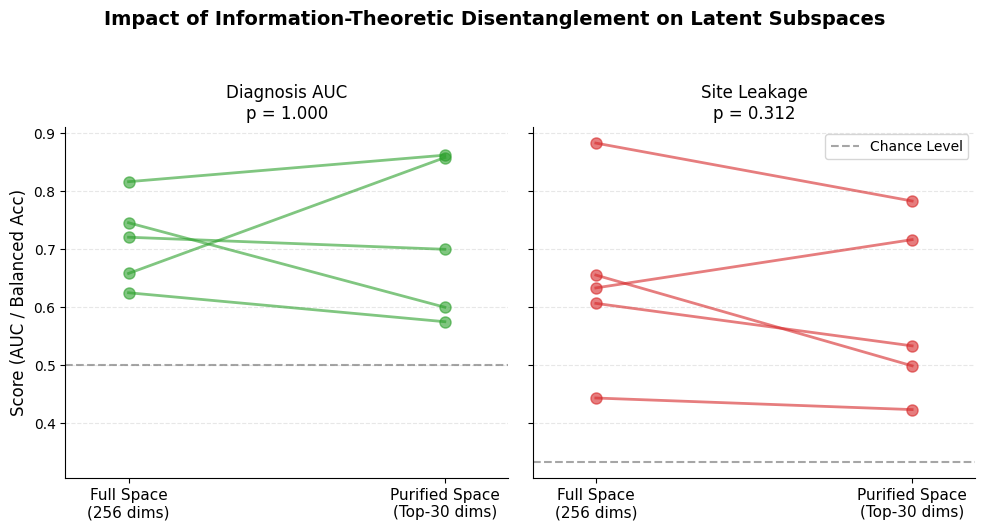

[OK] Gráfica de Ablation guardada en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_ablation_paired_slope.pdf


In [43]:
# ===================== CELDA 12 (ENHANCED PARA PAPER): ABLATION STUDY =====================
# HIPÓTESIS: Al purificar el espacio latente mediante Teoría de la Información,
# preservamos la señal biológica (AUC Diagnóstico) y destruimos el ruido (Leakage de Sitio).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import wilcoxon

# 1. Configuración
K_DIMS = 30  # Top-K dimensiones a retener
RANDOM_STATE = 42

if "mi_mean" not in globals():
    raise ValueError("Falta 'mi_mean'. Corre la celda IT-3 primero.")

# Obtener índices
ranked_dims = mi_mean.sort_values("diff_norm_w", ascending=False)
top_k_indices = ranked_dims.head(K_DIMS)["dim"].values

print(f"[SETUP] Evaluando Full Space (256 dims) vs. Purified Space ({K_DIMS} dims)")
results_ablation = []

# 2. Iterar por folds
for i, df_fold in enumerate(all_fold_data):
    fold_id = i + 1
    
    Z_full = np.vstack(df_fold["embeddings"].values)
    y_diag = df_fold["ResearchGroup_Mapped"].values
    
    site_raw = df_fold.get("Manufacturer", df_fold.get("Site3")).astype(str)
    valid_mask = site_raw.map(site_raw.value_counts()) > 1
    
    if valid_mask.sum() < 10:
        continue

    Z_pure = Z_full[:, top_k_indices]
    
    clf_diag = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced'))
    clf_site = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced'))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    # Full Space
    auc_full = cross_val_score(clf_diag, Z_full, y_diag, cv=cv, scoring='roc_auc').mean()
    leak_full = cross_val_score(clf_site, Z_full[valid_mask], site_raw[valid_mask], cv=cv, scoring='balanced_accuracy').mean()
    
    # Purified Space
    auc_pure = cross_val_score(clf_diag, Z_pure, y_diag, cv=cv, scoring='roc_auc').mean()
    leak_pure = cross_val_score(clf_site, Z_pure[valid_mask], site_raw[valid_mask], cv=cv, scoring='balanced_accuracy').mean()
    
    results_ablation.append({
        "Fold": fold_id, "Metric": "Diagnosis AUC", "Space": "Full Space", "Score": auc_full
    })
    results_ablation.append({
        "Fold": fold_id, "Metric": "Diagnosis AUC", "Space": "Purified Space", "Score": auc_pure
    })
    results_ablation.append({
        "Fold": fold_id, "Metric": "Site Leakage", "Space": "Full Space", "Score": leak_full
    })
    results_ablation.append({
        "Fold": fold_id, "Metric": "Site Leakage", "Space": "Purified Space", "Score": leak_pure
    })

df_ablation = pd.DataFrame(results_ablation)

# --- 3. Análisis Estadístico ---
# Separar datos para el test de Wilcoxon
auc_f = df_ablation[(df_ablation["Metric"] == "Diagnosis AUC") & (df_ablation["Space"] == "Full Space")]["Score"]
auc_p = df_ablation[(df_ablation["Metric"] == "Diagnosis AUC") & (df_ablation["Space"] == "Purified Space")]["Score"]
leak_f = df_ablation[(df_ablation["Metric"] == "Site Leakage") & (df_ablation["Space"] == "Full Space")]["Score"]
leak_p = df_ablation[(df_ablation["Metric"] == "Site Leakage") & (df_ablation["Space"] == "Purified Space")]["Score"]

_, pval_auc = wilcoxon(auc_f, auc_p)
_, pval_leak = wilcoxon(leak_f, leak_p)

print(f"\n[STATISTICS - Wilcoxon Signed-Rank Test]")
print(f"Diagnosis AUC: p-value = {pval_auc:.3f} (Is signal preserved?)")
print(f"Site Leakage:  p-value = {pval_leak:.3f} (Is noise reduced?)")

# --- 4. Visualización Paper-Grade (Paired Slope Chart) ---
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle("Impact of Information-Theoretic Disentanglement on Latent Subspaces", fontsize=14, fontweight='bold', y=1.05)

metrics = ["Diagnosis AUC", "Site Leakage"]
colors = {"Diagnosis AUC": "#2ca02c", "Site Leakage": "#d62728"}
p_values = [pval_auc, pval_leak]
chance_levels = [0.5, 0.333] # 0.5 para AUC binario, 0.33 para Leakage de 3 fabricantes

for i, ax in enumerate(axes):
    metric = metrics[i]
    color = colors[metric]
    subset = df_ablation[df_ablation["Metric"] == metric]
    
    # Extraer valores emparejados
    full_vals = subset[subset["Space"] == "Full Space"]["Score"].values
    pure_vals = subset[subset["Space"] == "Purified Space"]["Score"].values
    
    # Dibujar líneas para cada fold
    for f_val, p_val in zip(full_vals, pure_vals):
        ax.plot([0, 1], [f_val, p_val], marker='o', color=color, alpha=0.6, linewidth=2, markersize=8)
    
    # Línea de azar
    ax.axhline(chance_levels[i], color='gray', linestyle='--', alpha=0.7, label='Chance Level')
    
    # Configurar Ejes
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Full Space\n(256 dims)", f"Purified Space\n(Top-{K_DIMS} dims)"], fontsize=11)
    ax.set_title(f"{metric}\np = {p_values[i]:.3f}", fontsize=12)
    ax.set_xlim(-0.2, 1.2)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    if i == 0: ax.set_ylabel("Score (AUC / Balanced Acc)", fontsize=12)
    if i == 1: ax.legend(loc='upper right')

sns.despine()
plt.tight_layout()

# Guardar
out_plot = OUTPUT_FIG_DIR / "figure_ablation_paired_slope.pdf"
plt.savefig(out_plot, bbox_inches='tight')
plt.savefig(str(out_plot).replace('.pdf', '.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[OK] Gráfica de Ablation guardada en: {out_plot}")

In [44]:
# ===================== CELDA: GENERADOR DE TABLA 2 (LATEX) =====================
import pandas as pd
 
from pathlib import Path

# 1. Configuración
# Asegúrate de que RESULTS_DIR apunte a la carpeta correcta (ya definida en celdas anteriores)
# RESULTS_DIR = Path("/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_3channels_beta25") 

# Nombre del archivo de métricas (búscalo automáticamente o defínelo)
try:
    metrics_csv_path = next(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
    print(f"[OK] Archivo de métricas encontrado: {metrics_csv_path.name}")
except StopIteration:
    raise FileNotFoundError(f"No se encontró ningún archivo 'all_folds_metrics_MULTI_*.csv' en {RESULTS_DIR}")

# 2. Carga y Procesamiento
df_metrics = pd.read_csv(metrics_csv_path)

# Mapeo de nombres de clasificadores (del código a nombres bonitos para el paper)
clf_name_map = {
    'mlp': 'Multi-Layer Perceptron (MLP)',
    'logreg': 'Logistic Regression', # O 'Regularized Logistic Regression'
    'svm': 'Support Vector Machine (RBF-SVM)',
    'xgb': 'eXtreme Gradient Boosting (XGB)',
    'gb': 'Gradient Boosting',
    'rf': 'Random Forest'
}

# Métricas a reportar (en orden)
metrics_to_report = {
    'auc': 'ROC-AUC',
    'pr_auc': 'PR-AUC',
    'balanced_accuracy': 'Balanced Acc.',
    'sensitivity': 'Sensitivity',
    'specificity': 'Specificity',
    'f1_score': 'F1 Score'
}

# Agrupar por clasificador y calcular media y std
summary = df_metrics.groupby('actual_classifier_type')[list(metrics_to_report.keys())].agg(['mean', 'std'])

# 3. Formateo para LaTeX
# Función para crear el string "Media ± SD"
def format_mean_sd(row, metric):
    mean = row[(metric, 'mean')]
    std = row[(metric, 'std')]
    return f"{mean:.3f} $\\pm$ {std:.3f}"

# Crear tabla final
table_rows = []
for clf_code, clf_pretty_name in clf_name_map.items():
    if clf_code in summary.index:
        row_data = {'Model': clf_pretty_name}
        for metric_code, metric_name in metrics_to_report.items():
            row_data[metric_name] = format_mean_sd(summary.loc[clf_code], metric_code)
        table_rows.append(row_data)

df_table = pd.DataFrame(table_rows)

# Reordenar columnas (Model primero)
cols = ['Model'] + list(metrics_to_report.values())
df_table = df_table[cols]

# Destacar el mejor ROC-AUC en negrita (Opcional, pero útil)
best_auc_idx = df_metrics.groupby('actual_classifier_type')['auc'].mean().idxmax()
# Nota: La lógica de negrita automática en LaTeX es compleja desde pandas, 
# se suele hacer a mano o con funciones más avanzadas. 
# Aquí generamos la tabla limpia.

# 4. Exportar a LaTeX
latex_code = df_table.to_latex(
    index=False,
    column_format='l' + 'c' * len(metrics_to_report), # 'l' para Modelo, 'c' para métricas
    header=True,
    escape=False # Para que no escape los símbolos $ de math mode
)

# Guardar en archivo
output_tex_path = RESULTS_DIR / "table_cv_performance_generated.tex"
with open(output_tex_path, "w") as f:
    f.write(latex_code)

print("\n--- Vista Previa de la Tabla ---")
display(df_table)
print(f"\n[OK] Código LaTeX guardado en: {output_tex_path}")
print("Copia el contenido de ese archivo en tu 'Final_version/Tables/table_cv_performance.tex'")

[OK] Archivo de métricas encontrado: all_folds_metrics_MULTI_svm_vaeconvtranspose4l_ld256_beta6.5_normzscore_offdiag_ch3sel_intFCquarter_drop0.15_ln0_outer5x1_scoreroc_auc.csv

--- Vista Previa de la Tabla ---


Model            ROC-AUC             PR-AUC  \
0               Logistic Regression  0.836 $\pm$ 0.035  0.862 $\pm$ 0.036   
1  Support Vector Machine (RBF-SVM)  0.836 $\pm$ 0.033  0.861 $\pm$ 0.033   

       Balanced Acc.        Sensitivity        Specificity           F1 Score  
0  0.737 $\pm$ 0.032  0.799 $\pm$ 0.119  0.674 $\pm$ 0.144  0.756 $\pm$ 0.037  
1  0.726 $\pm$ 0.048  0.768 $\pm$ 0.141  0.684 $\pm$ 0.168  0.740 $\pm$ 0.056


[OK] Código LaTeX guardado en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65/table_cv_performance_generated.tex
Copia el contenido de ese archivo en tu 'Final_version/Tables/table_cv_performance.tex'


In [45]:
# ==============================================================================
# CELDA 1d — QC de distribución: percentiles + masa fuera de [-1,1] (raw vs norm)
# ==============================================================================

 
import pandas as pd
import joblib
from pathlib import Path

# ----------------------------
# Configuración (ajustable)
# ----------------------------
USE_CN_AD_ONLY = False      # True si querés mirar sólo CN/AD (requiere metadata_df_full)
N_SUBJ_SAMPLE = 250         # sujetos muestreados (tradeoff: más = más estable)
USE_UPPER_TRI = True        # True = solo triángulo superior (evita duplicados en simétricas)
SEED = 42

# Percentiles a reportar
PCTS = [0.1, 1, 5, 25, 50, 75, 95, 99, 99.9]

# Ranges para tail-mass
TAIL_THRESHOLDS = [1.0, 2.0, 3.0]

# ----------------------------
# Checks mínimos
# ----------------------------
if "run_args" not in globals():
    raise ValueError("⚠️ Falta run_args. Ejecutá la CELDA 1c.")
if "global_tensor_data" not in globals():
    raise ValueError("⚠️ Falta global_tensor_data. Ejecutá la celda que carga el NPZ.")
if "OUTPUT_FIG_DIR" not in globals():
    raise ValueError("⚠️ Falta OUTPUT_FIG_DIR.")

CH_IDXS = list(run_args["channels_to_use"])
N, C_all, H, W = global_tensor_data.shape
print(f"[INFO] global_tensor_data: N={N}, C={C_all}, H=W={H}")
print(f"[INFO] Channels_to_use (idx global): {CH_IDXS}")

# Nombres “humanos” (si ya los tenías, reutilizalos)
CHANNEL_NAME_MAP = {
    0: "Pearson_OMST_GCE_Signed_Weighted",
    1: "Pearson_Full_FisherZ_Signed",
    2: "MI_KNN_Symmetric",
    3: "dFC_AbsDiffMean",
    4: "dFC_StdDev",
    5: "DistanceCorr",
    6: "Granger_F_lag1",
}
CH_NAMES = [CHANNEL_NAME_MAP.get(i, f"Channel_{i}") for i in CH_IDXS]

# ----------------------------
# Pool de sujetos
# ----------------------------
rng = np.random.default_rng(SEED)

if USE_CN_AD_ONLY:
    if "metadata_df_full" not in globals() or metadata_df_full is None:
        raise ValueError("⚠️ USE_CN_AD_ONLY=True requiere metadata_df_full (CELDA X).")
    if "ResearchGroup_Mapped" not in metadata_df_full.columns:
        raise ValueError("⚠️ metadata_df_full no tiene ResearchGroup_Mapped.")
    pool = metadata_df_full[metadata_df_full["ResearchGroup_Mapped"].isin(["CN", "AD"])]["tensor_idx"].values
    pool = pool.astype(int)
    print(f"[INFO] Pool CN/AD: {len(pool)} sujetos")
else:
    pool = np.arange(N, dtype=int)
    print(f"[INFO] Pool ALL: {len(pool)} sujetos")

n_s = min(N_SUBJ_SAMPLE, len(pool))
subj_idx = rng.choice(pool, size=n_s, replace=False)

# ----------------------------
# Índices off-diag / upper-tri
# ----------------------------
if USE_UPPER_TRI:
    iu, ju = np.triu_indices(H, k=1)
else:
    # todos los off-diag (incluye upper+lower)
    mask = ~np.eye(H, dtype=bool)
    iu, ju = np.where(mask)

n_edges = len(iu)
print(f"[INFO] Usando {'upper-tri' if USE_UPPER_TRI else 'all off-diag'}: n_edges={n_edges}")

# ----------------------------
# Helpers
# ----------------------------
def compute_stats_1d(x: np.ndarray, pcts=PCTS, tails=TAIL_THRESHOLDS):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    out = {}
    out["n"] = int(x.size)
    if x.size == 0:
        return out

    out["min"] = float(np.min(x))
    out["max"] = float(np.max(x))
    out["mean"] = float(np.mean(x))
    out["std"] = float(np.std(x, ddof=1)) if x.size > 1 else 0.0

    # percentiles
    qs = np.percentile(x, pcts)
    for p, q in zip(pcts, qs):
        key = f"p{str(p).replace('.','p')}"
        out[key] = float(q)

    # tail mass (two-sided)
    ax = np.abs(x)
    for t in tails:
        out[f"frac_abs_gt_{t:g}"] = float(np.mean(ax > t))

    # “masa fuera de [-1,1]”
    out["frac_outside_pm1"] = float(np.mean((x < -1.0) | (x > 1.0)))
    return out

def get_raw_vals_for_channel(raw_subtensor: np.ndarray, ch_local: int):
    # raw_subtensor shape: (n_s, C_sel, H, W)
    v = raw_subtensor[:, ch_local, :, :]
    # extrae edges y aplana
    return v[:, iu, ju].reshape(-1)

def get_norm_vals_for_channel(raw_subtensor: np.ndarray, ch_local: int, norm_params_list: list):
    # zscore_offdiag sobre edges (según params del fold)
    p = norm_params_list[ch_local]
    if p.get("no_scale", False):
        # si no escala, norm==raw
        return get_raw_vals_for_channel(raw_subtensor, ch_local)

    mode = p.get("mode", None)
    v = raw_subtensor[:, ch_local, :, :][:, iu, ju]  # (n_s, n_edges)

    if mode == "zscore_offdiag":
        mu = float(p.get("mean", 0.0))
        sd = float(p.get("std", 1.0))
        if sd < 1e-9:
            return np.zeros(v.size, dtype=float)
        return ((v - mu) / sd).reshape(-1)

    if mode == "minmax_offdiag":
        vmin = float(p.get("min", 0.0))
        vmax = float(p.get("max", 1.0))
        rng_ = vmax - vmin
        if rng_ < 1e-9:
            return np.zeros(v.size, dtype=float)
        return ((v - vmin) / rng_).reshape(-1)

    # modo desconocido: devolvemos raw (pero avisamos)
    return v.reshape(-1)

# ----------------------------
# Loop folds: stats raw/norm por canal
# ----------------------------
rows = []
for fold_i in range(1, N_FOLDS + 1):
    fold_dir = RESULTS_DIR / f"fold_{fold_i}"
    norm_params_path = fold_dir / "vae_norm_params.joblib"
    if not norm_params_path.exists():
        print(f"[WARN] Fold {fold_i}: falta {norm_params_path.name} -> se omite.")
        continue

    norm_params_list = joblib.load(norm_params_path)

    # subtensor: (n_s, C_sel, H, W)
    raw_sub = global_tensor_data[subj_idx][:, CH_IDXS, :, :].astype(np.float32)

    for ch_local, ch_name in enumerate(CH_NAMES):
        raw_vals = get_raw_vals_for_channel(raw_sub, ch_local)
        norm_vals = get_norm_vals_for_channel(raw_sub, ch_local, norm_params_list)

        s_raw = compute_stats_1d(raw_vals)
        s_norm = compute_stats_1d(norm_vals)

        rows.append({"fold": fold_i, "stage": "raw",  "channel": ch_name, **s_raw})
        rows.append({"fold": fold_i, "stage": "norm", "channel": ch_name, **s_norm})

qc_tail_df = pd.DataFrame(rows)

# Ordenar columnas “lindo”
front = ["fold", "stage", "channel", "n", "min", "p0p1", "p1", "p5", "p25", "p50", "p75", "p95", "p99", "p99p9", "max",
         "mean", "std", "frac_outside_pm1"] + [f"frac_abs_gt_{t:g}" for t in TAIL_THRESHOLDS]
cols = [c for c in front if c in qc_tail_df.columns] + [c for c in qc_tail_df.columns if c not in front]
qc_tail_df = qc_tail_df[cols].sort_values(["stage", "channel", "fold"]).reset_index(drop=True)

display(qc_tail_df.head(12))

out_csv = OUTPUT_FIG_DIR / "qc_tailmass_percentiles_raw_vs_norm.csv"
qc_tail_df.to_csv(out_csv, index=False)
print(f"[OK] Guardado: {out_csv}")


[INFO] global_tensor_data: N=431, C=7, H=W=131
[INFO] Channels_to_use (idx global): [1, 0, 2]
[INFO] Pool ALL: 431 sujetos
[INFO] Usando upper-tri: n_edges=8515


fold stage                           channel        n       min      p0p1  \
0      1  norm                  MI_KNN_Symmetric  2128750 -5.602053 -3.357603   
1      2  norm                  MI_KNN_Symmetric  2128750 -5.632152 -3.376100   
2      3  norm                  MI_KNN_Symmetric  2128750 -5.610944 -3.363426   
3      4  norm                  MI_KNN_Symmetric  2128750 -5.612773 -3.365321   
4      5  norm                  MI_KNN_Symmetric  2128750 -5.611721 -3.361804   
5      1  norm       Pearson_Full_FisherZ_Signed  2128750 -6.459744 -4.174865   
6      2  norm       Pearson_Full_FisherZ_Signed  2128750 -6.501098 -4.202963   
7      3  norm       Pearson_Full_FisherZ_Signed  2128750 -6.511771 -4.210559   
8      4  norm       Pearson_Full_FisherZ_Signed  2128750 -6.489836 -4.196073   
9      5  norm       Pearson_Full_FisherZ_Signed  2128750 -6.470451 -4.181981   
10     1  norm  Pearson_OMST_GCE_Signed_Weighted  2128750 -0.283241 -0.283241   
11     2  norm  Pearson_OMST_GCE_Signed_Weighted  2128750 -0.283805 -0.283805   

          p1        p5       p25       p50  ...       p95       p99     p99p9  \
0  -2.179921 -1.452473 -0.650655 -0.069585  ...  1.659721  2.839707  4.917660   
1  -2.192331 -1.461122 -0.655160 -0.071087  ...  1.667159  2.853244  4.941938   
2  -2.184135 -1.455692 -0.652779 -0.070915  ...  1.660756  2.842353  4.923147   
3  -2.186065 -1.457644 -0.654754 -0.072907  ...  1.658713  2.840276  4.921008   
4  -2.181254 -1.452034 -0.648264 -0.065778  ...  1.667740  2.850599  4.933614   
5  -2.673863 -1.690432 -0.606456  0.063765  ...  1.511958  2.202144  3.262629   
6  -2.693252 -1.704116 -0.613852  0.060258  ...  1.516853  2.211042  3.277680   
7  -2.698828 -1.708368 -0.616644  0.058368  ...  1.516913  2.212031  3.280097   
8  -2.689236 -1.701982 -0.613792  0.059035  ...  1.512859  2.205727  3.270335   
9  -2.678620 -1.693644 -0.607965  0.063310  ...  1.513778  2.205048  3.267200   
10 -0.283241 -0.283241 -0.283241 -0.283241  ...  3.318321  4.081499  4.481749   
11 -0.283805 -0.283805 -0.283805 -0.283805  ...  3.298738  4.057888  4.456024   

          max      mean       std  frac_outside_pm1  frac_abs_gt_1  \
0    9.978908 -0.004926  0.994651          0.270527       0.270527   
1   10.029348 -0.006093  0.999792          0.272986       0.272986   
2    9.991313 -0.006167  0.996010          0.271251       0.271251   
3    9.989024 -0.008161  0.995981          0.271333       0.271333   
4   10.007189 -0.000961  0.997073          0.271400       0.271400   
5    6.548345  0.004306  0.996603          0.292039       0.292039   
6    6.582458  0.000453  1.002385          0.294650       0.294650   
7    6.589298 -0.001516  1.003726          0.295187       0.295187   
8    6.568825 -0.000655  1.000478          0.293713       0.293713   
9    6.558078  0.003757  0.998169          0.292746       0.292746   
10   5.348136  0.005323  1.015657          0.075967       0.075967   
11   5.317836  0.003236  1.010294          0.075967       0.075967   

    frac_abs_gt_2  frac_abs_gt_3  
0        0.045005       0.010338  
1        0.045786       0.010548  
2        0.045191       0.010389  
3        0.045177       0.010376  
4        0.045427       0.010457  
5        0.046070       0.007378  
6        0.047141       0.007641  
7        0.047404       0.007720  
8        0.046806       0.007572  
9        0.046345       0.007442  
10       0.075698       0.065209  
11       0.075680       0.064603  

[12 rows x 21 columns]

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/qc_tailmass_percentiles_raw_vs_norm.csv


In [46]:
# ==============================================================================
# CELDA 1e — Histogramas para inspección visual (raw vs norm) y umbrales ±1
# ==============================================================================

import matplotlib.pyplot as plt

if "qc_tail_df" not in globals():
    # si ejecutaste la celda 1d, debería existir; si no, recargamos del csv
    qc_path = OUTPUT_FIG_DIR / "qc_tailmass_percentiles_raw_vs_norm.csv"
    if qc_path.exists():
        qc_tail_df = pd.read_csv(qc_path)
    else:
        raise ValueError("⚠️ No encuentro qc_tail_df ni el CSV. Ejecutá la CELDA 1d.")

# Re-muestrear valores para histogramas (usamos el mismo muestreo de la celda 1d si existe)
# Si querés “exactamente” el mismo vector, conviene guardar los samples; acá re-muestreo igual.
USE_CN_AD_ONLY = False
N_SUBJ_SAMPLE = 250
USE_UPPER_TRI = True
SEED = 42

rng = np.random.default_rng(SEED)
N, C_all, H, W = global_tensor_data.shape
CH_IDXS = list(run_args["channels_to_use"])
CH_NAMES = [CHANNEL_NAME_MAP.get(i, f"Channel_{i}") for i in CH_IDXS]

if USE_CN_AD_ONLY:
    pool = metadata_df_full[metadata_df_full["ResearchGroup_Mapped"].isin(["CN","AD"])]["tensor_idx"].values.astype(int)
else:
    pool = np.arange(N, dtype=int)

subj_idx = rng.choice(pool, size=min(N_SUBJ_SAMPLE, len(pool)), replace=False)

if USE_UPPER_TRI:
    iu, ju = np.triu_indices(H, k=1)
else:
    mask = ~np.eye(H, dtype=bool)
    iu, ju = np.where(mask)

def sample_vectors_for_fold(fold_i: int):
    fold_dir = RESULTS_DIR / f"fold_{fold_i}"
    norm_params_list = joblib.load(fold_dir / "vae_norm_params.joblib")
    raw_sub = global_tensor_data[subj_idx][:, CH_IDXS, :, :].astype(np.float32)

    out = {}
    for ch_local, ch_name in enumerate(CH_NAMES):
        raw_vals = raw_sub[:, ch_local, :, :][:, iu, ju].reshape(-1)

        p = norm_params_list[ch_local]
        mode = p.get("mode", None)
        if p.get("no_scale", False):
            norm_vals = raw_vals.copy()
        elif mode == "zscore_offdiag":
            mu = float(p.get("mean", 0.0)); sd = float(p.get("std", 1.0))
            norm_vals = ((raw_sub[:, ch_local, :, :][:, iu, ju] - mu) / max(sd, 1e-9)).reshape(-1)
        elif mode == "minmax_offdiag":
            vmin = float(p.get("min", 0.0)); vmax = float(p.get("max", 1.0))
            norm_vals = ((raw_sub[:, ch_local, :, :][:, iu, ju] - vmin) / max(vmax - vmin, 1e-9)).reshape(-1)
        else:
            norm_vals = raw_sub[:, ch_local, :, :][:, iu, ju].reshape(-1)

        out[ch_name] = {"raw": raw_vals, "norm": norm_vals}
    return out

# Elegí un fold representativo (o el best/worst si querés)
FOLD_FOR_HIST = 1
vecs = sample_vectors_for_fold(FOLD_FOR_HIST)

# Figura: un panel por canal, raw vs norm (dos subplots por canal)
nch = len(CH_NAMES)
fig, axes = plt.subplots(nch, 2, figsize=(10, 3.0*nch), constrained_layout=True)

if nch == 1:
    axes = np.array([axes])

for i, ch in enumerate(CH_NAMES):
    for j, stage in enumerate(["raw", "norm"]):
        ax = axes[i, j]
        x = vecs[ch][stage]
        x = x[np.isfinite(x)]

        # bins robustos
        lo, hi = np.percentile(x, [0.5, 99.5])
        ax.hist(x, bins=120, range=(lo, hi), density=True)

        ax.axvline(-1, linestyle="--")
        ax.axvline(+1, linestyle="--")
        ax.set_title(f"{ch} | {stage} | Fold {FOLD_FOR_HIST}")
        ax.set_xlabel("Value (off-diagonal)")
        ax.set_ylabel("Density")

plt.savefig(OUTPUT_FIG_DIR / f"figure_hist_raw_vs_norm_fold{FOLD_FOR_HIST}.pdf", bbox_inches="tight")
plt.savefig(OUTPUT_FIG_DIR / f"figure_hist_raw_vs_norm_fold{FOLD_FOR_HIST}.png", dpi=300, bbox_inches="tight")
plt.show()

print("[OK] Histogramas guardados en training_qc/")


[OK] Histogramas guardados en training_qc/


In [47]:
# ==============================================================================
# CELDA 1f — Recon QC: saturación del linear (|recon|>0.95 / 0.99) + percentiles
# ==============================================================================

import sys
import torch
 
import pandas as pd
import joblib
from pathlib import Path

# ---- Parámetros ----
FOLD_RECON_QC = 1
N_SUBJ_SAMPLE = 120      # recon requiere forward -> más chico
USE_UPPER_TRI = True
SEED = 123

# ---- Checks ----
if "run_args" not in globals():
    raise ValueError("⚠️ Falta run_args.")
if "global_tensor_data" not in globals():
    raise ValueError("⚠️ Falta global_tensor_data.")
if "RESULTS_DIR" not in globals():
    raise ValueError("⚠️ Falta RESULTS_DIR.")

# ---- Imports del repo ----
project_root = Path.cwd().resolve().parent
src_dir = project_root / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

try:
    from betavae_xai.models.convolutional_vae import ConvolutionalVAE
except ImportError:
    from src.betavae_xai.models.convolutional_vae import ConvolutionalVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Muestreo de sujetos ----
rng = np.random.default_rng(SEED)
N, C_all, H, W = global_tensor_data.shape
CH_IDXS = list(run_args["channels_to_use"])
CH_NAMES = [CHANNEL_NAME_MAP.get(i, f"Channel_{i}") for i in CH_IDXS]

subj_idx = rng.choice(np.arange(N), size=min(N_SUBJ_SAMPLE, N), replace=False)

# ---- Edges ----
if USE_UPPER_TRI:
    iu, ju = np.triu_indices(H, k=1)
else:
    mask = ~np.eye(H, dtype=bool)
    iu, ju = np.where(mask)

# ---- Cargar norm params del fold y normalizar batch ----
fold_dir = RESULTS_DIR / f"fold_{FOLD_RECON_QC}"
norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")

def apply_norm_batch(tensor_4d: np.ndarray, params_list):
    # tensor_4d: (n, C_sel, H, W)
    n, C_sel, H, W = tensor_4d.shape
    out = tensor_4d.copy()
    for c in range(C_sel):
        p = params_list[c]
        if p.get("no_scale", False):
            continue
        mode = p.get("mode", None)
        if mode == "zscore_offdiag":
            mu = float(p.get("mean", 0.0))
            sd = float(p.get("std", 1.0))
            sd = max(sd, 1e-9)
            # offdiag
            out[:, c, iu, ju] = (out[:, c, iu, ju] - mu) / sd
            if not USE_UPPER_TRI:
                # si usás all offdiag, esto ya cubre todo por máscara (acá es por indices)
                pass
        elif mode == "minmax_offdiag":
            vmin = float(p.get("min", 0.0))
            vmax = float(p.get("max", 1.0))
            rng_ = max(vmax - vmin, 1e-9)
            out[:, c, iu, ju] = (out[:, c, iu, ju] - vmin) / rng_
        else:
            pass
    return out

x_raw = global_tensor_data[subj_idx][:, CH_IDXS, :, :].astype(np.float32)
x_norm = apply_norm_batch(x_raw, norm_params).astype(np.float32)

# ---- Instanciar VAE y cargar checkpoint ----
vae = ConvolutionalVAE(
    input_channels=len(CH_IDXS),
    latent_dim=run_args["latent_dim"],
    image_size=H,
    num_conv_layers_encoder=run_args["num_conv_layers_encoder"],
    intermediate_fc_dim_config=run_args["intermediate_fc_dim_vae"],
    dropout_rate=run_args["dropout_rate_vae"],
    use_layernorm_fc=run_args["use_layernorm_vae_fc"],
    decoder_type=run_args["decoder_type"],
    final_activation=run_args["vae_final_activation"],  # linear
).to(device)

ckpt = fold_dir / f"vae_model_fold_{FOLD_RECON_QC}.pt"
if not ckpt.exists():
    raise FileNotFoundError(f"No encuentro checkpoint: {ckpt}")

vae.load_state_dict(torch.load(ckpt, map_location=device))
vae.eval()

# ---- Forward (en batch) ----
with torch.no_grad():
    x_t = torch.from_numpy(x_norm).float().to(device)
    recon, _, _, _ = vae(x_t)
recon_np = recon.detach().cpu().numpy()  # (n, C, H, W)

# ---- Stats por canal ----
def recon_stats(v):
    v = v[np.isfinite(v)]
    if v.size == 0:
        return {}
    a = np.abs(v)
    return {
        "n": int(v.size),
        "min": float(v.min()),
        "p1": float(np.percentile(v, 1)),
        "p5": float(np.percentile(v, 5)),
        "p50": float(np.percentile(v, 50)),
        "p95": float(np.percentile(v, 95)),
        "p99": float(np.percentile(v, 99)),
        "max": float(v.max()),
        "frac_abs_gt_0p95": float((a > 0.95).mean()),
        "frac_abs_gt_0p99": float((a > 0.99).mean()),
        "frac_abs_gt_1p00": float((a > 1.00).mean()),  # debería ser ~0 si linear está activo
    }

rows = []
for c, ch_name in enumerate(CH_NAMES):
    v = recon_np[:, c, :, :][:, iu, ju].reshape(-1)
    rows.append({"fold": FOLD_RECON_QC, "channel": ch_name, **recon_stats(v)})

recon_qc_df = pd.DataFrame(rows)
display(recon_qc_df)

out_csv = OUTPUT_FIG_DIR / f"qc_recon_linear_saturation_fold{FOLD_RECON_QC}.csv"
recon_qc_df.to_csv(out_csv, index=False)
print(f"[OK] Guardado: {out_csv}")


fold                           channel        n       min        p1  \
0     1       Pearson_Full_FisherZ_Signed  1021800 -0.999999 -0.997771   
1     1  Pearson_OMST_GCE_Signed_Weighted  1021800 -0.863328 -0.534685   
2     1                  MI_KNN_Symmetric  1021800 -0.999965 -0.990079   

         p5       p50       p95       p99  max  frac_abs_gt_0p95  \
0 -0.982351  0.104607  0.967267  0.997496  1.0          0.158753   
1 -0.441795 -0.146376  0.743191  0.983901  1.0          0.018654   
2 -0.955704 -0.020419  0.956369  0.998874  1.0          0.109493   

   frac_abs_gt_0p99  frac_abs_gt_1p00  
0          0.057700               0.0  
1          0.007924               0.0  
2          0.034595               0.0

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/qc_recon_linear_saturation_fold1.csv


In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
 
import pandas as pd

df = master_df.dropna(subset=[CONSISTENT_CONFOUNDER_COL, "_y"]).copy()

pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("lr", LogisticRegression(max_iter=5000))
])

rows = []
for f in sorted(df["fold"].unique()):
    tr = df[df["fold"] != f]
    te = df[df["fold"] == f]
    pipe.fit(tr[[CONSISTENT_CONFOUNDER_COL]], tr["_y"])
    p = pipe.predict_proba(te[[CONSISTENT_CONFOUNDER_COL]])[:, 1]
    rows.append({"fold": f, "auc_manufacturer_only": roc_auc_score(te["_y"], p), "n": len(te)})

pd.DataFrame(rows)


fold  auc_manufacturer_only   n
0     1               0.684211  37
1     2               0.710526  37
2     3               0.815789  37
3     4               0.805556  36
4     5               0.763158  36

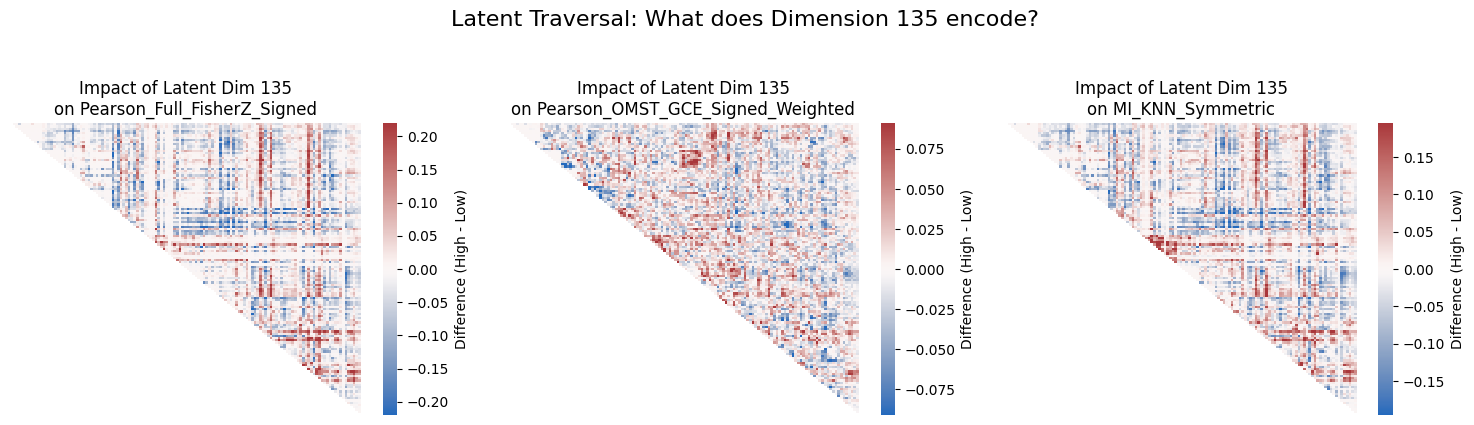

[INTERPRETACIÓN] Las regiones en ROJO aumentan su conectividad cuando la Dim 135 aumenta.
[INTERPRETACIÓN] Las regiones en AZUL disminuyen su conectividad.


In [49]:
import torch
 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

# --- CONFIG ---
FOLD_ID = 1  # Usamos el fold 1 como ejemplo
DIM_TO_VISUALIZE = 135  # ¡Tu dimensión estrella!
RANGE_SD = 2.5  # Cuántas desviaciones estándar nos movemos
STEPS = 7       # Cuántos pasos de interpolación

# Rutas (Ajustar si es necesario)
# RESULTS_DIR ya debe estar definido por tu contexto anterior
fold_dir = RESULTS_DIR / f"fold_{FOLD_ID}"
norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")
ckpt_path = fold_dir / f"vae_model_fold_{FOLD_ID}.pt"

# --- Cargar Modelo ---
# (Asumimos que la clase ConvolutionalVAE y device ya están definidos en tu notebook)
model = ConvolutionalVAE(
    input_channels=len(run_args["channels_to_use"]),
    latent_dim=run_args["latent_dim"],
    image_size=131, # Ajustar al tamaño real de tu tensor
    num_conv_layers_encoder=run_args["num_conv_layers_encoder"],
    decoder_type=run_args["decoder_type"],
    final_activation=run_args["vae_final_activation"],
    intermediate_fc_dim_config=run_args["intermediate_fc_dim_vae"],
    dropout_rate=run_args["dropout_rate_vae"],
    use_layernorm_fc=run_args["use_layernorm_vae_fc"],
).to(device)

model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# --- 1. Obtener el Vector Latente Promedio (El "Cerebro Base") ---
# Necesitamos el promedio de todos los sujetos para tener un punto de partida neutral
# Usamos 'all_fold_data' que generaste en la Celda 8
df_fold = pd.concat(all_fold_data) # O filtrar por fold si prefieres
all_embs = np.vstack(df_fold["embeddings"].values)
mu_mean = np.mean(all_embs, axis=0) # [latent_dim]
mu_std  = np.std(all_embs, axis=0)  # Para saber cuánto movernos

# --- 2. Generar el Traversal ---
# Creamos una matriz donde todas las filas son el promedio, excepto la columna DIM_TO_VISUALIZE
z_traversal = np.tile(mu_mean, (STEPS, 1))
# Interpolamos desde -SD a +SD
values = np.linspace(-RANGE_SD, RANGE_SD, STEPS)
for i, val in enumerate(values):
    # Movemos la dimensión objetivo basándonos en su propia desviación estándar
    z_traversal[i, DIM_TO_VISUALIZE] = mu_mean[DIM_TO_VISUALIZE] + (val * mu_std[DIM_TO_VISUALIZE])

# --- 3. Decodificar (Generar Conectomas) ---
z_torch = torch.from_numpy(z_traversal).float().to(device)
with torch.no_grad():
    recon_traversal = model.decode(z_torch).cpu().numpy() # [STEPS, Channels, H, W]

# --- 4. Visualizar Diferencia (Subtraction Map) ---
# Calculamos la diferencia entre el extremo "Alto" y el extremo "Bajo" de la dimensión
# Esto nos iluminará las regiones que cambian.
diff_map = recon_traversal[-1] - recon_traversal[0] # [Channels, H, W]

# Plotting
ch_idxs = run_args["channels_to_use"]
# Mapeo de nombres (Asegúrate que CHANNEL_NAME_MAP esté definido como en tu celda anterior)
ch_names_plot = [CHANNEL_NAME_MAP.get(i, f"Ch{i}") for i in ch_idxs]

fig, axes = plt.subplots(1, len(ch_idxs), figsize=(5 * len(ch_idxs), 4))
if len(ch_idxs) == 1: axes = [axes]

for i, ax in enumerate(axes):
    # Plot del mapa de diferencia (solo triángulo superior para limpieza visual si es simétrico)
    matrix = diff_map[i]
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True
    
    # Usamos escala divergente (rojo-azul) para ver aumentos y disminuciones
    limit = np.percentile(np.abs(matrix), 99) # Saturar al 99% para contraste
    
    sns.heatmap(matrix, ax=ax, center=0, cmap="vlag", mask=mask,
                vmin=-limit, vmax=limit, cbar_kws={'label': 'Difference (High - Low)'})
    ax.set_title(f"Impact of Latent Dim {DIM_TO_VISUALIZE}\non {ch_names_plot[i]}")
    ax.axis('off')

plt.suptitle(f"Latent Traversal: What does Dimension {DIM_TO_VISUALIZE} encode?", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

print(f"[INTERPRETACIÓN] Las regiones en ROJO aumentan su conectividad cuando la Dim {DIM_TO_VISUALIZE} aumenta.")
print(f"[INTERPRETACIÓN] Las regiones en AZUL disminuyen su conectividad.")

In [50]:
from sklearn.metrics import roc_auc_score
 
import pandas as pd

def confounder_only_auc(df, y="_y", s="_confounder"):
    # prob = P(Y=1 | S) estimada en TRAIN, evaluada en TEST (OOF)
    # implementamos OOF por fold para que no haya leakage del mismo test
    rows = []
    for f_test, g_test in df.groupby("fold"):
        g_train = df[df["fold"] != f_test]
        p_by_s = g_train.groupby(s)[y].mean()
        p0 = g_train[y].mean()
        p_hat = g_test[s].map(p_by_s).fillna(p0).to_numpy()
        auc = roc_auc_score(g_test[y], p_hat)
        rows.append({"fold": f_test, "auc_confounder_only": auc, "n": len(g_test)})
    out = pd.DataFrame(rows)
    return out, out["auc_confounder_only"].mean(), out["auc_confounder_only"].std(ddof=1)

# usando tu master_df:
out, m, sd = confounder_only_auc(master_df, y="_y", s="_confounder")
display(out)
print("AUC confounder-only (mean±sd):", m, sd)


fold  auc_confounder_only   n
0     1             0.684211  37
1     2             0.710526  37
2     3             0.815789  37
3     4             0.805556  36
4     5             0.763158  36

AUC confounder-only (mean±sd): 0.7558479532163743 0.05766983310911117


In [51]:
from sklearn.metrics import roc_auc_score
 

def stratified_auc(df, y="_y", p="_p", s="_confounder", min_per_class=3):
    aucs, w = [], []
    for val, g in df.groupby(s):
        n1 = int(g[y].sum()); n0 = len(g) - n1
        if n1 < min_per_class or n0 < min_per_class:
            continue
        auc = roc_auc_score(g[y], g[p])
        aucs.append(auc)
        w.append(n0*n1)  # peso natural del AUC
    if not aucs:
        return np.nan, np.nan, 0
    return float(np.mean(aucs)), float(np.average(aucs, weights=w)), int(len(aucs))

macro, wavg, k = stratified_auc(master_df, y="_y", p="_p", s="_confounder", min_per_class=3)
print("Stratified AUC macro:", macro, "| weighted:", wavg, "| domains:", k)


Stratified AUC macro: 0.7032242305813385 | weighted: 0.7032242305813385 | domains: 1


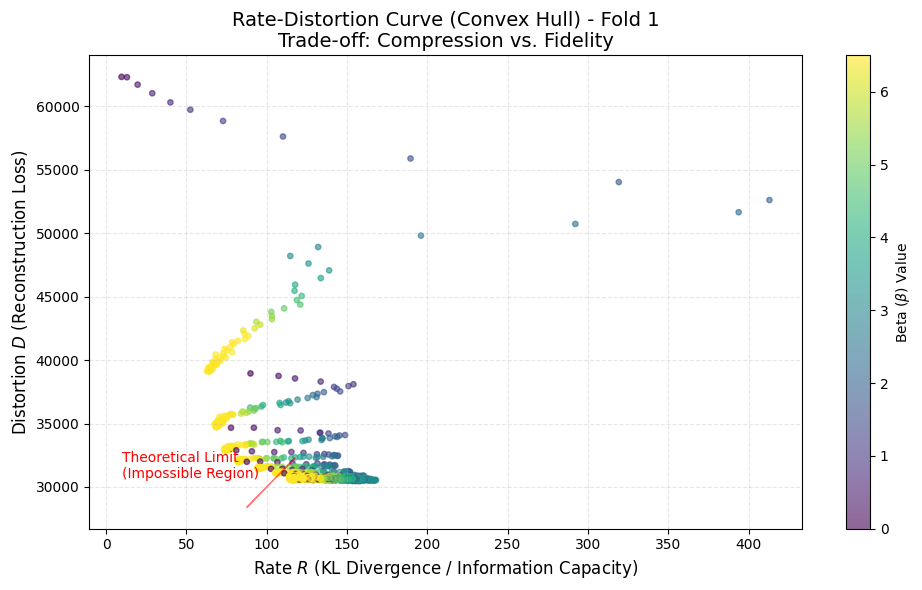

[INTERPRETACIÓN]
1. Los puntos amarillos (Beta alto) deben estar a la izquierda (Alta compresión, Mayor error).
2. Los puntos violetas (Beta bajo) deben estar a la derecha (Baja compresión, Menor error).
3. La 'frontera' inferior de esta nube de puntos es tu COTA DE PERFORMANCE.


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
 

# 1. Extraer datos del historial (Fold 1 como ejemplo)
# Puedes cambiar fold_idx a 0, 1, 2...
fold_idx = 0 
history = vae_histories[fold_idx]

# Crear DataFrame
df_rd = pd.DataFrame({
    'Rate (KLD)': history['val_kld'],
    'Distortion (Recon)': history['val_recon'],
    'Beta': history['beta'],
    'Epoch': np.arange(len(history['val_kld']))
})

# 2. Plotear la Curva Rate-Distortion
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_rd['Rate (KLD)'], 
    df_rd['Distortion (Recon)'], 
    c=df_rd['Beta'], 
    cmap='viridis', 
    alpha=0.6, 
    s=15
)
plt.colorbar(sc, label=r'Beta ($\beta$) Value')

# Etiquetas y Estilo
plt.title(f'Rate-Distortion Curve (Convex Hull) - Fold {fold_idx+1}\nTrade-off: Compression vs. Fidelity', fontsize=14)
plt.xlabel(r'Rate $R$ (KL Divergence / Information Capacity)', fontsize=12)
plt.ylabel(r'Distortion $D$ (Reconstruction Loss)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Flecha indicando la dirección de mejora teórica
# (Queremos bajar el error y bajar la capacidad = Esquina inferior izquierda)
plt.arrow(
    x=df_rd['Rate (KLD)'].mean(), 
    y=df_rd['Distortion (Recon)'].mean(), 
    dx=-df_rd['Rate (KLD)'].std(), 
    dy=-df_rd['Distortion (Recon)'].std(), 
    color='red', width=0.05, head_width=0.3, alpha=0.5
)
plt.text(
    df_rd['Rate (KLD)'].min(), 
    df_rd['Distortion (Recon)'].min(), 
    "Theoretical Limit\n(Impossible Region)", 
    fontsize=10, color='red', ha='left', va='bottom'
)

plt.tight_layout()
plt.savefig(OUTPUT_FIG_DIR / "figure_rate_distortion_curve.png", dpi=300)
plt.show()

print("[INTERPRETACIÓN]")
print("1. Los puntos amarillos (Beta alto) deben estar a la izquierda (Alta compresión, Mayor error).")
print("2. Los puntos violetas (Beta bajo) deben estar a la derecha (Baja compresión, Menor error).")
print("3. La 'frontera' inferior de esta nube de puntos es tu COTA DE PERFORMANCE.")

In [53]:
# Usando tu dataframe mi_mean ya calculado en Celda IT-3
plt.figure(figsize=(8, 6))

# Ordenar para intentar dibujar una "frontera"
df_ib = mi_mean.sort_values("IS_bits_w")

# Plotear dimensiones latentes
plt.scatter(df_ib["IS_bits_w"], df_ib["IY_bits_w"], alpha=0.5, label="Latent Dims")

# Calcular una frontera convexa empírica (Convex Hull superior)
from scipy.spatial import ConvexHull
points = df_ib[["IS_bits_w", "IY_bits_w"]].values
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-', alpha=0.3)

plt.xlabel("Information about SITE (Bits) - Cost")
plt.ylabel("Information about DIAGNOSIS (Bits) - Value")
plt.title("Information Plane: The Trade-off Frontier")
plt.grid(True, alpha=0.3)
plt.show()

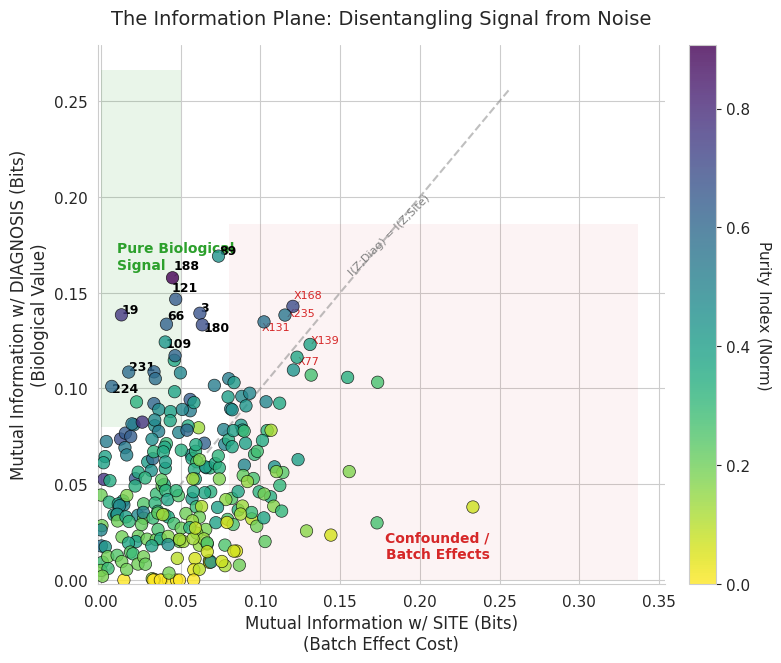

[OK] Gráfica de alto impacto guardada en: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_information_plane_publication.pdf


In [54]:
# ===================== CELDA GRÁFICA: INFORMATION PLANE (PUBLICATION READY) =====================
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import matplotlib.patches as patches

# Asegúrate de tener 'mi_mean' (salida de Celda IT-3)
if "mi_mean" not in globals():
    raise ValueError("⚠️ Ejecuta la CELDA IT-3 para generar 'mi_mean' antes de esto.")

# Configuración Estética
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False
})

# Datos
df_plot = mi_mean.copy()
x = df_plot["IS_bits_w"]  # Info Sitio (Ruido)
y = df_plot["IY_bits_w"]  # Info Diagnóstico (Señal)
dims = df_plot["dim"].astype(int)

# Crear Figura
fig, ax = plt.subplots(figsize=(8, 7))

# 1. Definir Zonas (Heurística visual)
max_x, max_y = x.max() * 1.1, y.max() * 1.1
# Zona "Ideal" (Alta Biología, Bajo Sitio)
rect_ideal = patches.Rectangle((0, 0.08), 0.05, max_y, linewidth=0, facecolor='#2ca02c', alpha=0.1)
ax.add_patch(rect_ideal)
ax.text(0.01, max_y*0.95, "Pure Biological\nSignal", color='#2ca02c', fontsize=10, fontweight='bold', va='top')

# Zona "Peligrosa" (Alto Sitio)
rect_danger = patches.Rectangle((0.08, 0), max_x, max_y, linewidth=0, facecolor='#d62728', alpha=0.05)
ax.add_patch(rect_danger)
ax.text(max_x*0.95, 0.01, "Confounded /\nBatch Effects", color='#d62728', fontsize=10, fontweight='bold', ha='right', va='bottom')

# 2. Scatter Plot Principal
# Coloreamos por "Pureza Normalizada" para resaltar los buenos candidatos
sc = ax.scatter(
    x, y, 
    c=df_plot["purity_norm_w"], 
    cmap="viridis_r", # Invertido: Amarillo/Claro = Puro, Oscuro = Sucio
    s=80, 
    alpha=0.8, 
    edgecolors='k', 
    linewidth=0.5,
    zorder=10
)

# 3. Línea de Identidad (Puntos abajo de esto tienen más ruido que señal)
ax.plot([0, max_x], [0, max_x], ls='--', c='gray', alpha=0.5, zorder=1)
ax.text(max_x*0.6, max_x*0.62, "I(Z;Diag) = I(Z;Site)", rotation=45, color='gray', fontsize=8)

# 4. Etiquetar Puntos Interesantes
texts = []
# A) Top 10 Mejores (Pureza)
top_pure = df_plot.head(10)
for _, row in top_pure.iterrows():
    texts.append(ax.text(row["IS_bits_w"], row["IY_bits_w"], str(int(row["dim"])), fontweight='bold', color='black', fontsize=9))

# B) Top 5 "Peores" (Alto Sitio, pero con algo de señal que tienta al modelo)
# Buscamos dims con IY > 0.05 (señal) pero IS > 0.10 (muy sucias)
bad_ones = df_plot[(df_plot["IY_bits_w"] > 0.05) & (df_plot["IS_bits_w"] > 0.10)].head(5)
for _, row in bad_ones.iterrows():
    texts.append(ax.text(row["IS_bits_w"], row["IY_bits_w"], f"X{int(row['dim'])}", color='#d62728', fontsize=8))

# Ajustar texto para que no se solapen
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), ax=ax)

# 5. Decoración Final
cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Purity Index (Norm)", rotation=270, labelpad=15)

ax.set_xlabel("Mutual Information w/ SITE (Bits)\n(Batch Effect Cost)", fontsize=12)
ax.set_ylabel("Mutual Information w/ DIAGNOSIS (Bits)\n(Biological Value)", fontsize=12)
ax.set_title("The Information Plane: Disentangling Signal from Noise", fontsize=14, pad=15)
ax.set_xlim(left=-0.002)
ax.set_ylim(bottom=-0.002)

# Guardar
out_path = OUTPUT_FIG_DIR / "figure_information_plane_publication.pdf"
plt.savefig(out_path, bbox_inches='tight')
plt.savefig(str(out_path).replace('.pdf', '.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"[OK] Gráfica de alto impacto guardada en: {out_path}")

In [56]:
# ===================== CELDA FIG-1 (CORREGIDA): QC LATENTE CON ANOTACIONES =====================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection

fig, axes = plt.subplots(2, 2, figsize=(11, 9))
fig.suptitle("Latent Space Quality Control: β-VAE (β=2.5, 3 channels)", fontsize=14, y=0.98)

# -------------------------------------------------------------------------
# Panel A: Silhouette vs Leakage por fold
# -------------------------------------------------------------------------
ax = axes[0, 0]
x = df_summary["silhouette_latent"]
y = df_summary["BA_Manufacturer_latent_mu"]
colors = plt.cm.RdYlGn_r((y - 0.33) / (0.8 - 0.33))  # Rojo=alto leakage

scatter = ax.scatter(x, y, c=colors, s=200, edgecolors='black', linewidth=1.5, zorder=3)
for i, fold in enumerate(df_summary["fold"]):
    ax.annotate(f"F{int(fold)}", (x.iloc[i], y.iloc[i]), 
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

ax.axhline(0.333, color='red', linestyle='--', alpha=0.7, label='Chance level')
ax.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate leakage')
ax.fill_between([x.min()-0.01, x.max()+0.01], 0.333, 0.5, alpha=0.1, color='orange', label='Warning zone')

ax.set_xlabel("Silhouette Score (AD vs CN separation)")
ax.set_ylabel("Manufacturer Decodability (Balanced Acc.)")
ax.set_title("A. Biological Signal vs Batch Leakage")
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# Panel B: Information Plane (MI bits)
# -------------------------------------------------------------------------
ax = axes[0, 1]
# Usar datos de mi_mean de la Celda IT-3
top_dims = mi_mean.head(30)
bottom_dims = mi_mean.tail(30)

ax.scatter(mi_mean["IS_bits_w"], mi_mean["IY_bits_w"], 
           c='lightgray', alpha=0.3, s=20, label='Other dims')
ax.scatter(top_dims["IS_bits_w"], top_dims["IY_bits_w"], 
           c='#2ca02c', s=60, edgecolors='black', linewidth=0.5, label='Top-30 Biological', zorder=3)
ax.scatter(bottom_dims["IS_bits_w"], bottom_dims["IY_bits_w"], 
           c='#d62728', s=60, edgecolors='black', linewidth=0.5, label='Top-30 Confounded', zorder=3)

# Línea de igual información
max_val = max(mi_mean["IS_bits_w"].max(), mi_mean["IY_bits_w"].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='IY = IS')
ax.fill_between([0, max_val], [0, max_val], [max_val, max_val], alpha=0.1, color='green', label='Biological > Site')

ax.set_xlabel("I(Z; Site) bits")
ax.set_ylabel("I(Z; Diagnosis) bits")
ax.set_title("B. Information Plane (per latent dimension)")
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# Panel C: Rate-Distortion trajectory
# -------------------------------------------------------------------------
ax = axes[1, 0]
fold_idx = 0  # Mejor fold
history = vae_histories[fold_idx]

# Colorear por época para mostrar evolución
points = np.array([history['val_kld'], history['val_recon']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, len(history['val_kld'])))
lc.set_array(np.arange(len(history['val_kld'])))
lc.set_linewidth(2)
ax.add_collection(lc)

# Puntos de referencia
scatter = ax.scatter(history['val_kld'][::50], history['val_recon'][::50], 
                    c=np.arange(0, len(history['val_kld']), 50), cmap='viridis', 
                    s=50, zorder=3, edgecolors='black')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Epoch')

ax.set_xlabel("Rate: KL Divergence (nats)")
ax.set_ylabel("Distortion: Reconstruction MSE")
ax.set_title(f"C. Rate-Distortion Trajectory (Fold {fold_idx+1})")
ax.grid(True, alpha=0.3)

# Anotar dirección de β
ax.annotate('', xy=(history['val_kld'][-1], history['val_recon'][-1]),
            xytext=(history['val_kld'][0], history['val_recon'][0]),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.text(history['val_kld'][-1], history['val_recon'][-1], 'Training →', color='red', fontsize=9)

# -------------------------------------------------------------------------
# Panel D: Ablation summary (Corregido para leer el nuevo df_ablation)
# -------------------------------------------------------------------------
ax = axes[1, 1]
if 'df_ablation' in globals():
    # Extraer las medias desde el formato 'Long'
    val_auc_full = df_ablation[(df_ablation["Metric"] == "Diagnosis AUC") & (df_ablation["Space"] == "Full Space")]["Score"].mean()
    val_auc_pure = df_ablation[(df_ablation["Metric"] == "Diagnosis AUC") & (df_ablation["Space"] == "Purified Space")]["Score"].mean()
    val_leak_full = df_ablation[(df_ablation["Metric"] == "Site Leakage") & (df_ablation["Space"] == "Full Space")]["Score"].mean()
    val_leak_pure = df_ablation[(df_ablation["Metric"] == "Site Leakage") & (df_ablation["Space"] == "Purified Space")]["Score"].mean()
    
    values = [val_auc_full, val_auc_pure, val_leak_full, val_leak_pure]
    x_pos = np.arange(len(values))
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
    
    bars = ax.bar(x_pos, values, color=colors, edgecolor='black', linewidth=1.2)
    
    # Añadir valores numéricos encima de las barras
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_ylabel("Score")
    ax.set_title("D. Ablation: Full vs Purified Subspace")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Diag\n(Full)', 'Diag\n(Top-30)', 'Leakage\n(Full)', 'Leakage\n(Top-30)'], fontsize=9)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Línea de referencia para leakage chance
    ax.axhline(0.333, color='red', linestyle='--', alpha=0.5, label='Chance')
    ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_FIG_DIR / "figure_qc_summary_paper.png", dpi=300, bbox_inches='tight')
plt.savefig(OUTPUT_FIG_DIR / "figure_qc_summary_paper.pdf", bbox_inches='tight')
plt.show()

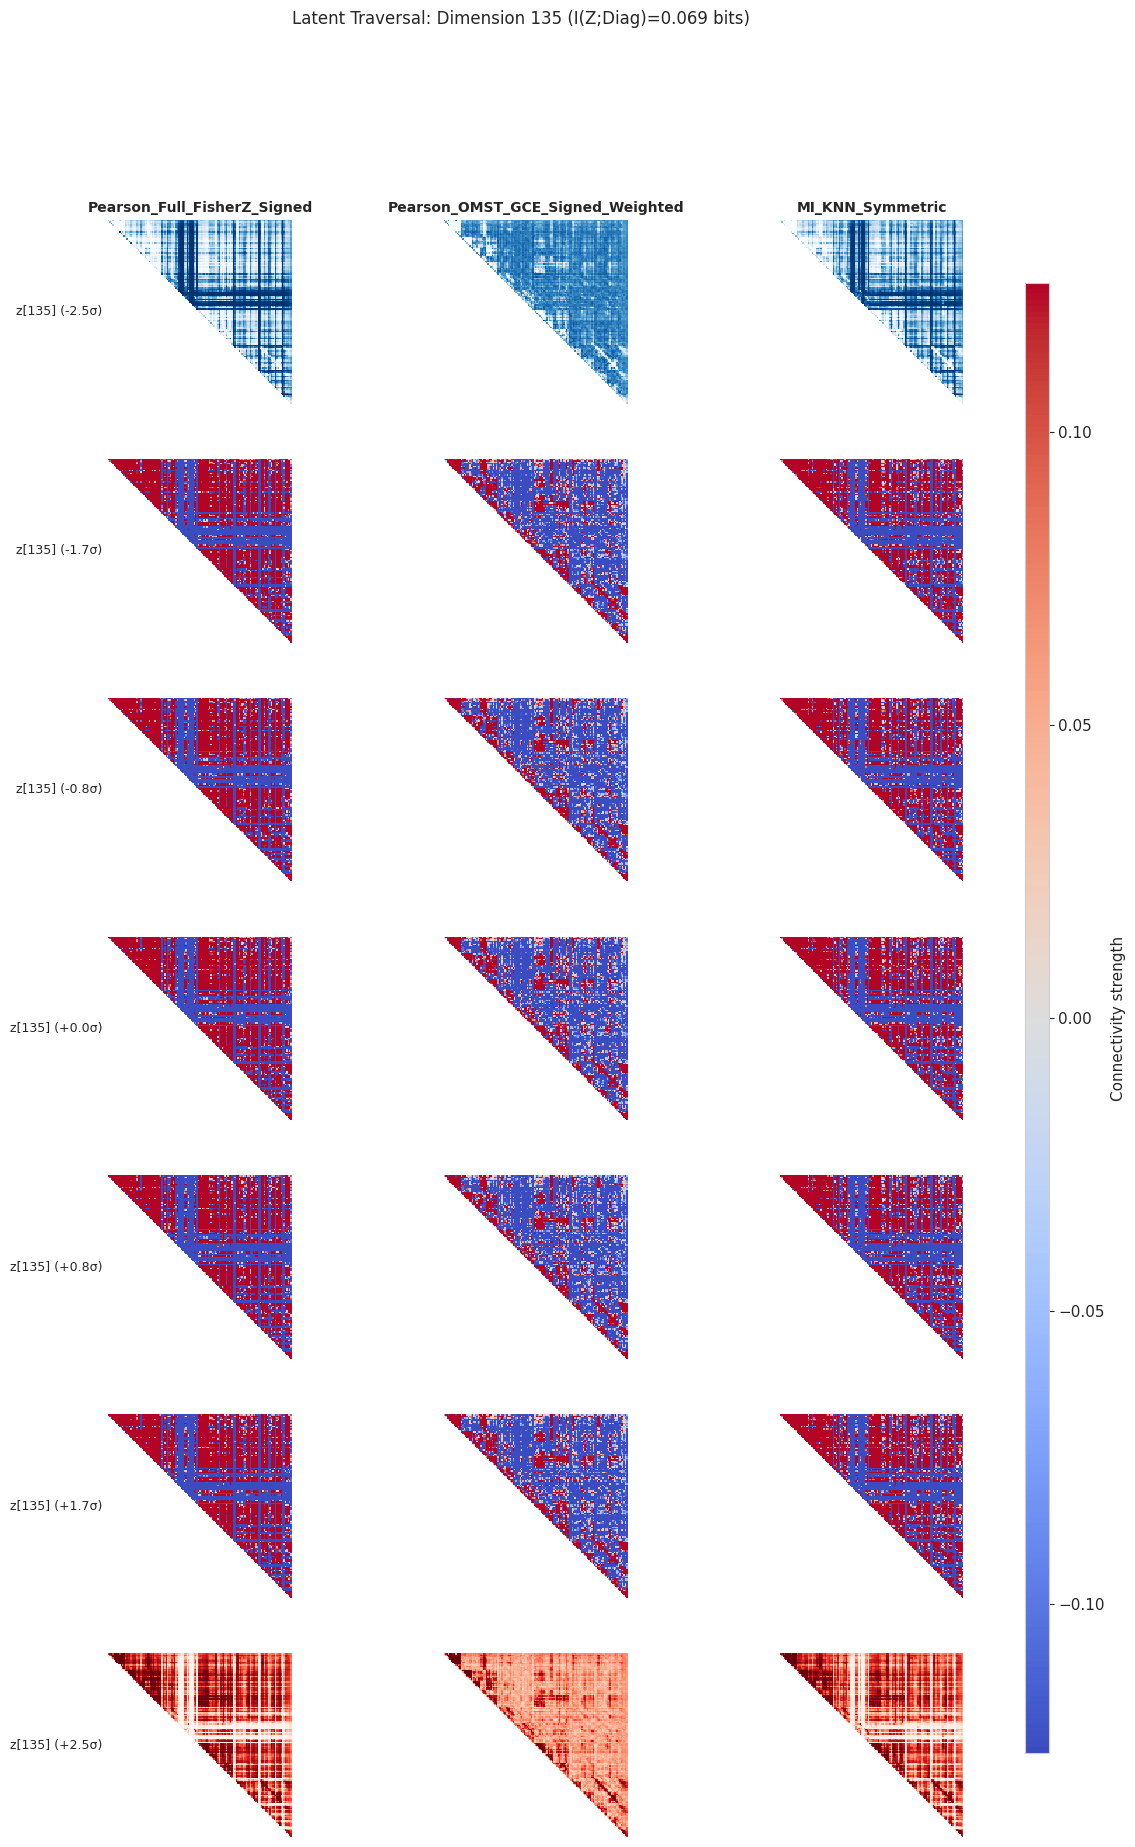

In [57]:
# ===================== CELDA FIG-2: LATENT TRAVERSAL MEJORADO =====================
import torch
 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_latent_traversal_enhanced(model, z_base, dim_idx, dim_std, 
                                   channel_names, n_steps=7, range_sd=2.5,
                                   device='cpu'):
    """
    Visualización mejorada del traversal latente con diferencias y anatomía.
    """
    # Generar interpolación
    values = np.linspace(-range_sd, range_sd, n_steps)
    z_traversal = np.tile(z_base, (n_steps, 1))
    
    for i, val in enumerate(values):
        z_traversal[i, dim_idx] = z_base[dim_idx] + (val * dim_std[dim_idx])
    
    # Decodificar
    with torch.no_grad():
        z_torch = torch.from_numpy(z_traversal).float().to(device)
        recon = model.decode(z_torch).cpu().numpy()
    
    n_channels = len(channel_names)
    fig = plt.figure(figsize=(4 * n_channels, 3 * n_steps))
    gs = GridSpec(n_steps, n_channels, figure=fig, hspace=0.3, wspace=0.3)
    
    # Calcular diferencia máxima para escala de color consistente
    diff_map = recon[-1] - recon[0]
    vmax = np.percentile(np.abs(diff_map), 95)
    
    for step in range(n_steps):
        for ch in range(n_channels):
            ax = fig.add_subplot(gs[step, ch])
            
            matrix = recon[step, ch]
            # Máscara triangular superior
            mask = np.tril(np.ones_like(matrix), k=-1).astype(bool)
            
            # Color según el valor del paso
            if step == 0:
                cmap = 'Blues_r'
                title_suffix = f" (-{range_sd}σ)"
            elif step == n_steps - 1:
                cmap = 'Reds'
                title_suffix = f" (+{range_sd}σ)"
            else:
                cmap = 'coolwarm'
                title_suffix = f" ({values[step]:+.1f}σ)"
            
            sns.heatmap(matrix, mask=mask, cmap=cmap, center=0 if step not in [0, n_steps-1] else None,
                       vmin=-vmax if step not in [0, n_steps-1] else None,
                       vmax=vmax if step not in [0, n_steps-1] else None,
                       square=True, ax=ax, cbar=False,
                       xticklabels=False, yticklabels=False)
            
            if step == 0:
                ax.set_title(f"{channel_names[ch]}", fontsize=10, fontweight='bold')
            if ch == 0:
                ax.set_ylabel(f"z[{dim_idx}]{title_suffix}", fontsize=9, rotation=0, ha='right', va='center')
    
    # Colorbar global
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(-vmax, vmax))
    plt.colorbar(sm, cax=cbar_ax, label='Connectivity strength')
    
    plt.suptitle(f"Latent Traversal: Dimension {dim_idx} (I(Z;Diag)={mi_mean.loc[dim_idx, 'IY_bits_w']:.3f} bits)", 
                 fontsize=12, y=0.98)
    
    return fig

# Uso con tu mejor dimensión (135)
DIM_TO_PLOT = 135  # Tu top dim según diff_norm

# Preparar datos
df_fold = pd.concat(all_fold_data)
all_embs = np.vstack(df_fold["embeddings"].values)
z_mean = np.mean(all_embs, axis=0)
z_std = np.std(all_embs, axis=0)

# Cargar modelo (asumiendo que ya está cargado)
fig = plot_latent_traversal_enhanced(
    model=vae,
    z_base=z_mean,
    dim_idx=DIM_TO_PLOT,
    dim_std=z_std,
    channel_names=[CHANNEL_NAME_MAP[i] for i in run_args["channels_to_use"]],
    n_steps=7,
    range_sd=2.5,
    device=device
)

plt.savefig(OUTPUT_FIG_DIR / f"figure_traversal_dim{DIM_TO_PLOT}_enhanced.png", dpi=300, bbox_inches='tight')
plt.show()

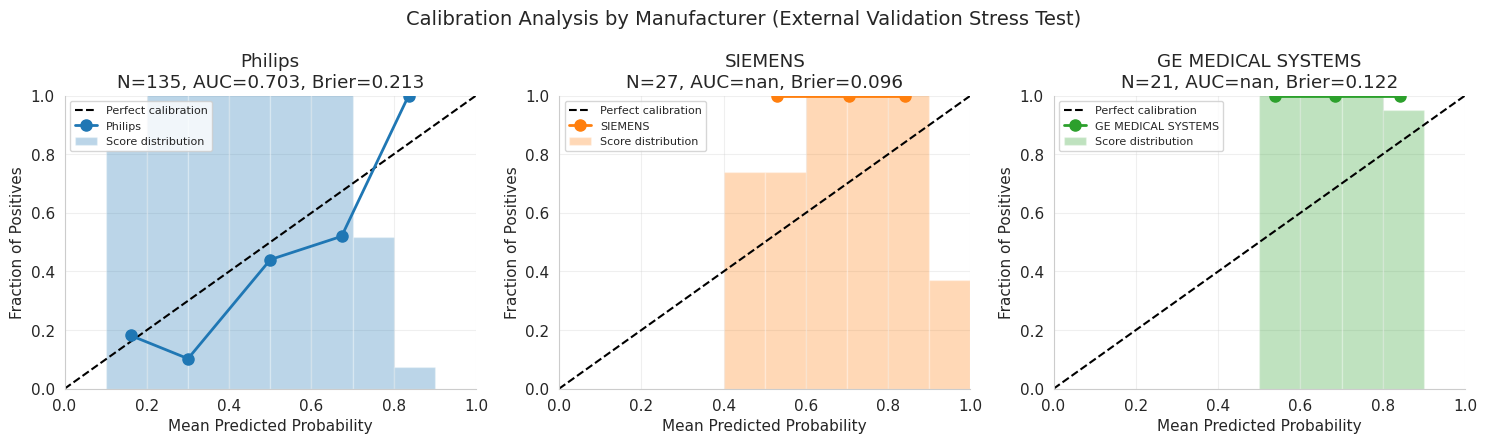

In [58]:
# ===================== CELDA FIG-3: CALIBRACIÓN POR FABRICANTE =====================
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
fig.suptitle("Calibration Analysis by Manufacturer (External Validation Stress Test)", fontsize=14)

manufacturers = master_df["_confounder"].unique()
colors = {'Philips': '#1f77b4', 'SIEMENS': '#ff7f0e', 'GE MEDICAL SYSTEMS': '#2ca02c'}

for idx, (ax, manufacturer) in enumerate(zip(axes, manufacturers)):
    df_sub = master_df[master_df["_confounder"] == manufacturer]
    
    if len(df_sub) < 10:
        ax.text(0.5, 0.5, f"Insufficient data\nfor {manufacturer}", ha='center', va='center')
        ax.axis('off')
        continue
    
    prob_true, prob_pred = calibration_curve(df_sub["_y"], df_sub["_p"], n_bins=5, strategy='uniform')
    
    # Reliability diagram
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax.plot(prob_pred, prob_true, 'o-', color=colors.get(manufacturer, 'gray'), 
            markersize=8, linewidth=2, label=f'{manufacturer}')
    
    # Histograma de confianza
    ax.hist(df_sub["_p"], bins=10, range=(0, 1), alpha=0.3, color=colors.get(manufacturer, 'gray'), 
            density=True, label='Score distribution')
    
    # Métricas
    brier = brier_score_loss(df_sub["_y"], df_sub["_p"])
    auc = roc_auc_score(df_sub["_y"], df_sub["_p"]) if df_sub["_y"].nunique() > 1 else np.nan
    
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Fraction of Positives")
    ax.set_title(f"{manufacturer}\nN={len(df_sub)}, AUC={auc:.3f}, Brier={brier:.3f}")
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(OUTPUT_FIG_DIR / "figure_calibration_by_manufacturer.png", dpi=300, bbox_inches='tight')
plt.show()

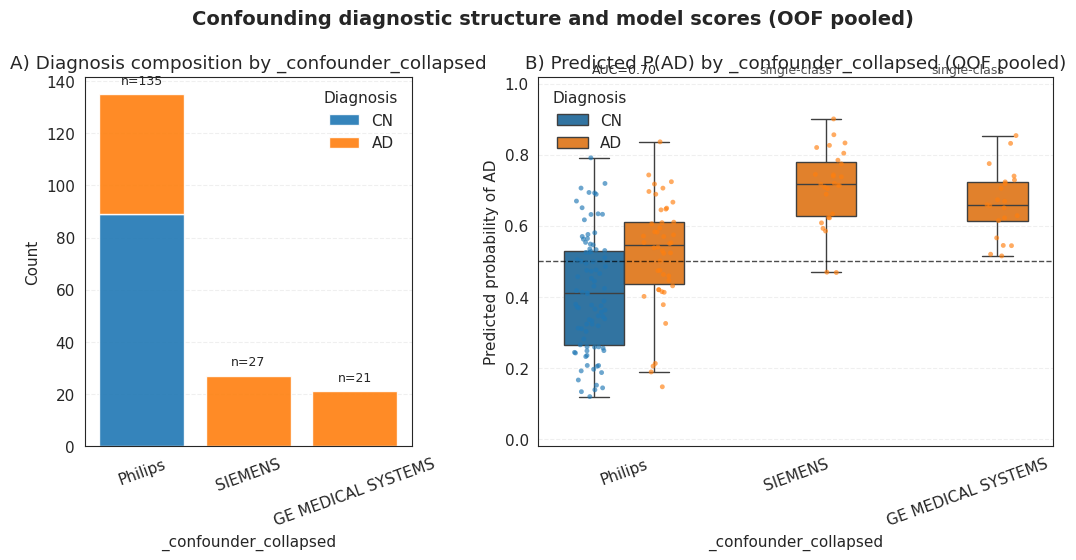

[OK] Guardado: /home/diego/proyectos/betavae-xai-ad/results/vae_3channels_beta65_pro/training_qc/figure_confounding__confounder_collapsed_composition_and_scores.pdf/.png

[LECTURA RÁPIDA]
- Panel A: si algún dominio es casi todo AD o casi todo CN => confounding fuerte.
- Panel B: dentro de un mismo dominio, AD debería tender a scores mayores que CN.
  Si un dominio es single-class, NO se puede inferir discriminación clínica ahí.


In [59]:
# ===================== FIG: Confounding (Manufacturer) + Predicted Scores (paper-grade) =====================
 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

# Requiere: master_df (de tu CELDA IT-0) con columnas: _p (score), _y (0/1), y Manufacturer o _confounder_collapsed
if "master_df" not in globals():
    raise ValueError("Necesitás master_df (ejecutá tu CELDA IT-0).")

# --- Elegir columna de dominio/confounder (preferí collapsed si existe) ---
group_col = "_confounder_collapsed" if "_confounder_collapsed" in master_df.columns else (
    "Manufacturer" if "Manufacturer" in master_df.columns else None
)
if group_col is None:
    raise ValueError("No encuentro columna de confounder (Manufacturer/_confounder_collapsed).")

df = master_df.copy()
df[group_col] = df[group_col].astype(str).str.strip().replace({"nan": "Unknown", "None": "Unknown"}).fillna("Unknown")
df["Diagnosis"] = np.where(df["_y"].astype(int) == 1, "AD", "CN")

# --- Ordenar grupos por tamaño ---
order = df[group_col].value_counts().index.tolist()

# --- Calcular AUC dentro de cada grupo si hay soporte (ambas clases) ---
auc_by_group = {}
note_by_group = {}
for g, gg in df.groupby(group_col):
    y = gg["_y"].astype(int).to_numpy()
    p = gg["_p"].astype(float).to_numpy()
    if len(np.unique(y)) < 2:
        auc_by_group[g] = np.nan
        note_by_group[g] = "single-class"
    else:
        try:
            auc_by_group[g] = float(roc_auc_score(y, p))
            note_by_group[g] = "ok"
        except Exception:
            auc_by_group[g] = np.nan
            note_by_group[g] = "err"

# --- Tabla de composición para Panel A ---
ct = pd.crosstab(df[group_col], df["Diagnosis"]).reindex(order).fillna(0).astype(int)
ct["N"] = ct.sum(axis=1)

# --- Figura ---
sns.set_style("white")
fig = plt.figure(figsize=(12.5, 4.8))
gs = fig.add_gridspec(1, 2, width_ratios=[1.05, 1.65], wspace=0.30)

# =====================
# Panel A: composición por dominio
# =====================
ax1 = fig.add_subplot(gs[0, 0])

bottom = np.zeros(len(ct), dtype=int)
for lab in ["CN", "AD"]:
    vals = ct[lab].to_numpy() if lab in ct.columns else np.zeros(len(ct), dtype=int)
    ax1.bar(ct.index, vals, bottom=bottom, label=lab, alpha=0.9)
    bottom += vals

# anotar N encima
for i, (g, row) in enumerate(ct.iterrows()):
    ax1.text(i, row["N"] + max(ct["N"])*0.02, f"n={row['N']}", ha="center", va="bottom", fontsize=9)

ax1.set_title(f"A) Diagnosis composition by {group_col}")
ax1.set_ylabel("Count")
ax1.set_xlabel(group_col)
ax1.tick_params(axis="x", rotation=20)
ax1.grid(True, axis="y", linestyle="--", alpha=0.3)
ax1.legend(frameon=False, title="Diagnosis")

# =====================
# Panel B: scores por dominio (CN vs AD)
# =====================
ax2 = fig.add_subplot(gs[0, 1])

# box + jitter (sin duplicar leyendas)
sns.boxplot(
    data=df, x=group_col, y="_p", hue="Diagnosis",
    order=order, showfliers=False, width=0.7, ax=ax2
)
sns.stripplot(
    data=df, x=group_col, y="_p", hue="Diagnosis",
    order=order, dodge=True, jitter=0.18, size=3.5, alpha=0.65, linewidth=0, ax=ax2
)

# limpiar leyenda duplicada
handles, labels = ax2.get_legend_handles_labels()
# esperamos 4 entradas (box CN/AD + strip CN/AD); nos quedamos con las primeras 2 únicas
uniq = {}
for h, l in zip(handles, labels):
    if l in ["CN", "AD"] and l not in uniq:
        uniq[l] = h
ax2.legend([uniq["CN"], uniq["AD"]], ["CN", "AD"], frameon=False, title="Diagnosis", loc="upper left")

ax2.axhline(0.5, linestyle="--", linewidth=1.0, color="black", alpha=0.7)
ax2.set_ylim(-0.02, 1.02)
ax2.set_title(f"B) Predicted P(AD) by {group_col} (OOF pooled)")
ax2.set_ylabel("Predicted probability of AD")
ax2.set_xlabel(group_col)
ax2.tick_params(axis="x", rotation=20)
ax2.grid(True, axis="y", linestyle="--", alpha=0.3)

# anotar AUC dentro de cada dominio (si computable), o marcar single-class
y_top = 1.02
for i, g in enumerate(order):
    aucg = auc_by_group.get(g, np.nan)
    note = note_by_group.get(g, "")
    if np.isfinite(aucg):
        ax2.text(i, y_top, f"AUC={aucg:.2f}", ha="center", va="bottom", fontsize=9)
    else:
        ax2.text(i, y_top, f"{note}", ha="center", va="bottom", fontsize=9, alpha=0.8)

fig.suptitle("Confounding diagnostic structure and model scores (OOF pooled)", y=1.02, fontsize=14, weight="bold")
plt.tight_layout()

out = OUTPUT_FIG_DIR / f"figure_confounding_{group_col}_composition_and_scores"
plt.savefig(f"{out}.pdf", bbox_inches="tight")
plt.savefig(f"{out}.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"[OK] Guardado: {out}.pdf/.png")
print("\n[LECTURA RÁPIDA]")
print("- Panel A: si algún dominio es casi todo AD o casi todo CN => confounding fuerte.")
print("- Panel B: dentro de un mismo dominio, AD debería tender a scores mayores que CN.")
print("  Si un dominio es single-class, NO se puede inferir discriminación clínica ahí.")


=== TABLA DE CONTINGENCIA: FABRICANTE vs DIAGNÓSTICO ===


ResearchGroup_Mapped  AD  CN  MCI
Manufacturer                     
GE MEDICAL SYSTEMS    21   0   28
Philips               46  89  139
SIEMENS               28   0   83

<Figure size 800x500 with 0 Axes>

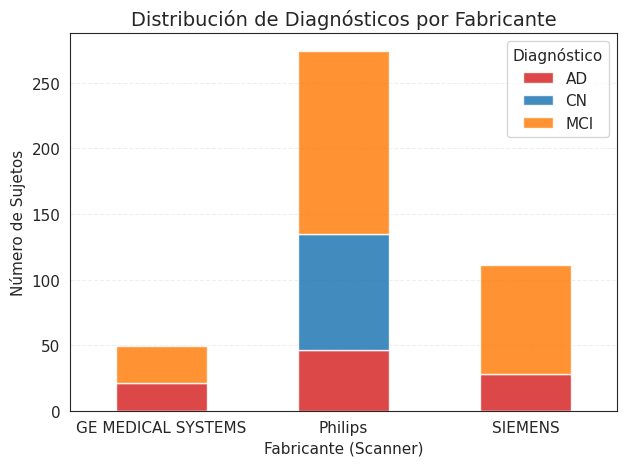


=== PROBABILIDAD DE SER CONTROL (CN) DADO EL FABRICANTE ===
P(CN | GE MEDICAL SYSTEMS) = 0.00 (0/49)
P(CN | Philips) = 0.32 (89/274)
P(CN | SIEMENS) = 0.00 (0/111)


In [60]:
# ===================== CELDA DE DIAGNÓSTICO: DISTRIBUCIÓN POR FABRICANTE =====================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos (Ajusta el path si es necesario)
df = pd.read_csv("/home/diego/proyectos/betavae-xai-ad/data/SubjectsData_AAL3_procesado2.csv")

# Crear Tabla Cruzada
ct = pd.crosstab(df['Manufacturer'], df['ResearchGroup_Mapped'])
print("=== TABLA DE CONTINGENCIA: FABRICANTE vs DIAGNÓSTICO ===")
display(ct)

# Visualización
plt.figure(figsize=(8, 5))
ct.plot(kind='bar', stacked=True, color=['#d62728', '#1f77b4', '#ff7f0e'], alpha=0.85)
plt.title("Distribución de Diagnósticos por Fabricante", fontsize=14)
plt.ylabel("Número de Sujetos")
plt.xlabel("Fabricante (Scanner)")
plt.xticks(rotation=0)
plt.legend(title='Diagnóstico')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Cálculo de Probabilidad Condicional P(CN | Fabricante)
print("\n=== PROBABILIDAD DE SER CONTROL (CN) DADO EL FABRICANTE ===")
for manuf in ct.index:
    total = ct.loc[manuf].sum()
    n_cn = ct.loc[manuf, 'CN'] if 'CN' in ct.columns else 0
    p_cn = n_cn / total
    print(f"P(CN | {manuf}) = {p_cn:.2f} ({n_cn}/{total})")